# Final Report
Problem Set 6 / Group Project  
EN.685.648.81.FA22 Data Science   
December 11, 2022  


# Group 1
* Sakib Ahmed
* Tanner Amundsen
* David Arteche
* Eva Jin
* Emily Russell
* Yisheng Tang



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import pandas as pd
import duckdb
from tabulate import tabulate

sns.set(style="whitegrid")

THEME = "darkslategray"

In [3]:
print(duckdb.__version__)

0.5.1


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Get

## Datawarehouse ##
In this project, we have to deal with different types of airbnb data from Q3 2021 to Q3 2022 fro Washington D.C. The data includes listings, reviews, calendar and neighbourhood. As a secondary dataset, we chose to use the crime data for the same time range in Washington D.C which we have introduced it in the README file.

In order to create the database for further steps of the project, we created this datawarehouse.py script to load the data into the ps6.duckdb. The datawarehouse was fully encapsulated as DatawareHouse class and initialize the connection to the database in the constructor. We have many different methods defined in the class, such as createAllListings, createNeighborhood, createReviews, createCalendar and createCrime. The main functionality for those methods are loading the CSV file for different types of data and create the table and insert the data into those tables. There are also some data cleaning in the methods. For example, we convert the text type price into a float type and also append the neighbourhood for each crime so that we can link crimes to neighbourhoods, and neighbourhoods to listings. 

Other than that, we also created a couple views in the database to make the further analysis easier. We have latest_listings (one listing per property), last_scraped, neighborhood_crimes and full_latest_listings (one listing per property, joined to crime statistics for the neighbourhood). Those views are helpful when we did the work in the ASK step and EDA step.

### How to run the script ###
The primary and secondary source data files must be stored in the AirBnB_WashDC subdirectory. The primary source compressed files must be extracted in the same subdirectory, resulting in detailed listings having an appended " 2" in the filename due to having the same name as the summary listing sources (e.g. 11Jun22 listings 2.csv).

After running the script, all the data needed for ASK, EDA and modeling steps will be loaded into the ps6.duckdb. You will see 6 tables and 4 views were created.

In [5]:
%run -i 'datawarehouse.py'

all_listing tables have been created
neighborhoods table has been created
calendar12_2021.csv
calendar03_2022.csv
calendar06_2022.csv
calendar09_2022.csv
calendar12_2021.csv  cleaned
calendar03_2022.csv  cleaned
calendar06_2022.csv  cleaned
calendar09_2022.csv  cleaned
calendar tables have been created
crime tables have been created


# Ask



## CoNVO

### 1. Context

AirBnB is a digital service that connects private individuals who want to rent rooms in their home for a short time with those who are looking to rent a room for an overnight stay. AirBnb is an application platform which facilitate this activity. In AirBnB, those who are offering their home's for rent are called 'hosts' and those who are renting them are 'guests'. AirBnB can be compared to a hotel booking model, except the booked rooms are owned by private individuals in their homes.

The city of Washington D.C. has many AirBnB rentals distributed across the city. As guests look to book a room, they use many signals provided by the AirBnB platform to make their decision, these include - host status (super host), verification, location, reviews, neighborhood, availability, price, and other listing information to narrow down their results.

### 2. Need

For the average host, pricing is a difficult process and understanding all the factors that impact pricing strategy can be difficult. A typical AirBnB host in Washington D.C. does not have the resources to compare pricing across their locality to determine a competitive price that increase bookings and ultimately revenue. The target host demographic that would best be served by this model are those who are pricing their listings for under $1000 a night, as that makes up about 98% of the AirBnB market in Washington D.C.  

Hosts would benefit from a model that allowed them to input characteristics of their listing and get a range of possible prices as determined by similar listings in their area. To maximize the predictive capability of the model, a secondary data set is utilized that considers the impact of crime as a factor in influencing listing prices. 

### 3. Vision

Our model will be used to enable hosts to set competitive listing prices and reference what factors can be used to maximize listing prices and revenues. Hosts can enter factors that match their listing, and get a recommended listing price and range. In building a listing, hosts can reference what factors will lead to increased listing prices, and make improvements or adjustments accordingly. Using other factors of importance to location of listings, the client will see improved pricing power and accuracy. 

### 4. Outcome

The model will be used as used as a baseline to help hosts price their AirBnBs more competitively in their market by knowing which factors will lead to the most pricing power. This will lead to increased revenue, and increased understanding on what factors can be used to maximize revenue. We will make the model available online for any new host to use when deciding on a price for their listing.

## Queries

The target variable for our model is price and the secondary data set is crime data from the Washington, DC Metropolitan Police Department. 

We endeavored to answer the following questions:

1. What attributes have the most impact on the price of an AirBnB listing?
2. What is the role of the location attribute (lat/log) in listing prices?
3. Does the crime rate of a neighborhood impact the price of AirBnB listings in that neighborhood? 
 
_See queries.ipynb for more detailed information._


### Data Loading

In [6]:
con = duckdb.connect(database='ps6.duckdb', read_only=True)

In [7]:
con.execute("select count(id) from latest_listings;")
print(con.fetchall())

[(10560,)]


Describe the database tables and data types.

In [8]:
con.execute("DESCRIBE")
print(con.fetchall())

[('all_listings', ['accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'description', 'first_review', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'id', 'instant_bookable', 'last_review', 'last_scraped', 'latitude', 'license', 'listing_url', 'longitude', 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights', 'maximum_nights_

Obtain all listings from the data warehouse and save to pandas dataframe.

In [9]:
all_listings = con.execute("SELECT * from all_listings").df()

Obtain a list of neighborhoods from the neighborhoods table. and save to a pandas data frame.

## Neighborhoods

In [10]:
neighborhoods = con.execute("SELECT * from neighborhoods").df()

Display a list of the prices from all listings where price is less than $5. These can be filtered out.

In [11]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


Display a list of data where price is greater than $5.

In [12]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

## Secondary Data Source

For our secondary data source, we wanted to answer the question of how safety of the neighborhood impacted price of an AirBnB. To understand safety, we used crime as the representation and decided to use crime data available through the Metropolitan Police Department.  

Count the number of crimes in the crimes table. 

In [13]:
con.execute("SELECT COUNT(*) FROM crimes")
print(con.fetchall())

[(27611,)]


Explore the crimes data.

In [14]:
con.execute('select * from crimes;')
crime_data = con.fetch_df()
print(crime_data)

       column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0             0           cluster 25      violent -77.002778   
1             1           cluster 26      violent -76.997326   
2             2           cluster 35      violent -76.964260   
3             3           cluster 39      violent -76.999896   
4             4            cluster 2     property -77.025347   
...         ...                  ...          ...        ...   
27606     27606            cluster 1     property -77.042324   
27607     27607            cluster 1     property -77.042369   
27608     27608           cluster 26     property -76.994963   
27609     27609           cluster 11     property -77.081165   
27610     27610           cluster 25     property -77.001314   

                     END_DATE                offense-text     SHIFT  \
0        9/7/2021, 2:18:00 PM                    homicide  midnight   
1       10/3/2021, 3:20:00 PM                     robbery   evening   
2       10/3/2021,

## Listings

The all_listings table includes multiple entries for the same listing. We may want to just deal with one listing for the whole year, taking the latest data. This would weight each listing the same.

In order to do this, we created a view called latest_listings that only takes the latest listing data for each property. See datawarehouse.py for more details.

How many listings are there compared to the entire data set?

In [15]:
con.execute("select count(id) from latest_listings;")
print(con.fetchall())

[(10560,)]


There were 28076 total rows in the all_listings data.

In [16]:
con.execute("select count(id) from latest_listings;") 
print(con.fetchall())

[(10560,)]


The latest_listings view, which only has one row per listing, has just 10560 rows, less than half of the original data set.

## Reviews

Count the number of reviews data from the table.

In [17]:
con.execute("select count(reviewer_id) from reviews;")
print(con.fetchall())

[(321209,)]


## Calendar

Get a count of calendar data from the database table.

In [18]:
con.execute("select count(date) from calendar;")
print(con.fetchall())

[(10245531,)]


The calendar data is very large compared to the other tables. This could indicate many duplicates or redundant data. 

Let's look at a description of the columns in the calendar table.

In [19]:
con.execute("DESCRIBE calendar")
print(con.fetchall())

[('listing_id', 'BIGINT', 'YES', None, None, None), ('date', 'DATE', 'YES', None, None, None), ('available', 'VARCHAR', 'YES', None, None, None), ('price', 'INTEGER', 'YES', None, None, None), ('adjusted_price', 'INTEGER', 'YES', None, None, None), ('minimum_nights', 'INTEGER', 'YES', None, None, None), ('maximum_nights', 'INTEGER', 'YES', None, None, None)]


# Exploratory Data Analysis (EDA)

With the data set in a convenient format, we will set about exploring the data. With price as the target variable, we will look at the following factors:
1. Host Data - e.g. host location, response time, listings count
2. Rental Information - e.g. number of bedrooms, bathrooms
3. Review Scores - e.g. cleanliness, value
4. Calendar - detailed listing availability and price information
5. Crime - e.g. number of property crimes, violent crimes


Our initial thoughts on relationships are shown here:  
![CLD](./Feedback_CLD1.jpeg) 


Given our experiences, we discussed the following relationships:
1. Review score, host trustworthiness, amenities, and perception of the rental area would make us more likely to select a room
2. The overall experience would drive review scores for a rental. This includes the experience outside of the rental unit, which we brought in crime data as one of many factors.

There is a loop in the CLD for review scores and price. As review scores go up, we assumed that the owner could charge more for a stay.

## EDA Table of Contents

* [Information](#information)
* [Data Loading](#dataloading)
* [Single Variable EDA](#singlevariableeda)
    - [price](#price)
    - [neighborhood](#neighborhood)
    - [Host Information](#host-information)
    - [Rental Information](#Rental_Info)
    - [Review Scores](#reviews)
    - [Calendar Data](#calendar)
    - [Crime Information](#crime_data)
* [Pairwise EDA - Target Variable: price](#pairwise_eda_price)
    - [neighborhood vs. price](#neighborhood_vs_price)
    - [Host Information](#host_info_v_price)
    - [Rental Information](#rental_info_v_price)
    - [Review Scores](#review_scores_v_price)
    - [Calendar Data](#calendar_v_price)
    - [Crime Information](#crimes_v_price)

# High Level Inspection

In [20]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

The all_listings table includes every row from the detailed listing data from the Inside Airbnb data source for the Washington, D.C. area from December 2021 to September 2022. This includes information about the host, amenities, and review scores.

The source data included 4 quarters of listing data. If a listing spanned more than one quarter, it would show up more than once in this all_listings table.

In order to avoid counting a listing more than once, we can use the latest_listings table:

In [21]:
latest_listings = con.execute("select * from latest_listings;").df()
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

<a id="singlevariableeda"></a> 
# Single Variable EDA

Let's start with an investigation of AirBnB `price`. Price is an integer variable that corresponds to the "daily price in local currency" of the listing. According to [https://www.alltherooms.com/analytics/average-airbnb-prices-by-city/], the average price per night for AirBnBs in DC is \$147 in 2021. We expect the numbers for 2022 to be slightly higher. I also expect the distribution to be mostly symmetric and unimodal about the mean. I think this because of the number of datapoints we have being so high that the CLT states that the distribution will approach the Normal distribution. 

When we load the `listings` table into the `listings` dataframe without altering the data at all, we must be mindful of the repeat data. For single variable EDA, it is probably ok for us to leave the duplicates in because we don't expect listings' price to change to much from quarter to quarter. When we start looking at pairwise EDA, we might need to be careful about duplicate listings when we start looking at things like counts per neighborhood and average price per neighborhood.

<a id="price"></a> 
## Price
This target variable is the price per night for a listing, set by the host.

In [22]:
all_listings["price"].describe()

count    28076.000000
mean       188.662594
std        384.123697
min          0.000000
25%         85.000000
50%        125.000000
75%        200.000000
max      24999.000000
Name: price, dtype: float64

We have just over 28,000 data points for price. The mean price per night was \\$188 which is slightly above the average price from 2021 (as is expected). The median price per night is much lower at 125 which means we likely have a skew to the right with high priced AirBnBs skewing the mean. The minimum price being 0 dollars is suspicious as is the maximum price of 24,000 dollars per night.

In [23]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [24]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

There are 6 properties with a nightly price of 0 USD and the 1 AirBnB with a price above 10,000 USD is the 25,000 USD listing called "The Dupont Diamond" - a diamond indeed! There are also a handful of properties above 5000 and/or equal to 10,000. It might be worth removing these listings from the dataset.

In [25]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  7


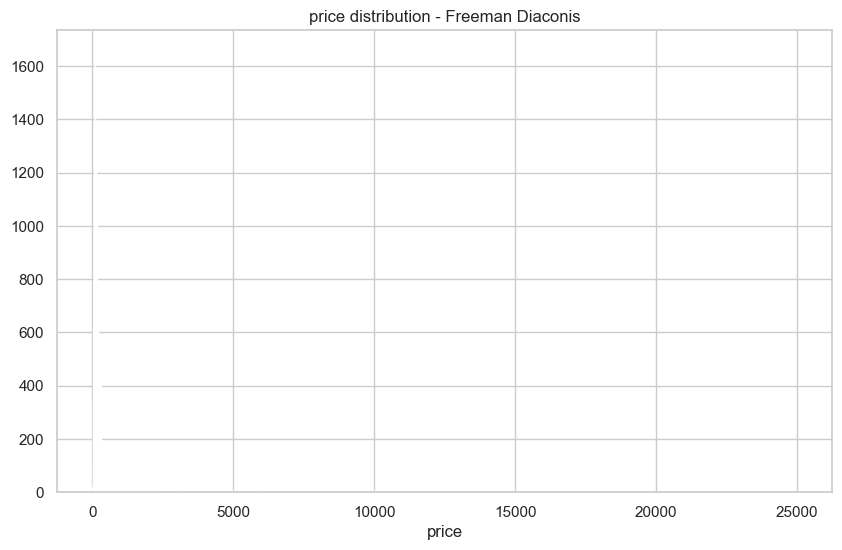

In [26]:
h = freeman_diaconis(all_listings.price)
plot_data = all_listings.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Yes - let's get rid of the 25000 listing and see if the histogram starts to make more sense

In [27]:
trimmed_listings = all_listings[all_listings.price < 1500]

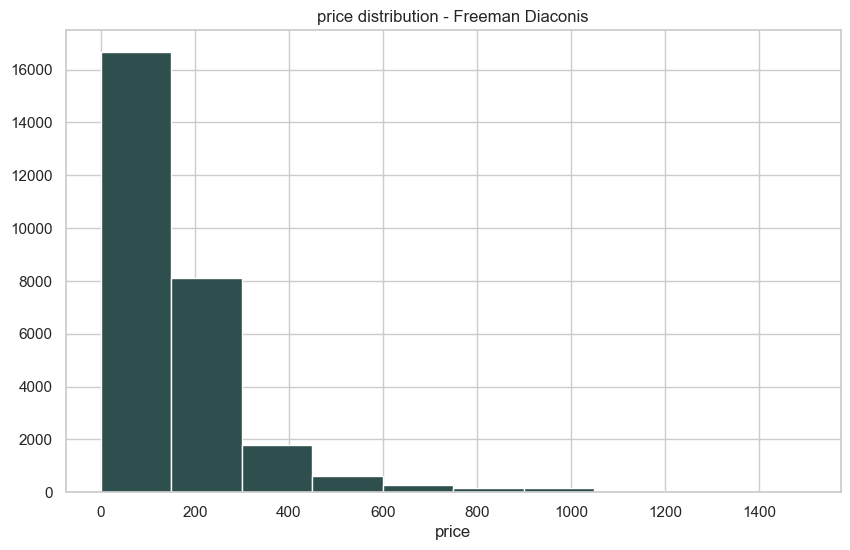

In [28]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Removing listings below 1500 reveals a distribution with a very strong skew to the right. The distribution appears to be almost exponential which would not make much sense given our domain knowledge. Let's use Freeman Diaconis bins and limit the listings from 0-500

Freeman Diaconis:  7


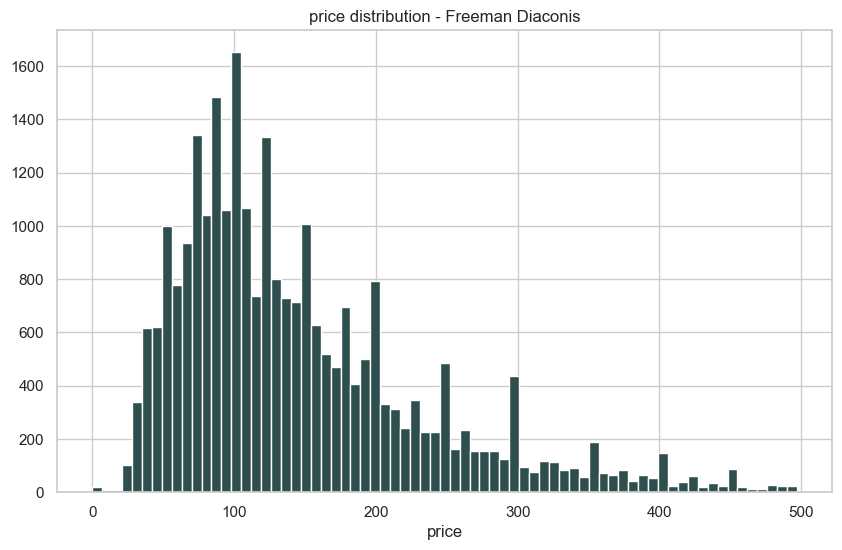

In [29]:
listings_below_500 = all_listings[all_listings.price < 500]

h = freeman_diaconis(listings_below_500.price)
plot_data = listings_below_500.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Looking at the above distribution, we see a that there is a strong skew to the right even when we remove all listings over 500 per night. This can be interpreted as the majority of AirBnBs having a nightly price that is between 85 and 200 per night but then increasingly expensive houses becomes less and less popular. 

Moving on to the single variable analysis of `neighborhoods`...

<a id="neighborhood"></a>
## Neighborhood

The neighborhood variable is the string name of the DMV neighborhood in which the AirBnB is located. The dataset description says that the AirBnBs in this dataset are all located within D.C. so we expect the neighborhood names to be all neighborhoods within the actual district. As for how many neighborhoods there will be, that depends on how granular the neighborhood boundaries are. It would make sense for AirBnB to default to some governmental agency to define the neighborhood boundaries because neighorhood boundaries are highly subjective and constantly changing in the colloquial sense. For that reason, I expect the number of neighborhoods to be somewhere between 20 and 40.

In [30]:
# read the result of an arbitrary SQL query to a Pandas DataFrame
neighborhoods = con.execute("SELECT * from neighborhoods").df()
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


In [31]:
print(neighborhoods.neighbourhood)

0                  Brightwood Park, Crestwood, Petworth
1                         Brookland, Brentwood, Langdon
2                            Capitol Hill, Lincoln Park
3       Capitol View, Marshall Heights, Benning Heights
4        Cathedral Heights, McLean Gardens, Glover Park
5     Cleveland Park, Woodley Park, Massachusetts Av...
6     Colonial Village, Shepherd Park, North Portal ...
7     Columbia Heights, Mt. Pleasant, Pleasant Plain...
8      Congress Heights, Bellevue, Washington Highlands
9     Deanwood, Burrville, Grant Park, Lincoln Heigh...
10                             Douglas, Shipley Terrace
11    Downtown, Chinatown, Penn Quarters, Mount Vern...
12           Dupont Circle, Connecticut Avenue/K Street
13                         Eastland Gardens, Kenilworth
14    Edgewood, Bloomingdale, Truxton Circle, Eckington
15    Fairfax Village, Naylor Gardens, Hillcrest, Su...
16    Friendship Heights, American University Park, ...
17                      Georgetown, Burleith/Hil

There are 38 total neighbrohoods in this dataset. They appear to encompass multiple colloquially-known neighborhoods given that their names almost all consist of multiple names combined in a comma-separated list. They appear in alphabetical order and the index on right right column of the above print-out will correspond to some labels I use below.

The `neighborhoods` table also includes a `polygon` shape of the neighborhood using lat/lon points. Let's map those:

In [32]:
!pip install geopandas

In [33]:
import geopandas as gpd
from shapely.geometry import Polygon

p_list = []
for p in neighborhoods.coordinates:
  p_list.append(Polygon(p))

neighborhoods_gpd = gpd.GeoDataFrame(neighborhoods, crs='epsg:4326', geometry=p_list)       

neighborhoods_gpd['rep_point'] = neighborhoods_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_gpd['rep_point'] = [coords[0] for coords in neighborhoods_gpd['rep_point']]

neighborhoods_gpd['alpha_index'] = list(range(1,len(neighborhoods_gpd.neighbourhood)+1))

neighborhoods_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood_group  0 non-null      object  
 1   neighbourhood        39 non-null     object  
 2   type_outer           39 non-null     object  
 3   feature_type         39 non-null     object  
 4   geometry_type        39 non-null     object  
 5   coordinates          39 non-null     object  
 6   geometry             39 non-null     geometry
 7   rep_point            39 non-null     object  
 8   alpha_index          39 non-null     int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 2.9+ KB


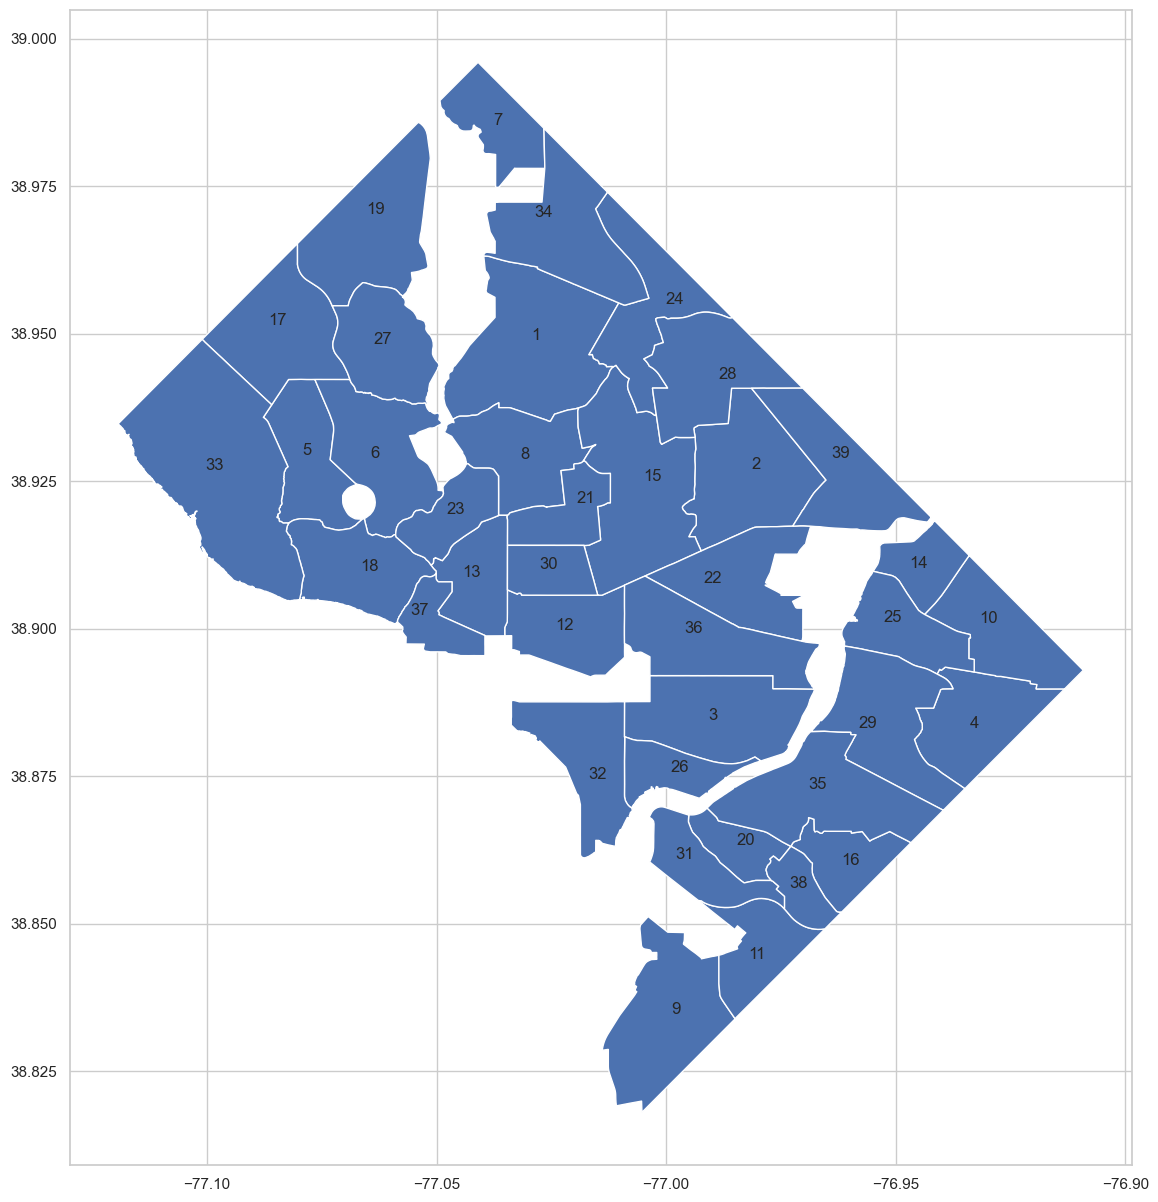

In [34]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

plt.show()

From the above map, we can see that all of these neighborhoods exist within the federal borders of the District of Columbia  (up until now, we were unsure if these neighborhoods bled into the surrounding DMV area). The polygons are of diverse shapes and sizes.  

The white spots in the map correspond to neighborhoods clusters that are not represented in the AirBnB dataset. These are:
* Observatory Circle (small white circle in the northwest quadrant). Houses the US Naval Observatory and the house of the US Vice President.
* Rock Creek Park (long thin cluster extending from the top of the diamond to cluster 23). A national park.
* Walter Reed (trapazoidal polygon missing between 7 and 34). A military hospital.
* Arboretum, Anacostia River (long, river-shaped polygon starting between 31 and 32 and ending between 14 and 39). A river and a federally run arboretum.
* National Mall, Potomac River (The polygon missing from the entire southwest quadrant of the diamond, spanning from 33 to 9 and taking the horizontal rectanglular chunk from between 12, 36, 3, and 32). The national mall of the US Capitol and a large river between DC and Virginia.
* Joint Base, Anacostia Boilings (the misisng polygon west of 9 bordering the Potomac and Anacostia). A Naval and Joint Armed Forces base.
* Saint Elizabeth's (the rectangular polygon missing between 31, 11, and 9). A hospital.

Source: https://opendata.dc.gov/datasets/neighborhood-clusters/explore?location=38.855725%2C-77.000257%2C11.77.

We now move on to single variable EDA on variables that deal with data about the *host* of the AirBnB.

In [35]:
latest_hosts_unique = latest_listings.drop_duplicates(subset='host_id')

## <a id="host_info">Host Information</a>

We want to investigate the relationship between neighborhoods and the booked price of airbnbs in their area. We will start with individual variable analysis of `price` and `neighborhoods` and then do a pairwise analyis. To start this, we will load the data from the `listings` table and the `neighborhoods` table into their own Pandas dataframes to make them easier to work with

We also want the relationship between `price` and data that relates to the host like
* `host_since`
* `host_location`
* `host_response_time`
* `host_response_rate`
* `host_acceptance_rate`
* `host_is_superhost`
* `host_listings_count`
* `host_verifications`
* `host_has_profile_pic`
* `host_identity_verified`


### `host_since` <a id="host_since"></a>

This variable corresponds to the date on which the host became an AirBnB host. It is saved as a Pandas `datetime`. We can use this data to understand how many day/months/years each person has been a host. AirBnB is only about 14 years old so we expect the maximum number of years someone has been a host to be less than 14. Between 0 and 14 I expect most people to have been hosts between 0 and 7 years and fewer between 7 and 14 which would cause a skew to the right.

In [36]:
import datetime

In [37]:
timestamp = pd.Timestamp(datetime.datetime(2021, 10, 10))
res = timestamp.today()
latest_hosts_unique.days_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'D')
latest_hosts_unique.years_host = (res - latest_hosts_unique.host_since) / np.timedelta64(1,'Y')
latest_hosts_unique.days_host

0        5128.895902
1        4384.895902
2        5112.895902
3        3880.895902
4        4258.895902
            ...     
10531     272.895902
10547    1650.895902
10549    1038.895902
10550    1565.895902
10554     335.895902
Name: host_since, Length: 5843, dtype: float64

In [38]:
latest_hosts_unique.days_host.describe()

count    5840.000000
mean     2513.735457
std       986.443234
min        93.895902
25%      2019.895902
50%      2588.895902
75%      3162.145902
max      5133.895902
Name: host_since, dtype: float64

In [39]:
latest_hosts_unique.years_host.describe()

count    5840.000000
mean        6.882374
std         2.700790
min         0.257078
25%         5.530287
50%         7.088156
75%         8.657661
max        14.056130
Name: host_since, dtype: float64

The minimum number of years is 0.23 years and the maximum is just over 14 which tracks. The mean is just under 7 years.

Freeman Diaconis:  0


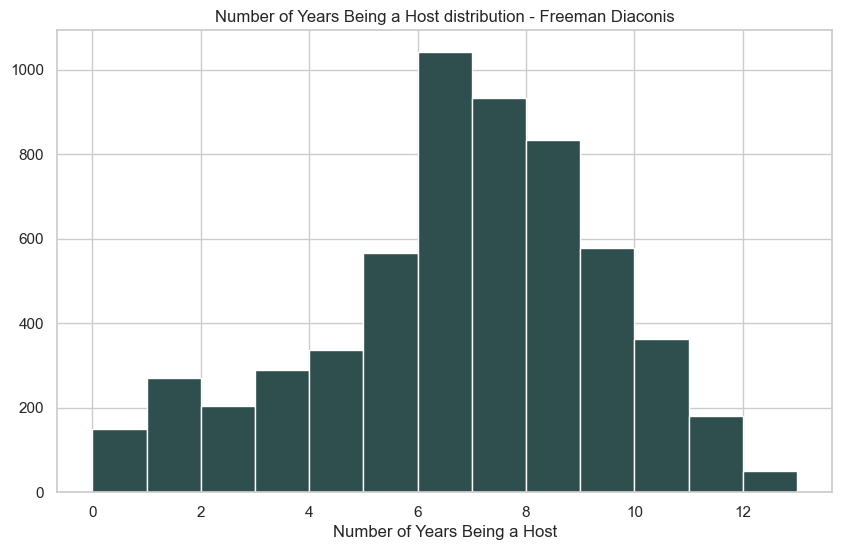

In [40]:
h = freeman_diaconis(latest_hosts_unique.years_host.dropna())
plot_data = latest_hosts_unique.years_host.dropna()
variable_name = "Number of Years Being a Host"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

This distribution is mostly symmetric with a slight skew to the left. The majority of the data is etween 6 and 9 years. Few hosts have been hosts for less than 4 years ore more than 10.5

### `host_location` <a id="host_location"></a>

This variable is a categorical string variable indicating where the host resides. I don't know if this data is self-reported or chosen from a selection. I would expect most hosts to live in D.C. because they own property within D.C.

In [41]:
latest_listings.host_location.value_counts(normalize=True)[:10]

Washington, DC                                     0.439045
Washington, District of Columbia, United States    0.227377
Houston, Texas, United States                      0.062631
US                                                 0.035714
New York, NY                                       0.031211
United States                                      0.012882
Arlington, VA                                      0.008065
Silver Spring, MD                                  0.007331
New York, New York, United States                  0.006075
Alexandria, Virginia, United States                0.005237
Name: host_location, dtype: float64

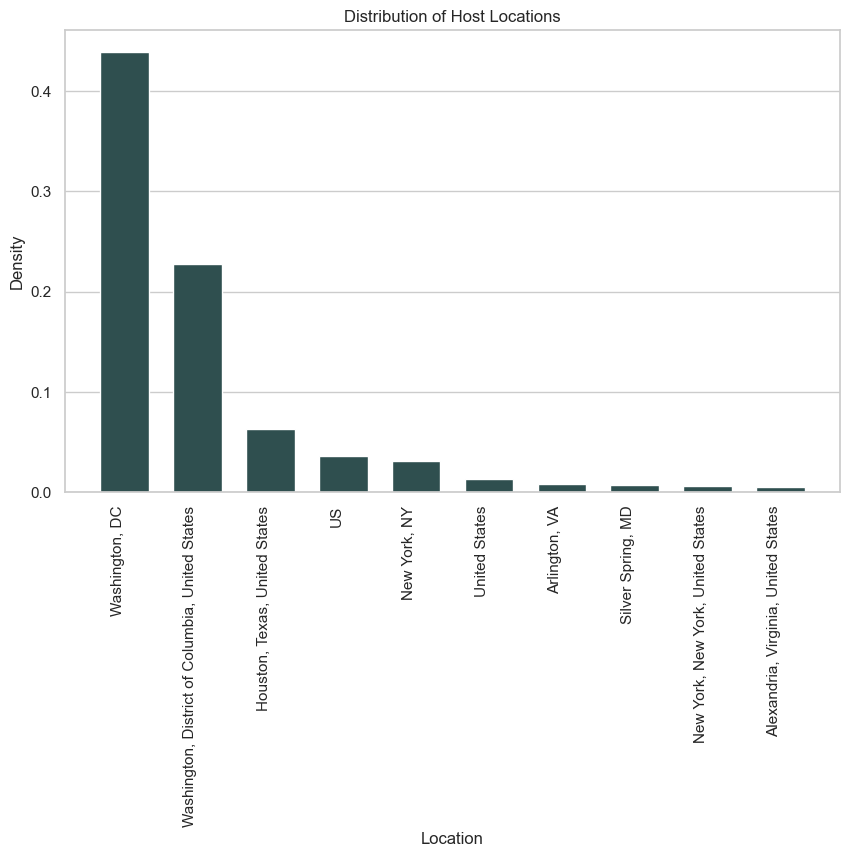

In [42]:
data = latest_listings.host_location.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_location.value_counts()[:10]).values()))))
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys())
axes.set_title( "Distribution of Host Locations")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_location.value_counts()[:10]).keys(), rotation=90, ha='right')
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

This data is not very useful. There are overlapping and redundant categories - namely there is bboth a "Washington, District of Columbia, United States" AND a "Washington, DC" category. There is also a "US" and "United States" category which *might* mean these people live in D.C. or might mean anywhere else within the United States.

Regardless, the majority of hosts live within DC.

### `host_response_time` <a id="host_response_time"></a>

Host response time is the AirBnB autogenerated cateogorical variable assigned to each host based on their response time to customer messages. These categories include things like "within an hour" or "within a couple of days". I expect most hosts to respond "within a day" or "within a few hours" because there is an advantage in getting customer to trust/like you if you respond faster. 

In [43]:
latest_listings.host_response_time.value_counts()

within an hour        5525
N/A                   2946
within a few hours    1078
within a day           657
a few days or more     192
Name: host_response_time, dtype: int64

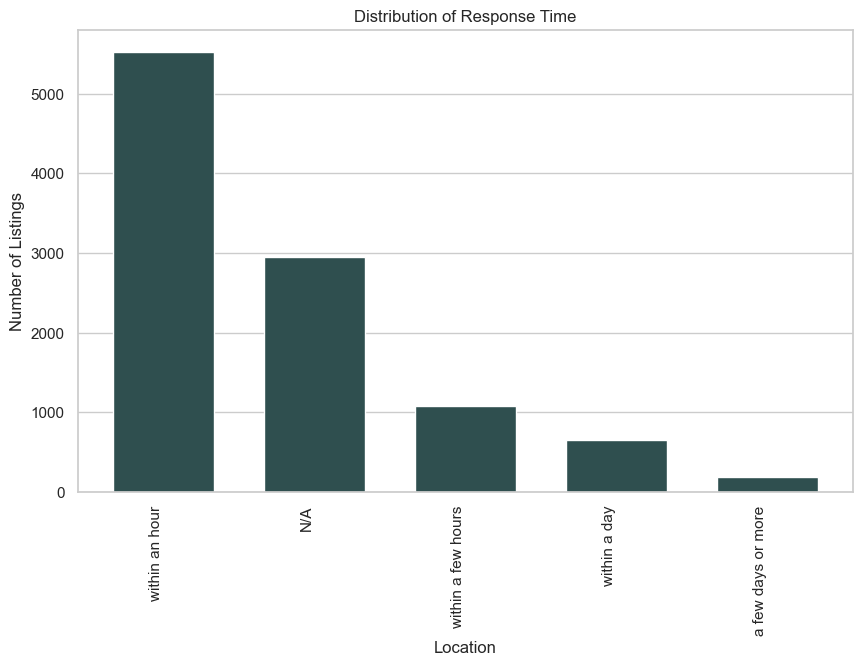

In [44]:
data = latest_listings.host_response_time.value_counts()
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_response_time.value_counts()).values()))))
axes.set_title( "Distribution of Response Time")
axes.set_xlabel("Location")
axes.set_xticklabels(dict(latest_listings.host_response_time.value_counts()).keys(), rotation=90, ha='right')
axes.set_ylabel( "Number of Listings")
axes.xaxis.grid(False)

plt.show()
plt.close()

There is a sizable portion of hosts within the "N/A" category. That aside, the clear majority of remaining hosts respond within the hour with subsequent categories having a decreasing frequency in order of length of time to respond.

### `host_response_rate` <a id="host_response_rate"></a>

Host response rate is the percentage of messages from customers that hosts respond to at all, regardless of time. This will be on a range of 0-100. I expect the mean number to be greater than 90% because hosts have an incentive to respond to every message from a potential customer in order to gain their business and current customers to maintain a high rating. 

In [45]:
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('N/A',np.NaN)
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('%', '', regex=True).astype(float)

In [46]:
latest_listings['host_response_rate'].describe()

count    7452.000000
mean       95.040794
std        15.631311
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

Freeman Diaconis:  0


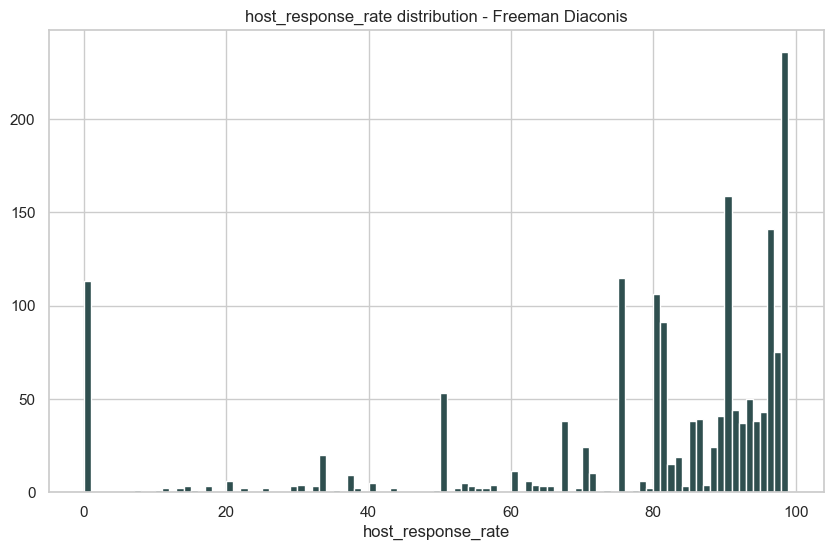

In [47]:
h = freeman_diaconis(latest_listings['host_response_rate'].dropna())
plot_data = latest_listings['host_response_rate'].dropna()
variable_name = "host_response_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

The distribution is clearly skewed to the right. Almost ll the data is etween 80 and 100%. There is another mode at 0% which is presumably from rows within `listings` that have null values and/or hosts that are completely inactive on the website but do still have accounts as hosts.

### `host_acceptance_rate` <a id="host_acceptance_rate"></a>

Host acceptance rate is the rate of customer bids that this host accepts from 0-100. I expect this number to be high (>80%) because hosts have a monetary incentive to accept as many guests as possible throughout the year. I don't expect the IQR to be 100% like the last variable because hosts cannot say yes to everyone - especially for high-demand properties.

In [48]:
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [49]:
latest_listings['host_acceptance_rate'].describe()

count    8120.000000
mean       85.751108
std        24.362805
min         0.000000
25%        85.000000
50%        97.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

The mean acceptance rate is 85%. The median is 97% indicating that, once again, the mean acceptance rate is being skewed by a handful of low outliers - likely hosts with a zero acceptance rate.

Freeman Diaconis:  1


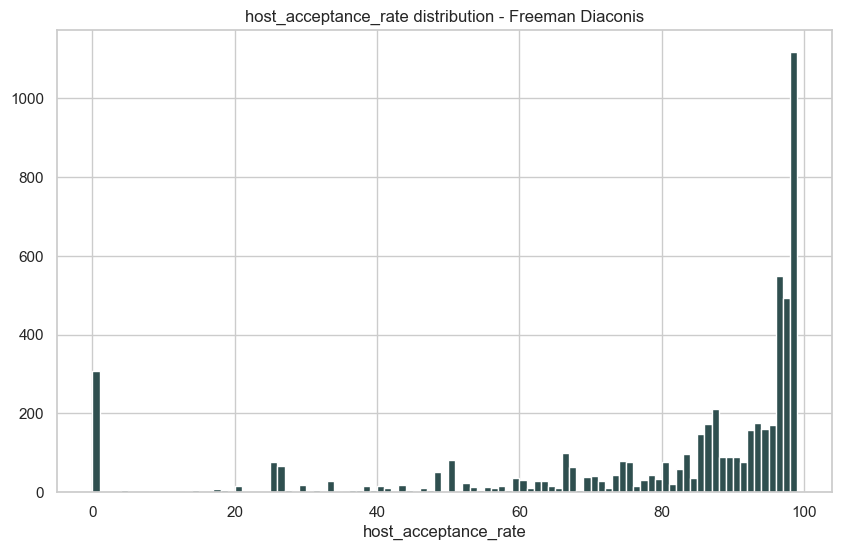

In [50]:
h = freeman_diaconis(latest_listings['host_acceptance_rate'].dropna())
plot_data = latest_listings['host_acceptance_rate'].dropna()
variable_name = "host_acceptance_rate"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

this distribution is highly skewed to the left once again. There are a handful of hosts with a 0% acceptance rate. This is likely from rows in `listings` that have all null values or from inactive hosts that still have desired property listings but never accept new guests.

### `host_is_superhost` <a id="host_is_superhost"></a>

This variable is a boolean variable indicating whether or not this host is a superhost. According to AirBnB, superhost status requires:
* Hostings at least 10 trips within the past year
* Having a response rate of at least 90%
* Having >80% of your trip ratings be 5 stars
* Not cancelling reserved reservations besides extenuating circumstances.

Based on past EDA and domain knowledge, these requirements are difficult to achieve. I expect there to be more non-superhosts than superhosts.

In [51]:
latest_listings.host_is_superhost.value_counts()

False    7950
True     2604
Name: host_is_superhost, dtype: int64

Only a quarter of hosts are superhosts.

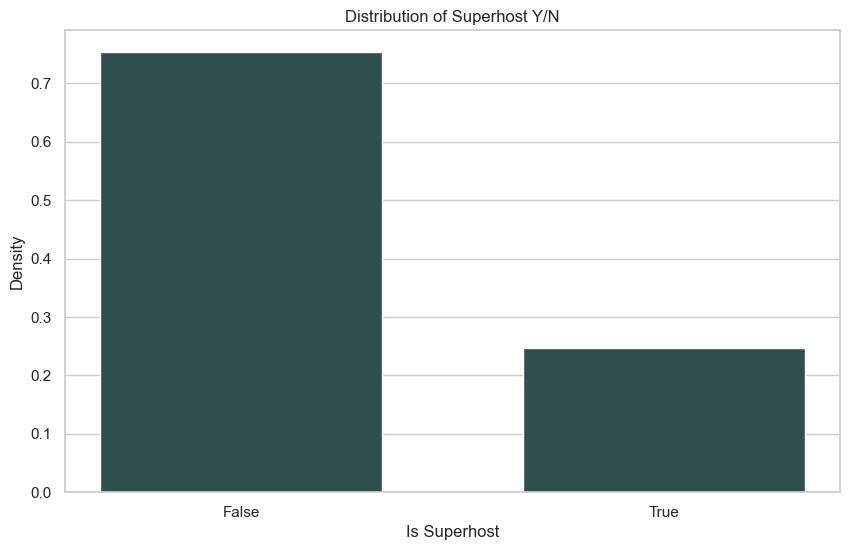

In [52]:
data = latest_listings.host_is_superhost.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_is_superhost.value_counts()).values()))))
axes.set_title( "Distribution of Superhost Y/N")
axes.set_xlabel("Is Superhost")
axes.set_xticklabels(dict(latest_listings.host_is_superhost.value_counts()).keys())
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

75% of hosts within the last quarter are not superhosts, whereas 25% of them are.

### `host_listings_count` <a id="host_listings_count"></a>

This variable counts the number of listings that this host has within AirBnB. I expect this number to range from 1 to 25 with most hosts only having between 1 and 3 properties. 

In [53]:
latest_listings['host_listings_count'].describe()

count    10398.000000
mean       165.797750
std        676.694138
min          0.000000
25%          1.000000
50%          2.000000
75%         10.000000
max       4057.000000
Name: host_listings_count, dtype: float64

There are a couple of clear outliers and/or impossibilities. There should not be any hosts in the AirBnB database with 0 listings. The maximum number being >4000 seems to be an extreme outlier given that the IQR is between 1 and 10 listings. The mean is being heavily skewed by these high outliers.

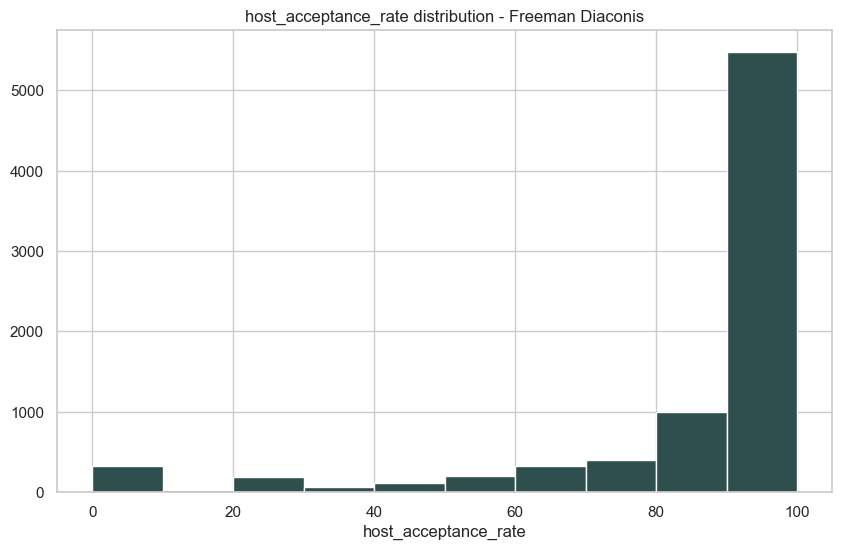

In [54]:
# h = freeman_diaconis(latest_listings['host_listings_count'].dropna())
# plot_data = latest_listings['host_listings_count'].dropna()
# variable_name = "host_listings_count"
# print("Freeman Diaconis: ", h)
# mn = int(plot_data.min())
# mx = int(plot_data.max())
# bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Clearly, most of the data is less than 500, and likely most of the data is less than 20. Let's chop off some of the very high values.

Freeman Diaconis:  0


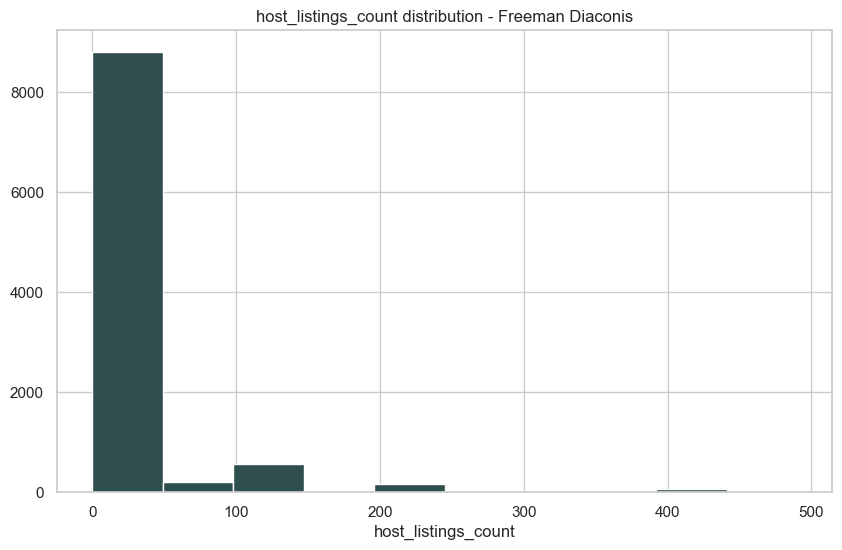

In [55]:
latest_listings.host_listings_count_under_500 = latest_listings.host_listings_count[latest_listings.host_listings_count < 500]
h = freeman_diaconis(latest_listings.host_listings_count_under_500.dropna())
plot_data = latest_listings.host_listings_count_under_500.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

There are a handful of hosts within the 50 to 250 range but clearly most of the data is less than 50.

Freeman Diaconis:  0


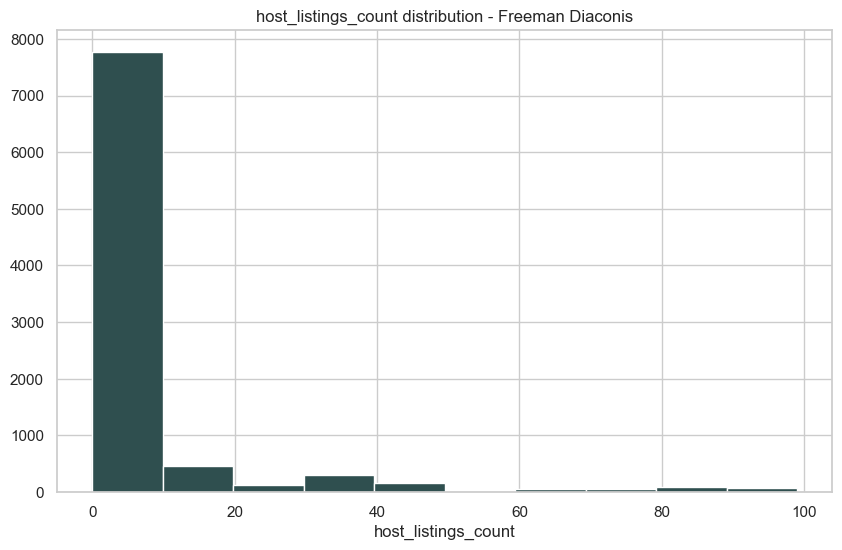

In [56]:
latest_listings.host_listings_count_under_100 = latest_listings.host_listings_count[latest_listings.host_listings_count < 100]
h = freeman_diaconis(latest_listings.host_listings_count_under_100.dropna())
plot_data = latest_listings.host_listings_count_under_100.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

More filtering...

Freeman Diaconis:  0


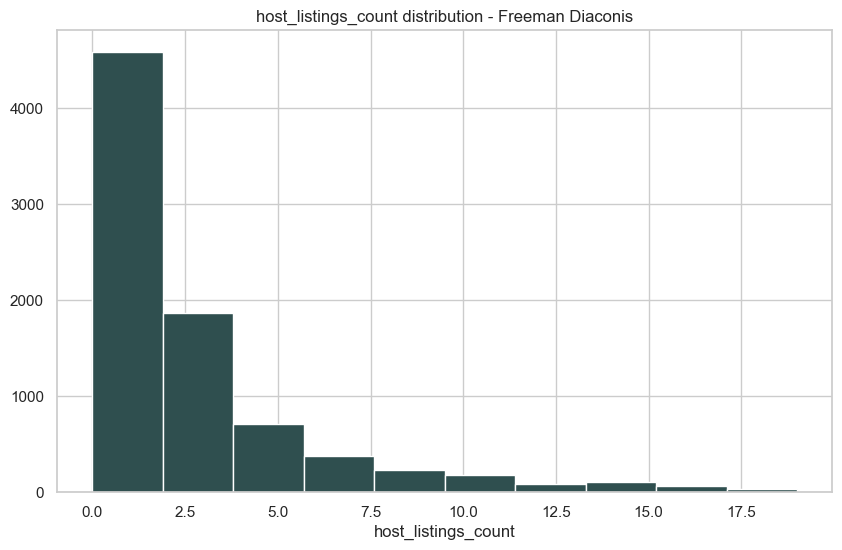

In [57]:
latest_listings.host_listings_count_under_20 = latest_listings.host_listings_count[latest_listings.host_listings_count < 20]
h = freeman_diaconis(latest_listings.host_listings_count_under_20.dropna())
plot_data = latest_listings.host_listings_count_under_20.dropna()
variable_name = "host_listings_count"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

When we look only at data between 0 and 20, we see that there is a clear exponential distribution of this variable. Most people have 1 listing. Some people have between 2 and 4. And then a handful of people have vetween 4 and 20 in a decreasing fashion.

### `host_verifications` <a id="host_verifications"></a>

This variable is a list of all the ways in which the host's identity has been verified. The popular avenues include things like "email" and "phone" via verification code but hosts also have the option of verifying via government IDs or any combination of things.

Because this variable is a list, I expect there to be hundres if not thousands of unique host_verification values. I expect "email" and "phone" to be the main avenues of verification because of its ease.

In [58]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

There were too many unique host_verification values to display so I displayed the 10 most common ones. ['email', 'phone'] were the most common at 55%. The second most common was just ['phone']. After that, no combination of host_verification (though all including 'email' and 'phone' except for None) make up more than ~5% of the hosts.

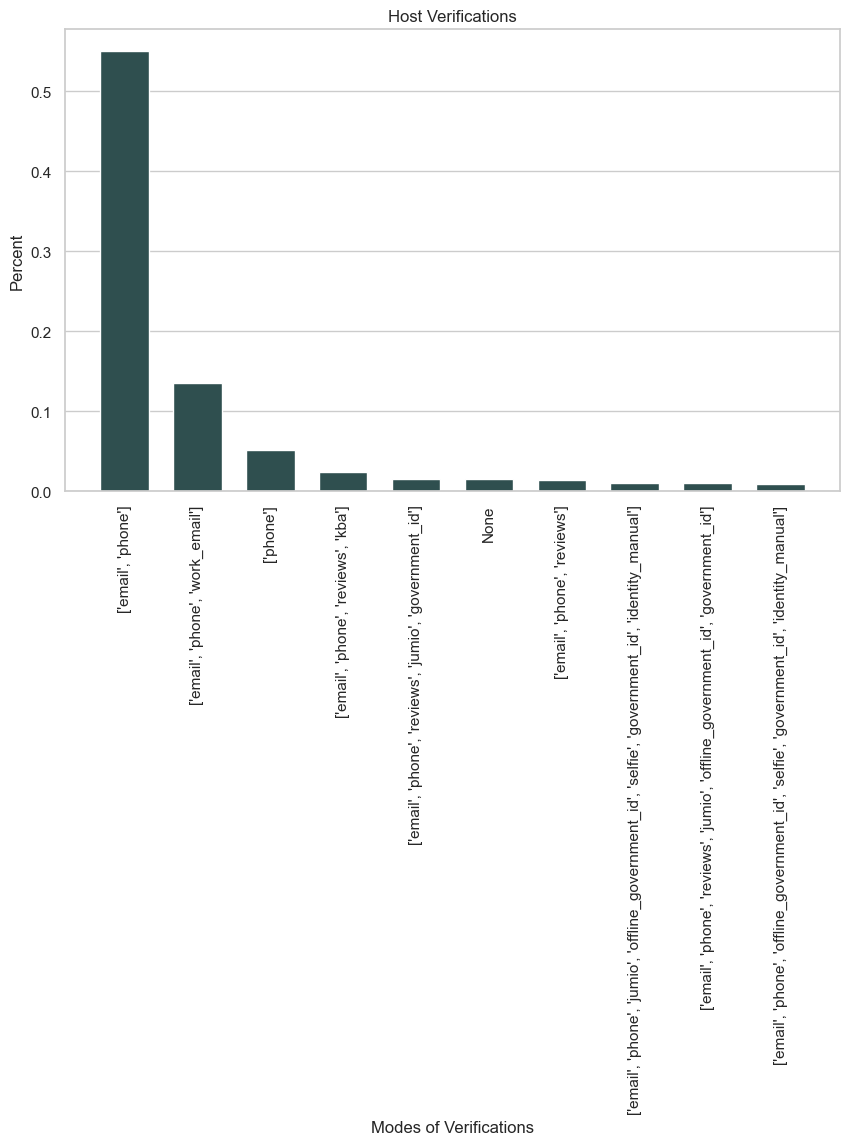

In [59]:
data = latest_listings.host_verifications.value_counts(normalize=True)[:10]
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).values()))))
axes.set_title( "Host Verifications")
axes.set_xlabel("Modes of Verifications")
axes.set_xticklabels(dict(latest_listings.host_verifications.value_counts(normalize=True)[:10]).keys(),rotation=90)
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

This chart shows the clear majority of host_verification being both email and phone.

### `host_has_profile_pic` <a id="host_has_profile_pic"></a>

This is a boolean variable indicating whether or not the host has a profile picture. According to AirBnB, all hosts are required to have a profile picture so I expect this variable to be almost 100% yes. Although there are null values in this dataset or junk rows that may present as "no"s.

In [60]:
latest_listings.host_has_profile_pic.value_counts()

True     10325
False       73
Name: host_has_profile_pic, dtype: int64

As expected, almost all hosts have a profile picture.

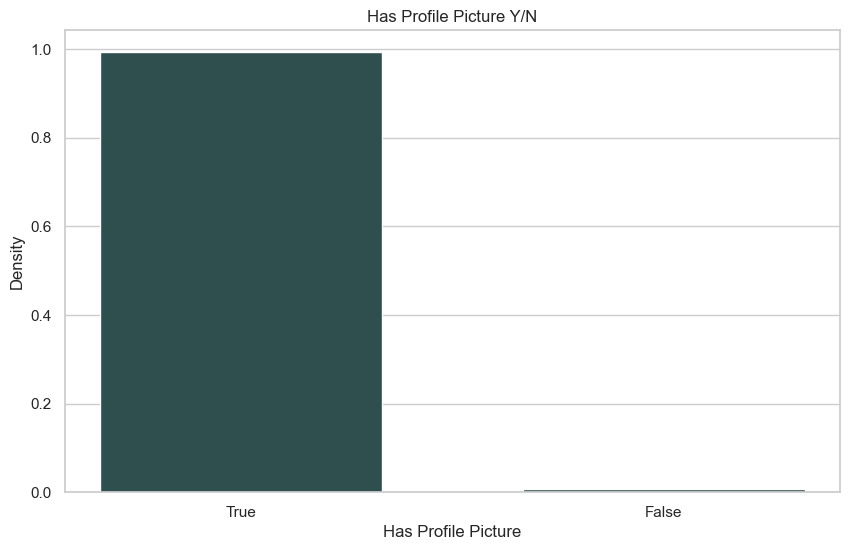

In [61]:
data = latest_listings.host_has_profile_pic.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_has_profile_pic.value_counts()).values()))))
axes.set_title( "Has Profile Picture Y/N")
axes.set_xlabel("Has Profile Picture")
axes.set_xticklabels(dict(latest_listings.host_has_profile_pic.value_counts()).keys())
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

Almost 100% of hosts have a profile picture and only 73 do not.

### `host_identity_verified` <a id="host_identity_verified"></a>

This variable is another boolean indicating whether the host's identity has been verified. AirBnB's process for host identification involves hosts providing their name, date of birth, or government ID. 

I would expect a clear majority of hosts to have their identity verified because they have an incentive to build trust with potential customers because that would ostensibly make customers more likely to book a listing with them.

In [62]:
latest_listings.host_identity_verified.value_counts()

True     8675
False    1723
Name: host_identity_verified, dtype: int64

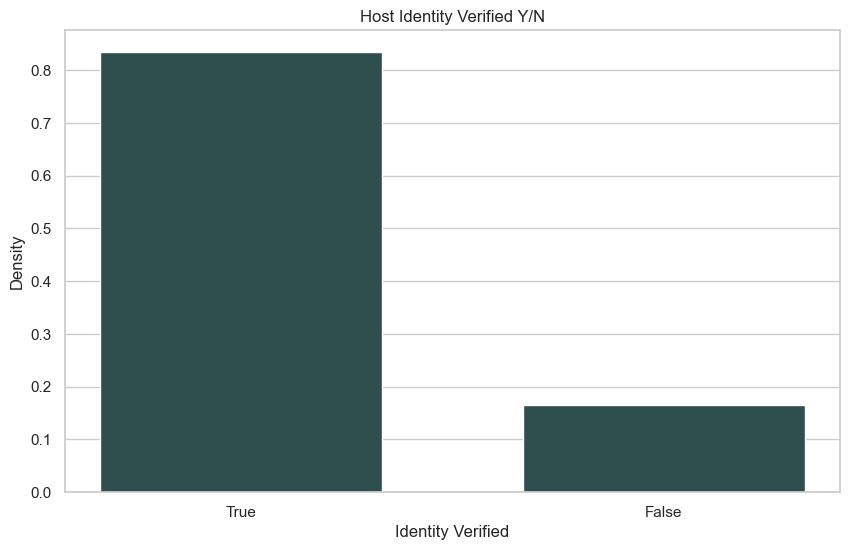

In [63]:
data = latest_listings.host_identity_verified.value_counts(normalize=True)
x = range( len(data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks(list(range(len(dict(latest_listings.host_identity_verified.value_counts()).values()))))
axes.set_title( "Host Identity Verified Y/N")
axes.set_xlabel("Identity Verified")
axes.set_xticklabels(dict(latest_listings.host_identity_verified.value_counts()).keys())
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

Almost 85% of hosts have had their identity verified and just over 15% of hosts have not - as expected.

## <a id="Rental_Info">Rental Information</a>
The following room descriptors give information about the rental property. How many rooms, bathrooms, and beds does it have? How many people can it accomodate? All things being equal, the more of these will mean a higher price to rent. 

* property_type - text
* room_type - text - currently in shared listings
* accomodates - integer
* bathrooms - text  (problem-- this is showing up as blanks)- __omitted__
* bathrooms_text - text __omitted__
* bedrooms - integer
* beds- integer
* amenities - list in []- This could be expanded to individual columns


Target Variable
* price


For the following exploration, we will use the latest_listings table, which includes only one of each listing, taking the most recent data if there were duplicates in the data set.

First, we'll bring in the amenities information and look at it from a high level

In [64]:
con.execute("select property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price from latest_listings;")
listings = con.fetchall()
room_columns = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price']
listings_df = pd.DataFrame(listings, columns=room_columns)
listings_df.head()

property_type        room_type  accommodates bathrooms  \
0         Private room in home     Private room             1      None   
1  Private room in rental unit     Private room             1      None   
2    Private room in townhouse     Private room             3      None   
3                 Entire condo  Entire home/apt             2      None   
4  Private room in guest suite     Private room             3      None   

   bathrooms_text  bedrooms  beds  \
0  1 private bath       1.0   1.0   
1  2 shared baths       1.0   1.0   
2  1 private bath       1.0   2.0   
3       1.5 baths       1.0   1.0   
4  1 private bath       1.0   2.0   

                                           amenities  price  
0  ["Dryer", "Smoke alarm", "Cooking basics", "In...   67.0  
1  ["Smoke alarm", "Cooking basics", "Bed linens"...   39.0  
2  ["Dryer", "Smoke alarm", "Single level home", ...   75.0  
3  ["Dryer", "TV with standard cable", "Cooking b...  250.0  
4  ["Dryer", "Smoke alarm", "Paid parking on prem...  113.0

In [65]:
trimmed_listings = listings_df[listings_df.price > 0]

### <a id="property_type">Property_Type </a>
First, we'll look at what this column describes.


Queries:
* select distinct room_type, property_type from listings order by room_type;  
* select count(property_type), property_type from listings group by property_type;  
* select distinct property_type from listings;  


In [66]:
listings_df.property_type.describe()

count                  10560
unique                    61
top       Entire rental unit
freq                    3488
Name: property_type, dtype: object

There are 61 distinct values for this column, with the most frequent item being "Entire rental unit."

Next, we'll look at the distribution of each category. Since there are 61 of these, we'll rely on a table to parse the info.

In [67]:
con.execute("select property_type, count(property_type) as prop_count from latest_listings group by property_type order by prop_count desc;")
distinct_property_types = con.fetchall()
print(tabulate(distinct_property_types, headers=['Property Type', 'Count'], tablefmt='fancy_grid'))

╒═════════════════════════════════════╤═════════╕
│ Property Type                       │   Count │
╞═════════════════════════════════════╪═════════╡
│ Entire rental unit                  │    3488 │
├─────────────────────────────────────┼─────────┤
│ Entire serviced apartment           │     889 │
├─────────────────────────────────────┼─────────┤
│ Entire townhouse                    │     811 │
├─────────────────────────────────────┼─────────┤
│ Entire home                         │     739 │
├─────────────────────────────────────┼─────────┤
│ Entire guest suite                  │     632 │
├─────────────────────────────────────┼─────────┤
│ Private room in home                │     606 │
├─────────────────────────────────────┼─────────┤
│ Entire condo                        │     595 │
├─────────────────────────────────────┼─────────┤
│ Private room in townhouse           │     522 │
├─────────────────────────────────────┼─────────┤
│ Private room in rental unit         │     449 │


The most frequent property types include "entire" in the description, initially indicating that you would have the unit to yourself.

This is a category for the listing that indicates:
1) Is this an apartment, condo, townhome, house, guesthouse, vacation home, etc?
2) Which part of category 1 does the renter get to themselves?

It should be separated into two descriptors if possible. Part 2 is covered by Room_Type below.


### <a id='room_type'>Room_Type</a>
The property type above seemed to include the "Room type". We'll see what it actually means:


In [68]:
con.execute("select distinct room_type from latest_listings;")
distrinct_room_types = con.fetchall()
distrinct_room_types

[('Private room',), ('Entire home/apt',), ('Shared room',), ('Hotel room',)]

This is a nice categorical in that there are few options:
* Entire home/apt
* Private room
* Shared room
* Hotel room

This covers part 2 of the "property type" above. 

Let's see the relationship between property_type and room_type

In [69]:
con.execute("select distinct room_type, property_type, count(property_type) as counts from latest_listings group by room_type, property_type order by room_type, counts desc;")
roomtype_proptype_counts = con.fetchall()
roomtype_proptype_counts_df = pd.DataFrame(roomtype_proptype_counts, columns=['room_type', 'property_type', 'property_type_counts'])

print(tabulate(roomtype_proptype_counts, headers=['room_type', 'property_type', 'counts'], tablefmt='pretty'))

+-----------------+-------------------------------------+--------+
|    room_type    |            property_type            | counts |
+-----------------+-------------------------------------+--------+
| Entire home/apt |         Entire rental unit          |  3488  |
| Entire home/apt |      Entire serviced apartment      |  889   |
| Entire home/apt |          Entire townhouse           |  811   |
| Entire home/apt |             Entire home             |  739   |
| Entire home/apt |         Entire guest suite          |  632   |
| Entire home/apt |            Entire condo             |  595   |
| Entire home/apt |       Entire residential home       |  307   |
| Entire home/apt |     Entire condominium (condo)      |  300   |
| Entire home/apt |          Entire guesthouse          |   83   |
| Entire home/apt |             Entire loft             |   51   |
| Entire home/apt |        Entire vacation home         |   17   |
| Entire home/apt |         Room in aparthotel          |   16

Each of the property types maps to a room type, and it looks like most of the listings in the Washington DC area are for Entire homes/apartments.

We'll plot the counts for each of these four types below:

Entire home/apt    7975
Private room       2399
Shared room         158
Hotel room           28
Name: room_type, dtype: int64


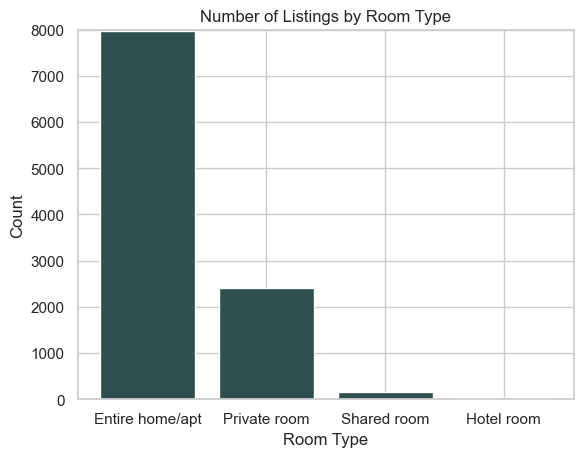

In [70]:
room_type_list = listings_df['room_type'].unique()
room_type_list

room_type_count = listings_df['room_type'].sort_index().value_counts()
print(room_type_count)

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.bar(room_type_count.index, room_type_count, color=THEME)
ax1.set_xlabel("Room Type")
ax1.set_ylabel("Count")
ax1.set_title("Number of Listings by Room Type")
ax1.set_ylim(0,8000)
ax1.yaxis.grid( visible=True, which="major")
ax1.set_axisbelow(True)


Of the ~10,500 listings, almost 8000 were 'Entire home/apt', followed by 'Private room', then very few for 'Shared room' and 'Hotel room'.

### <a id="accomodates">Accomodates</a>

This describes the maximum capacity for the unit.

First, we'll look at the distribution.


+-------------+-----------------+
| Accomodates | Num of Listings |
+-------------+-----------------+
|      0      |        5        |
|      1      |      1007       |
|      2      |      3319       |
|      3      |      1487       |
|      4      |      2262       |
|      5      |       721       |
|      6      |       899       |
|      7      |       163       |
|      8      |       348       |
|      9      |       39        |
|     10      |       129       |
|     11      |       16        |
|     12      |       81        |
|     13      |       12        |
|     14      |       16        |
|     15      |        7        |
|     16      |       49        |
+-------------+-----------------+


Text(0.5, 1.0, 'Accomodates distribution')

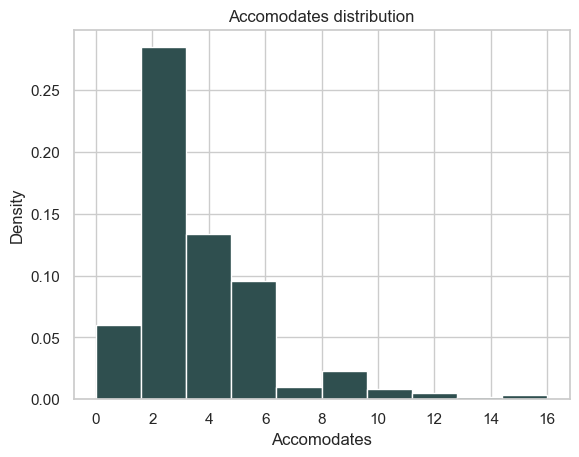

In [71]:
accommodates_count = listings_df['accommodates'].value_counts().sort_index()
accommodates_count = pd.DataFrame(accommodates_count)
print(tabulate(accommodates_count, headers=['Accomodates', 'Num of Listings'], tablefmt='pretty'))


figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['accommodates'],density=True, color=THEME)
ax1.set_xlabel('Accomodates')
ax1.set_ylabel('Density')
ax1.set_title('Accomodates distribution')

More than a quarter of the listings are from the two to four range. There's an oddity where the a property accommodates 0.

In [72]:
listings_df[listings_df.accommodates == 0]

property_type   room_type  accommodates bathrooms  \
3155          Room in hostel  Hotel room             0      None   
3273          Room in hostel  Hotel room             0      None   
3589  Room in boutique hotel  Hotel room             0      None   
6651  Room in boutique hotel  Hotel room             0      None   
9869  Room in boutique hotel  Hotel room             0      None   

     bathrooms_text  bedrooms  beds  \
3155           None       NaN   NaN   
3273           None       NaN   NaN   
3589           None       NaN   NaN   
6651           None       NaN   NaN   
9869           None       NaN   NaN   

                                              amenities  price  
3155  ["Long term stays allowed", "Smoke alarm", "Fi...    0.0  
3273  ["Long term stays allowed", "Dryer", "Luggage ...    0.0  
3589  ["43\" HDTV with Chromecast", "Long term stays...    0.0  
6651  ["Cooked-to-order breakfast available \u2014 $...    0.0  
9869  ["Heating", "Concierge", "Toiletries", "Fire e...    0.0

Looking at these listings, if accommodates is zero, there is no further information about the listing- The number of bathrooms, bedrooms, and beds are all blank, and the price is 0. This is unreliable, and cannot be used in prediction.

This condition can be used to filter out data that cannot be used in a model.

### <a id='bedrooms'>Bedrooms</a>
This is the number of bedrooms available to the renter, and is a numerical value.


+----------+-----------------+
| Bedrooms | Num of Listings |
+----------+-----------------+
|   1.0    |      6225       |
|   2.0    |      2089       |
|   3.0    |       822       |
|   4.0    |       324       |
|   5.0    |       90        |
|   6.0    |       34        |
|   7.0    |       10        |
|   8.0    |        1        |
|   9.0    |        3        |
|   11.0   |        1        |
|   15.0   |        1        |
+----------+-----------------+


Text(0.5, 1.0, 'Bedrooms distribution')

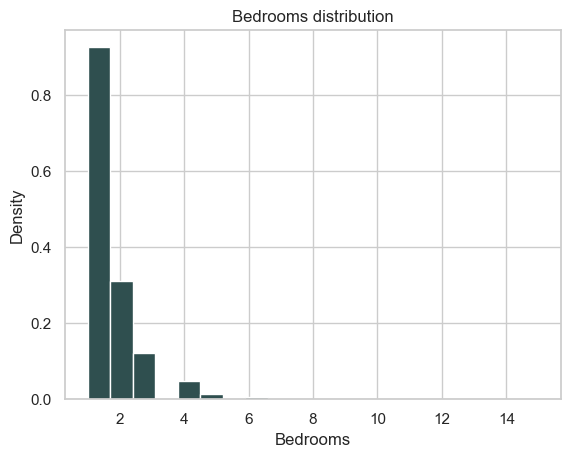

In [73]:
item_count = listings_df['bedrooms'].value_counts().sort_index()
item_count = pd.DataFrame(item_count)
print(tabulate(item_count, headers=['Bedrooms', 'Num of Listings'], tablefmt='pretty'))

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['bedrooms'],density=True, bins=20, color=THEME)
ax1.set_xlabel('Bedrooms')
ax1.set_ylabel('Density')
ax1.set_title('Bedrooms distribution')

Roughly 80% of the listings are for 1-2 bedrooms.

### <a id='beds'>Beds</a>
This is the number of beds available to the renter, and is a numerical value.


+------+-----------------+
| beds | Num of Listings |
+------+-----------------+
| 1.0  |      5177       |
| 2.0  |      2953       |
| 3.0  |      1124       |
| 4.0  |       512       |
| 5.0  |       245       |
| 6.0  |       148       |
| 7.0  |       48        |
| 8.0  |       38        |
| 9.0  |       16        |
| 10.0 |        9        |
| 11.0 |        6        |
| 12.0 |       10        |
| 16.0 |        2        |
| 18.0 |        1        |
| 20.0 |        1        |
| 50.0 |        1        |
+------+-----------------+


Text(0.5, 1.0, 'Beds distribution')

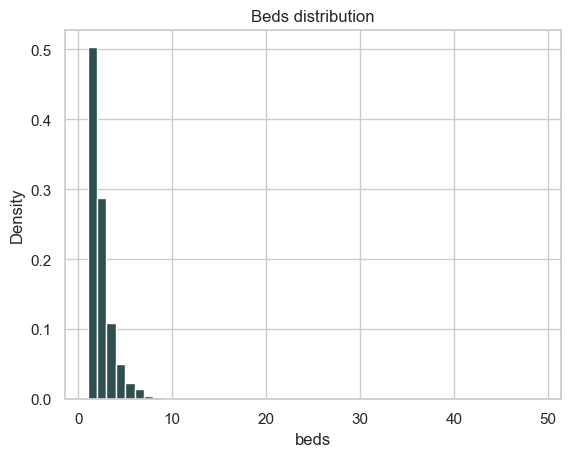

In [74]:
item_count = listings_df['beds'].value_counts().sort_index()
item_count = pd.DataFrame(item_count)
print(tabulate(item_count, headers=['beds', 'Num of Listings'], tablefmt='pretty'))

figure = plt.figure()
ax1 = figure.add_subplot(1,1,1)
ax1.hist(listings_df['beds'],density=True, bins=range(1,50,1), color=THEME)
ax1.set_xlabel('beds')
ax1.set_ylabel('Density')
ax1.set_title('Beds distribution')

The vast majority are for 1-2 beds, with a surprising maximum at 50.

### <a id='amenities'>Amenities</a>
This is a list of text items in a column, and could be expanded into individual columns with additional time.

The items seem fairly consistent.

In [75]:
listings_df.amenities.head()

0    ["Dryer", "Smoke alarm", "Cooking basics", "In...
1    ["Smoke alarm", "Cooking basics", "Bed linens"...
2    ["Dryer", "Smoke alarm", "Single level home", ...
3    ["Dryer", "TV with standard cable", "Cooking b...
4    ["Dryer", "Smoke alarm", "Paid parking on prem...
Name: amenities, dtype: object

## <a id='reviews'>Review Scores</a>

We want to investigate the reviews to price of airbnbs. For reviews we have many different factors that a guest can rate a host on. There is the overall review score and other sub-scores. The assumption is that a higher review score means the host can charge a higher price.

The variables we are interested in from the all listings table are reviews.
* review_scores_rating
* review_scores_accuracy
* review_scores_cleanliness
* review_scores_checkin
* review_scores_communication
* review_scores_location
* review_scores_value
* number_of_reviews
* number_of_reviews_ltm
* number_of_reviews_l30d
* reviews_per_month

### review_scores_rating

The data dictionary does not list the details on this variable. We'll have to explore what it might be and figure it our from there.

In [76]:
latest_listings.review_scores_rating.describe()

count    7740.000000
mean        4.680700
std         0.636749
min         0.000000
25%         4.660000
50%         4.850000
75%         4.970000
max         5.000000
Name: review_scores_rating, dtype: float64

There are 21844 review score listings so some of our listings don't have a review score listed. That is interesting. We may have to cull those null rows from our data to match the sizes of price and review scores. Most of the reviews are 4s with a few differences .637 std.

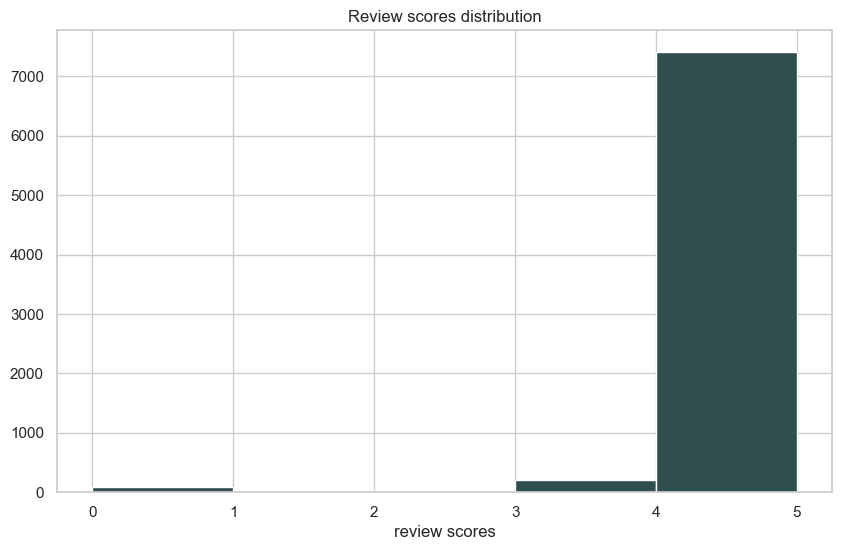

In [77]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_rating,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

We have a few zeros but mostly 4's and 5's. Not all that interesting. 

### review_scores_accuracy

There is no entry for this in the data dictionary but I think it is basically the review score that measures how accurate the description of the listing was to the actual property that the guest was staying in. This is actually fairly important because it alerts someone if you are being shown fake images of a listing that is actually not the same as the one you are staying in.

In [78]:
latest_listings.review_scores_accuracy.describe()

count    7656.000000
mean        4.792516
std         0.397878
min         0.000000
25%         4.760000
50%         4.910000
75%         5.000000
max         5.000000
Name: review_scores_accuracy, dtype: float64

First thing I notice is the number of reviews is different for this one as well with only 21649 compared to 28000+ listings. It's also lower than our previous variable scores_rating. It's basically the same distribution of scores, mostly high 4s and 5s. 

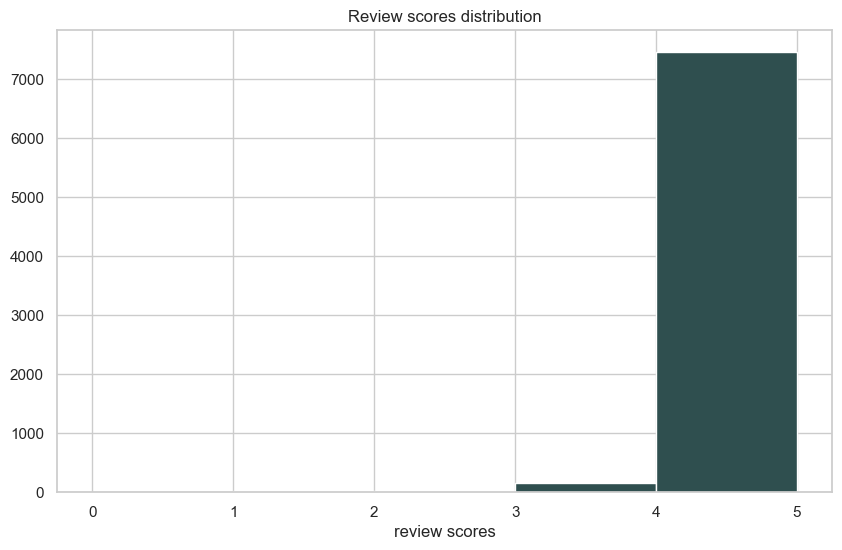

In [79]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_accuracy,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

### review_scores_cleanliness

There is no entry for this in the data dictionary but I think it is basically the review score that measures how clean the property was when the guest stayed there.

In [80]:
latest_listings.review_scores_cleanliness.describe()

count    7657.000000
mean        4.734177
std         0.420437
min         0.000000
25%         4.670000
50%         4.870000
75%         5.000000
max         5.000000
Name: review_scores_cleanliness, dtype: float64

Again there is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

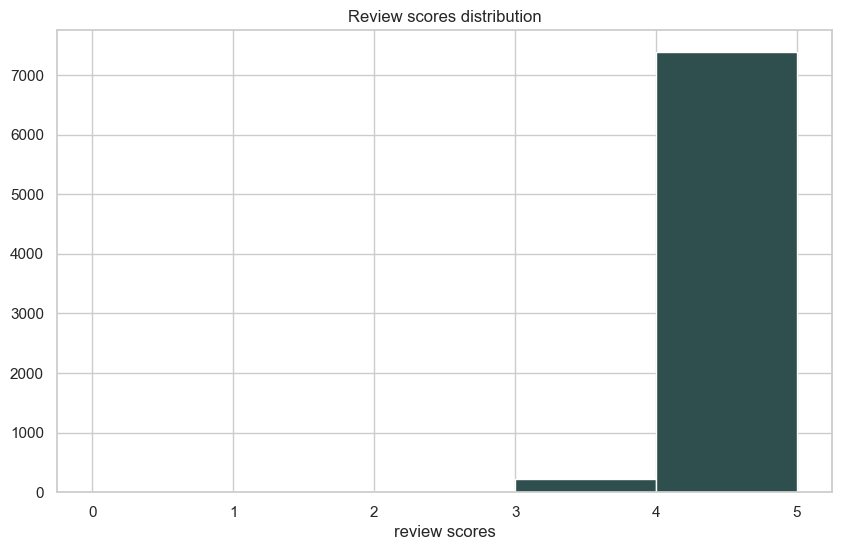

In [81]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_cleanliness,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

### review_scores_checkin

There is no entry for this in the data dictionary but I think it is basically the review score that measures how easy and simple the check in process was for the property.

In [82]:
latest_listings.review_scores_checkin.describe()

count    7654.000000
mean        4.849888
std         0.359567
min         0.000000
25%         4.860000
50%         4.960000
75%         5.000000
max         5.000000
Name: review_scores_checkin, dtype: float64

Again there is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

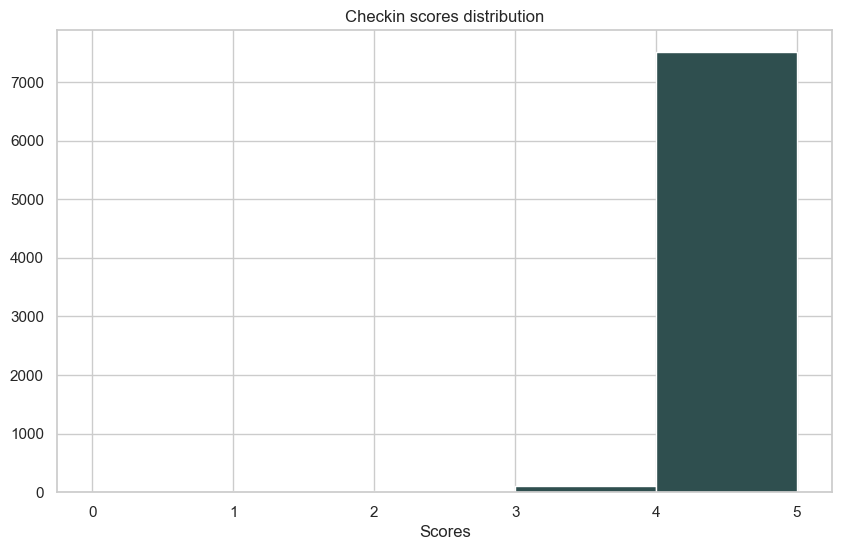

In [83]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_checkin,bins=5, color="darkslategray")
axes.set_title("Checkin scores distribution")
axes.set_xlabel("Scores")

plt.show()
plt.close()

### review_scores_communication

There is no entry for this in the data dictionary but I think it is basically the review score that measures how communicative the host was during the whole stay, from responding to questions pre-checkin and any thing else during the stay at the property.

In [84]:
latest_listings.review_scores_communication.describe()

count    7657.000000
mean        4.838004
std         0.378617
min         0.000000
25%         4.840000
50%         4.960000
75%         5.000000
max         5.000000
Name: review_scores_communication, dtype: float64

Again there is a different number of total reviews, but this one matches with the number who left a review for cleaning. It's basically the same distribution of scores, mostly high 4s and 5s.

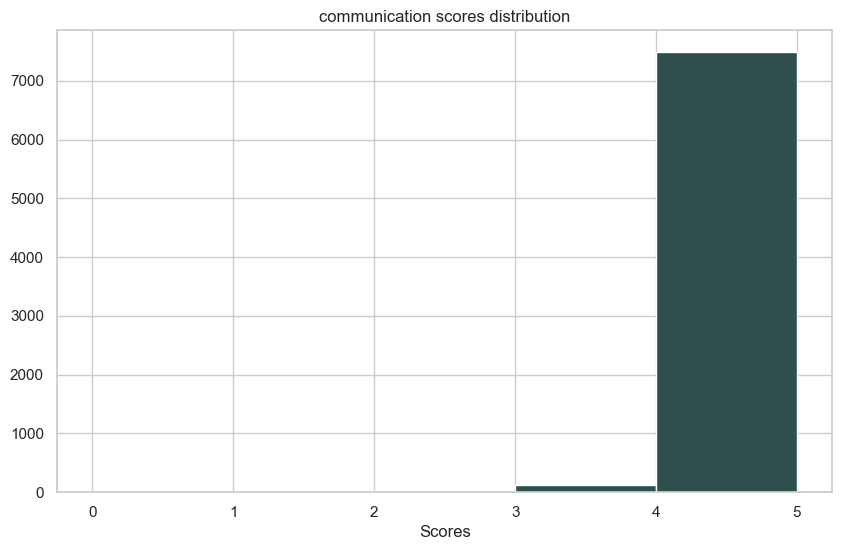

In [85]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_communication,bins=5, color="darkslategray")
axes.set_title("communication scores distribution")
axes.set_xlabel("Scores")

plt.show()
plt.close()

### review_scores_location

There is no entry for this in the data dictionary but I think it is basically the review score that measures the location and neighborhood the listing is in. This could be useful for our crime data comparison. 

In [86]:
latest_listings.review_scores_location.describe()

count    7655.000000
mean        4.780760
std         0.372359
min         0.000000
25%         4.715000
50%         4.900000
75%         5.000000
max         5.000000
Name: review_scores_location, dtype: float64

There is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

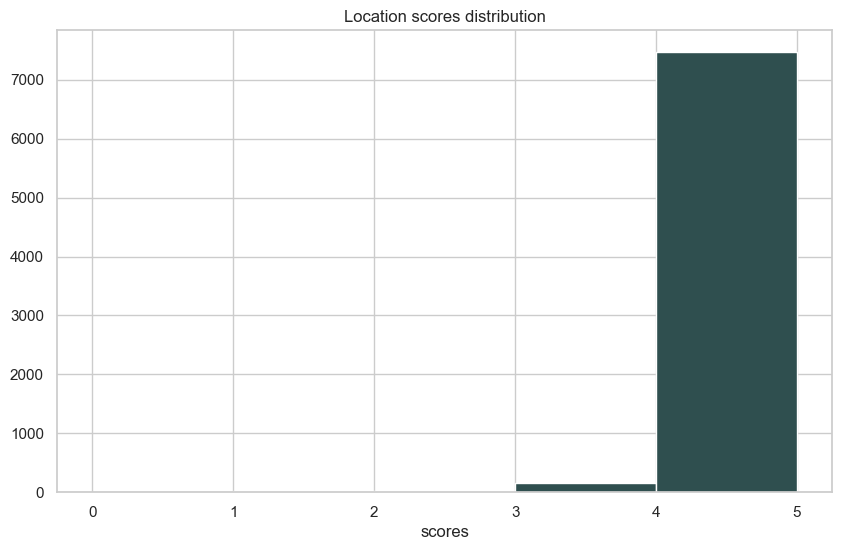

In [87]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_location,bins=5, color="darkslategray")
axes.set_title("Location scores distribution")
axes.set_xlabel("scores")

plt.show()
plt.close()

### review_scores_value

There is no entry for this in the data dictionary but I think it is basically the review score that measures the "bang for you buck" metric. Such as how affordable the space was, did the price per night match up well with the amenities and other things offered by the host.

In [88]:
latest_listings.review_scores_value.describe()

count    7652.000000
mean        4.697402
std         0.427266
min         0.000000
25%         4.640000
50%         4.800000
75%         4.920000
max         5.000000
Name: review_scores_value, dtype: float64

There is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

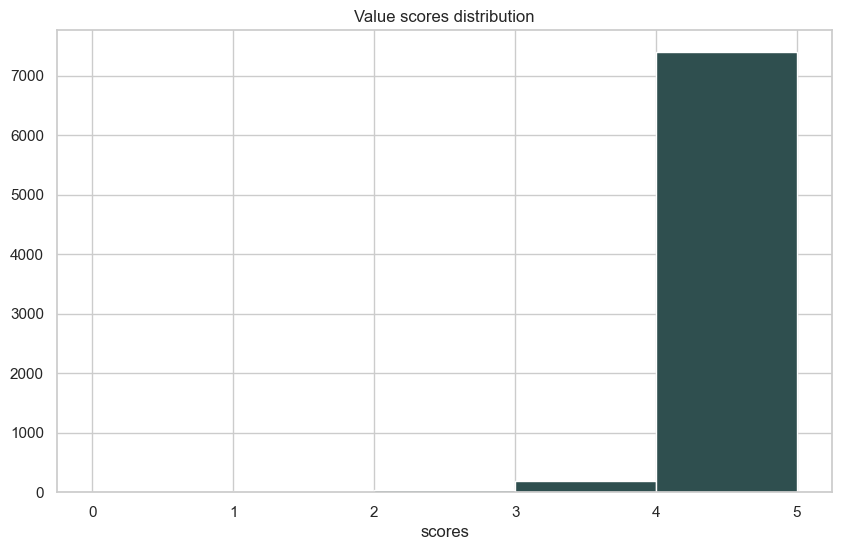

In [89]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.review_scores_value,bins=5, color="darkslategray")
axes.set_title("Value scores distribution")
axes.set_xlabel("scores")

plt.show()
plt.close()

### number_of_reviews

The number of reviews the listing has.

In [90]:
latest_listings.number_of_reviews.describe()

count    10560.000000
mean        39.426136
std         74.913022
min          0.000000
25%          0.000000
50%          8.000000
75%         42.000000
max        875.000000
Name: number_of_reviews, dtype: float64

The mean is 44 reviews per listing with an std of 77, this is very skewed. It likely means there are a lot of properties that have been on airbnb for a long time, additionally, not many people leave reviews, I think the data estimates less than 30% leave a review after their stay. That would account for 1/4th having only 1 review and the median being 10 reviews. 

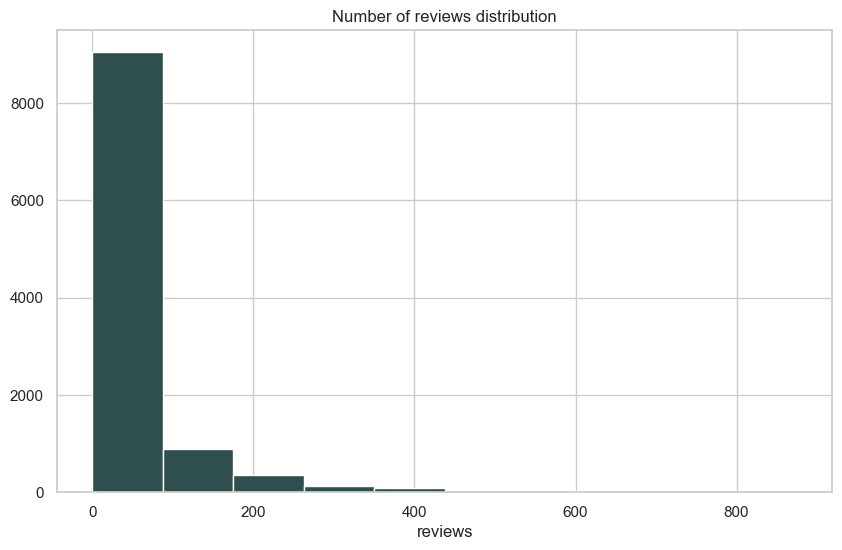

In [91]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.number_of_reviews,bins=10, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

Let's look at just a range between 0-20 total reviews. 

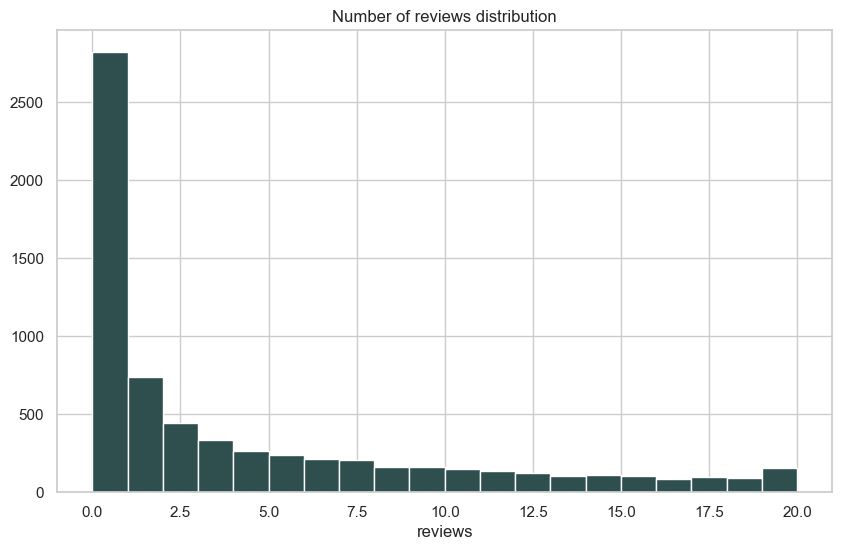

In [92]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.number_of_reviews,range=[0,20],bins=20, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

This is interesting, it looks like a large number of properties have less than 2 total reviews. That's going to skew our data considerably. Let's see how many are zero reviews. 

In [93]:
print(latest_listings[latest_listings["number_of_reviews"] == 0 ]["number_of_reviews"])

37       0
49       0
68       0
94       0
129      0
        ..
10552    0
10555    0
10557    0
10558    0
10559    0
Name: number_of_reviews, Length: 2820, dtype: int32


It seems that 22% of our listings have 0 reviews! That's very high.

### number_of_reviews_ltm

The number of reviews the listing has (in the last 12 months). I'm hoping this matches our four quarters as measured. 

In [94]:
latest_listings.number_of_reviews_ltm.describe()

count    10560.000000
mean        10.165814
std         19.074238
min          0.000000
25%          0.000000
50%          1.000000
75%         12.000000
max        341.000000
Name: number_of_reviews_ltm, dtype: float64

In the last 12 months, there were a mean number of 11 reviews for our listings. The median is 2 and the 3rd quartile is 15. There is a min of 0 reviews and a max of 341 reviews, that's almost one review per day for that listing!

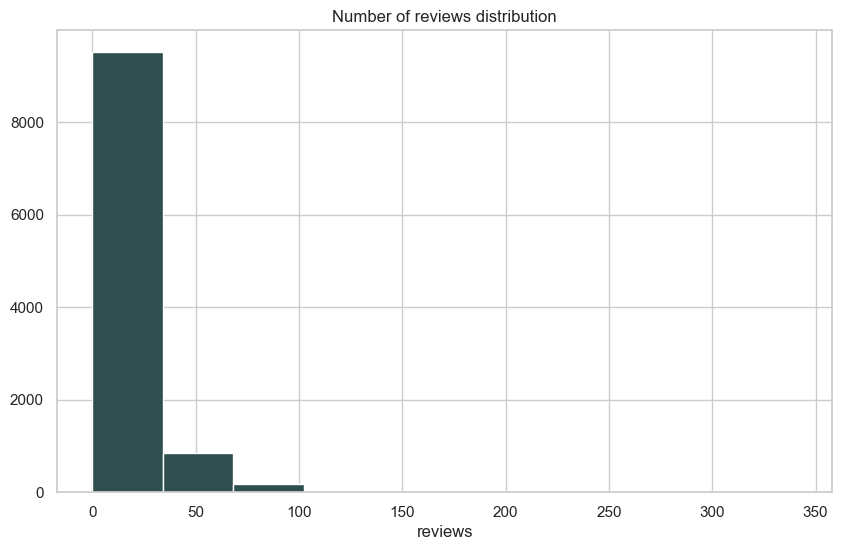

In [95]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.number_of_reviews_ltm,bins=10, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

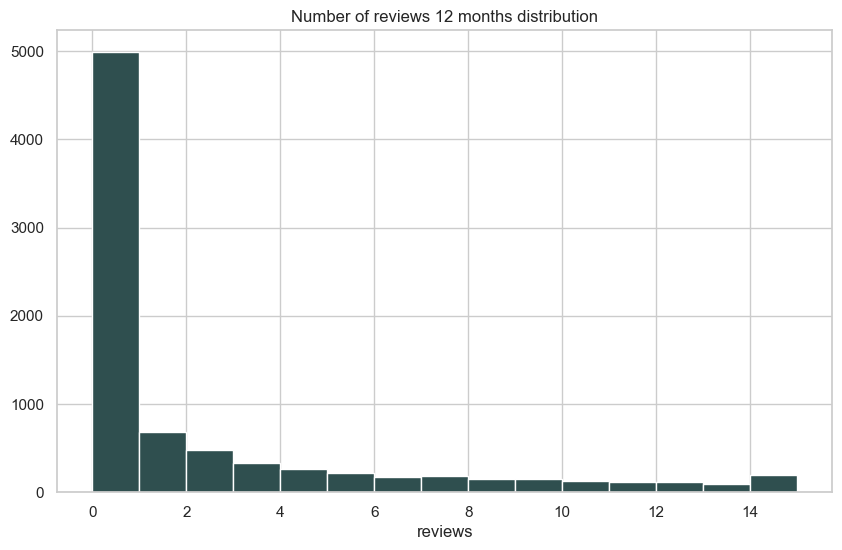

In [96]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.number_of_reviews_ltm,range=[0,15],bins=15, color="darkslategray")
axes.set_title("Number of reviews 12 months distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

### number_of_reviews_l30d

This variable is the number of reviews the listing has (in the last 30 days).

In [97]:
latest_listings.number_of_reviews_l30d.describe()

count    10560.000000
mean         0.768845
std          2.097824
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        119.000000
Name: number_of_reviews_l30d, dtype: float64

In the last 30 months, there were a mean number of less than 1 reviews for our listings. The median is 0 and the 3rd quartile is 1. There is a min of 0 reviews and a max of 119 reviews.

### reviews_per_month

The number of reviews the listing has over the lifetime of the listing.

In [98]:
latest_listings.reviews_per_month.describe()

count    7740.000000
mean        1.602641
std         2.193940
min         0.010000
25%         0.240000
50%         0.940000
75%         2.340000
max       105.000000
Name: reviews_per_month, dtype: float64

In our listings there were a mean number of less than 1 reviews for the lifetime of listings. The median is 0 and the 3rd quartile is 2. There is a min of 0 reviews and a max of 105 reviews.

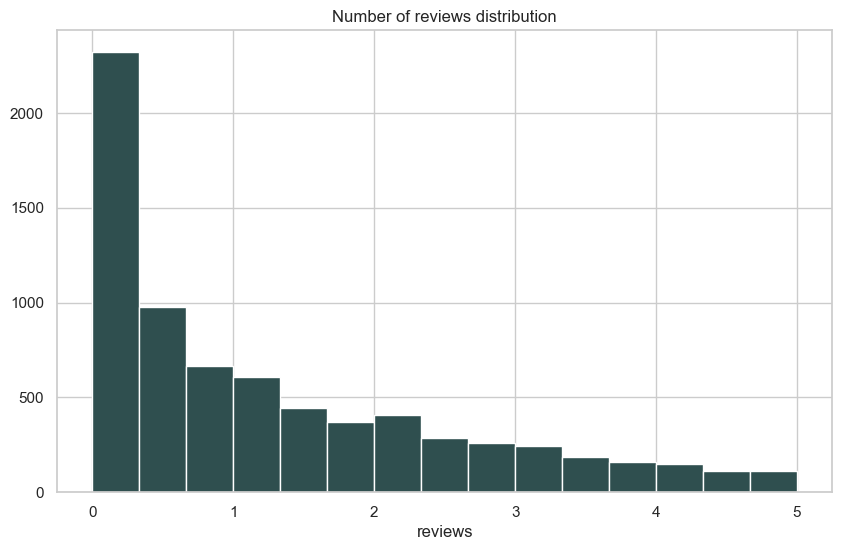

In [99]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(latest_listings.reviews_per_month,range=[0,5],bins=15, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

## <a id='calendar'>Calendar Data</a>


The AirBNB data includes a large calendar data set, and we want to investigate the usefulness of it. One omission from this data set is the indicator of when a listing was actually booked. Having this indicator would allow us to determine actual booked listings, and possibly revenues.

The variables from the calendar table are:

    * listing_id
    * date
    * available
    * price
    * adjusted_price
    * minimum_nights
    * maximum_nights

In [100]:
calendar_listings = con.execute('SELECT * from calendar').df()
calendar_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245531 entries, 0 to 10245530
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.2+ MB


The calendar table has 10 million rows. This is likely because we have an entry for each date a property is available on airbnb.

In [101]:
calendar_listings.head()

listing_id       date available  price  adjusted_price  minimum_nights  \
0        3943 2021-12-15         t   70.0            70.0             2.0   
1        3943 2021-12-16         t   70.0            70.0             2.0   
2        3943 2021-12-17         f   70.0            70.0             2.0   
3        3943 2021-12-18         f   70.0            70.0             2.0   
4        3943 2021-12-19         t   70.0            70.0             2.0   

   maximum_nights  
0          1125.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0

We have listing_id which is unique and for each data the the listing is available there is an entry for it in the database and a price. We want to see if there is any relationship between price. 

### Summary
We did a thorough investigation of the calendar data set, but did not find data that could be used to explain or model. The investigation can be found in the EDA notebook (eda.ipynb). For this report, we will omit the analysis.

## <a id='crime_data'>Crime Data</a>


The crime data includes location data, crime type, and datetime information. Each row is a single crime.

In [102]:
con.execute('select * from crimes;')
crime_data = con.fetch_df()
print(crime_data)

       column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0             0           cluster 25      violent -77.002778   
1             1           cluster 26      violent -76.997326   
2             2           cluster 35      violent -76.964260   
3             3           cluster 39      violent -76.999896   
4             4            cluster 2     property -77.025347   
...         ...                  ...          ...        ...   
27606     27606            cluster 1     property -77.042324   
27607     27607            cluster 1     property -77.042369   
27608     27608           cluster 26     property -76.994963   
27609     27609           cluster 11     property -77.081165   
27610     27610           cluster 25     property -77.001314   

                     END_DATE                offense-text     SHIFT  \
0        9/7/2021, 2:18:00 PM                    homicide  midnight   
1       10/3/2021, 3:20:00 PM                     robbery   evening   
2       10/3/2021,

### <a id='neighborhood_cluster'>Neighborhood cluster</a>
Neighborhood cluster represents which neighbhor hood the crime happened. There are 45 clusters in this column and they can be matched to a specific neighbhor hood. The most frequent one is cluster 25. This value tied close to the neighbor hood name column. This is a categorical variable.

In [103]:
crime_data.NEIGHBORHOOD_CLUSTER.describe()

count          27609
unique            45
top       cluster 25
freq            2070
Name: NEIGHBORHOOD_CLUSTER, dtype: object

In [104]:
crime_data.NEIGHBORHOOD_CLUSTER.value_counts()

cluster 25    2070
cluster 8     2055
cluster 2     1788
cluster 3     1598
cluster 23    1335
cluster 6     1276
cluster 18    1270
cluster 7     1125
cluster 21    1115
cluster 26    1095
cluster 22     996
cluster 39     990
cluster 34     752
cluster 17     747
cluster 1      729
cluster 33     693
cluster 31     667
cluster 27     592
cluster 4      566
cluster 32     561
cluster 9      501
cluster 19     488
cluster 24     452
cluster 38     367
cluster 11     365
cluster 30     359
cluster 15     329
cluster 20     319
cluster 35     315
cluster 5      301
cluster 14     292
cluster 37     266
cluster 28     225
cluster 12     219
cluster 36     207
cluster 10     188
cluster 16     148
cluster 13      91
cluster 45      48
cluster 29      44
cluster 43      32
cluster 40      15
cluster 44       7
cluster 46       7
cluster 41       4
Name: NEIGHBORHOOD_CLUSTER, dtype: int64

### <a id='offense_group'>offense group</a>
There are two types of offense crime in this variable, Property and violent, so it's a categorical variable. We can see from the summary that majority of the offense is property.

In [105]:
crime_data.offensegroup.value_counts()

property    23567
violent      4044
Name: offensegroup, dtype: int64

### <a id='longitude'>Longtitude</a>
This is a pretty straightforward variable. It represents the longtitude of the crime. Longtitude is a continuous numerical data and let's a take a look at the summary of it.

In [106]:
crime_data.LONGITUDE.describe()

count    27611.000000
mean       -77.007869
std          0.034340
min        -77.112316
25%        -77.030787
50%        -77.010666
75%        -76.986919
max        -76.910021
Name: LONGITUDE, dtype: float64

The min here is -77.1123 and max is -76.9100. Since our crime data is based on DC area, so this make perfect sense. Now let's take a look at the distribution of it.

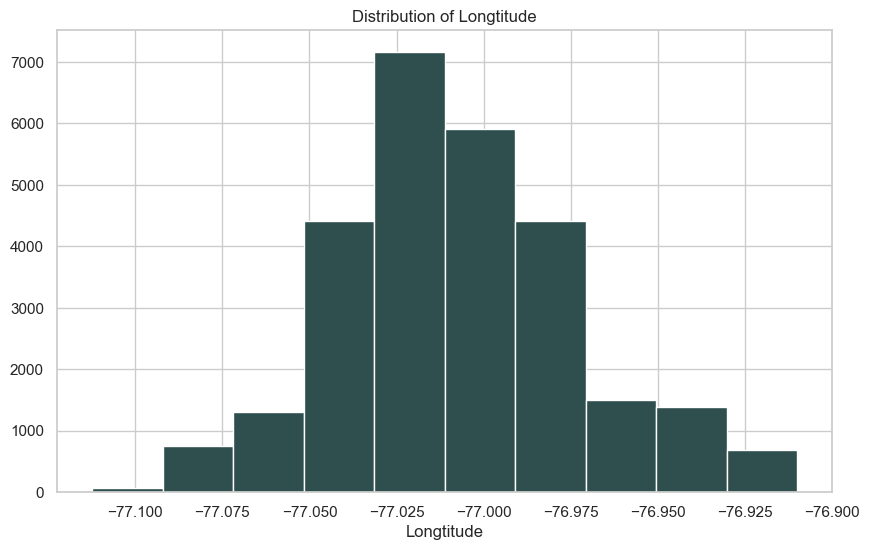

In [107]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.LONGITUDE, color="darkslategray")
axes.set_title("Distribution of Longtitude")
axes.set_xlabel("Longtitude")

plt.show()
plt.close()

Here the distribution looks very nearly normal. 50% of the crimes has the longtitude between -77.050 to -76.975.

### <a id='end_date'>end date</a>
This variable represents the time and date when the crime end. It's a date type.

In [108]:
crime_data.END_DATE.describe()

count                     25411
unique                    22106
top       5/25/2022, 7:00:00 AM
freq                          7
Name: END_DATE, dtype: object

### <a id='offense_text'>offense-text</a>
This is another variable to describle the type of crime. It's a categorical variable. Let's take a look at the summary of it.

In [109]:
crime_data['offense-text'].describe()

count           27611
unique              9
top       theft/other
freq            10783
Name: offense-text, dtype: object

In [110]:
crime_data['offense-text'].value_counts()

theft/other                   10783
theft f/auto                   8077
motor vehicle theft            3535
robbery                        2167
assault w/dangerous weapon     1499
burglary                       1168
homicide                        221
sex abuse                       157
arson                             4
Name: offense-text, dtype: int64

We can see there are 9 different types of offsense. Most of them are theft/other and theft/auto which aligned well with our offense group variable.

### <a id='shift'>Shift</a> ###
Shift means the time range for the crime happened. It's a oridinal variable and there are three values in it, day, midnight, evening. Let's take a look at the summary of it.

In [111]:
crime_data.SHIFT.value_counts()

evening     11109
day         10863
midnight     5639
Name: SHIFT, dtype: int64

We can see that majority of the crimes happened during evening and daytime.

### <a id='offensekey'>offense key </a>
Offense key is another variable describe the type of crimes. It's a aggregation of offensegroup and offense-text. It's also a categorical variable.

In [112]:
crime_data.offensekey.describe()

count                    27611
unique                       9
top       property|theft/other
freq                     10783
Name: offensekey, dtype: object

In [113]:
crime_data.offensekey.value_counts()

property|theft/other                  10783
property|theft f/auto                  8077
property|motor vehicle theft           3535
violent|robbery                        2167
violent|assault w/dangerous weapon     1499
property|burglary                      1168
violent|homicide                        221
violent|sex abuse                       157
property|arson                            4
Name: offensekey, dtype: int64

We can see that there are 9 unique types and the top 3 are property related crimes which are theft/other, theft/auto and motor vehicle theft.

### <a id='start_date'>start date </a>
Similar to end date, this variable represents the time and date when the crime start. It's a date type.

In [114]:
crime_data.START_DATE.describe()

count                   27602
unique                    459
top       2021-10-06 00:00:00
freq                      123
first     2010-05-28 00:00:00
last      2022-09-29 00:00:00
Name: START_DATE, dtype: object

### <a id='offense'>offense</a>
This variable describle the actual type of the crime which is similar to the offense-text. It's also a categorical variable.

In [115]:
crime_data.OFFENSE.describe()

count           27611
unique              9
top       theft/other
freq            10783
Name: OFFENSE, dtype: object

In [116]:
crime_data.OFFENSE.value_counts()

theft/other                   10783
theft f/auto                   8077
motor vehicle theft            3535
robbery                        2167
assault w/dangerous weapon     1499
burglary                       1168
homicide                        221
sex abuse                       157
arson                             4
Name: OFFENSE, dtype: int64

Similar to the results above for offense-text, there are 9 types of crimes.

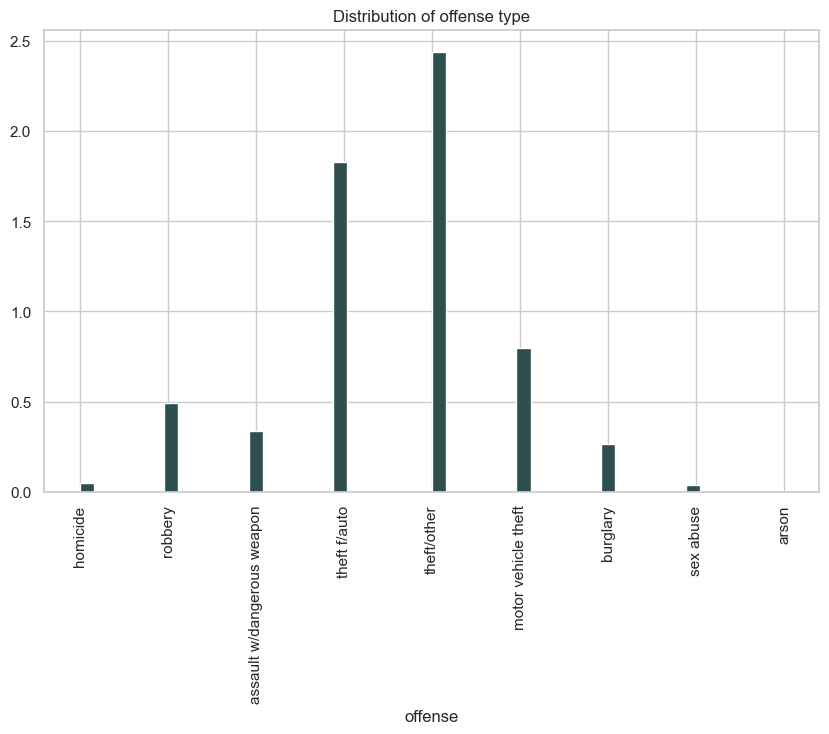

In [117]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.OFFENSE, color="darkslategray", bins=50, density=True)
axes.set_title("Distribution of offense type")
axes.set_xlabel("offense")
plt.xticks(rotation='vertical')

plt.show()
plt.close()

### <a id='method'>Method</a>
Method is the variable to describle how the crime was commited. It's a categorical variable. Let's take a look at the summary of it.

In [118]:
crime_data.METHOD.describe()

count      27611
unique         3
top       others
freq       24756
Name: METHOD, dtype: object

In [119]:
crime_data.METHOD.value_counts()

others    24756
gun        2333
knife       522
Name: METHOD, dtype: int64

We can see there are 3 methods in it, others, gun and knife. Most of them are others. 

### <a id='latitude'>Latitude</a>
Similar to Longtitude, This is a pretty straightforward variable. It represents the Latitude of the crime. Latitude is a continuous numerical data and let's a take a look at the summary of it.

In [120]:
crime_data.LATITUDE.describe()

count    27611.000000
mean        38.907542
std          0.029605
min         38.814659
25%         38.894325
50%         38.907235
75%         38.923862
max         38.994901
Name: LATITUDE, dtype: float64

The min here is 38.8147 and max is 38.9949. Since our crime data is based on DC area, so this make perfect sense. Now let's take a look at the distribution of it.

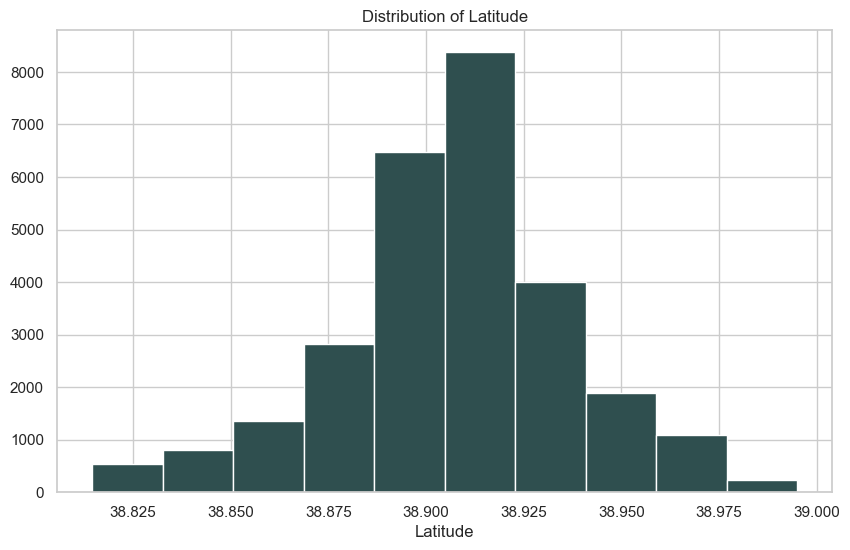

In [121]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(crime_data.LATITUDE, color="darkslategray")
axes.set_title("Distribution of Latitude")
axes.set_xlabel("Latitude")

plt.show()
plt.close()

Here the distribution looks very nearly normal. 50% of the longtitude has the latitude between 38.875 to 38.925.

### <a id='neighborhood_name'>Neighborhood name </a>
This is a new variable we added to the dataset. This is the actual name for the neighborhood cluster. Let's take a look at the summary.

In [122]:
crime_data.NEIGHBORHOOD_NAME.describe()

count                                         27611
unique                                           46
top       Union Station, Stanton Park, Kingman Park
freq                                           2070
Name: NEIGHBORHOOD_NAME, dtype: object

In [123]:
crime_data.NEIGHBORHOOD_NAME.value_counts()

Union Station, Stanton Park, Kingman Park                                                            2070
Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street                        2055
Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View                                           1788
Howard University, Le Droit Park, Cardozo/Shaw                                                       1598
Ivy City, Arboretum, Trinidad, Carver Langston                                                       1335
Dupont Circle, Connecticut Avenue/K Street                                                           1276
Brightwood Park, Crestwood, Petworth                                                                 1270
Shaw, Logan Circle                                                                                   1125
Edgewood, Bloomingdale, Truxton Circle, Eckington                                                    1115
Capitol Hill, Lincoln Park                    

# Pairwise EDA - 
# <a id="pairwise_eda_price">Target Variable: price </a>


## Neighborhood v. Price

Let's look at the pairwise analysis of `neighborhood` and `price`. I expect AirBnB price to track general rent cost of the D.C. areas. Neighborhoods with higher rent will have a higher nightly AirBnB price on average and the reverse would be true for areas with low rent. From general domain knowledge about Washington D.C., I know that the downtown area and the Northwest quadrant have higher rents on average than the Northeast and Southeast quadrant. Therefore I expect AirBnB nightly prices to be higher on average in the downtown area and the Northwest quadrant. 

One thing we will need to be mindful of in doing this analysis is the comparison of *counts* of AirBnB listings in each neighborhood cluster. Some clusters might have a high density of AirBnBs and others will have much fewer. Let's get the counts in tabular form as well as plotting them on the D.C. map. First, we must remove duplicate listings.

In [124]:
# Code from Lab 5 Solution
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [125]:
# Code from Module 5
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [126]:
# Code from Module 5
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [127]:
# Code from Module 5
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [128]:
# Code from Module 5
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)

    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

In [129]:
# Code from Module 5
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(30, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_xticklabels(labels, rotation=90, ha='right')
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

## `neighborhood` vs. `price` <a id="neighborhood_vs_price"></a>

We want to look at the interaction between neighborhood and price. Just like non-rental, non-hospitality real estate, AirBnB nightly price will vary by neighborhood. Nicer neighborhoods will generally have more expensive AirBnBs whereas poorer neighborhoods will generally have cheaper AirBnBs. 

Other factors that contribute to the correlation between neighborhood and price is the amenity makeup of a neighborhood. Neighborhoods with more access to amenities and attractions will have more expensive AirBnBs. For this reason, I suspect that neighborhoods near the central business district (downtown) will have more expensive AirBnBs.

For the remainder of this analysis we will use only the latest listings from the most recent quarter.

In [130]:
latest_listings = con.execute("select * from latest_listings;").df()
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [131]:
latest_listings_gdf = gpd.GeoDataFrame(
    latest_listings, geometry=gpd.points_from_xy(latest_listings.longitude, latest_listings.latitude))

Let's look at where the AirBnBs are on the neighborhood map.

In [132]:
type(latest_listings_gdf.geometry)

geopandas.geoseries.GeoSeries

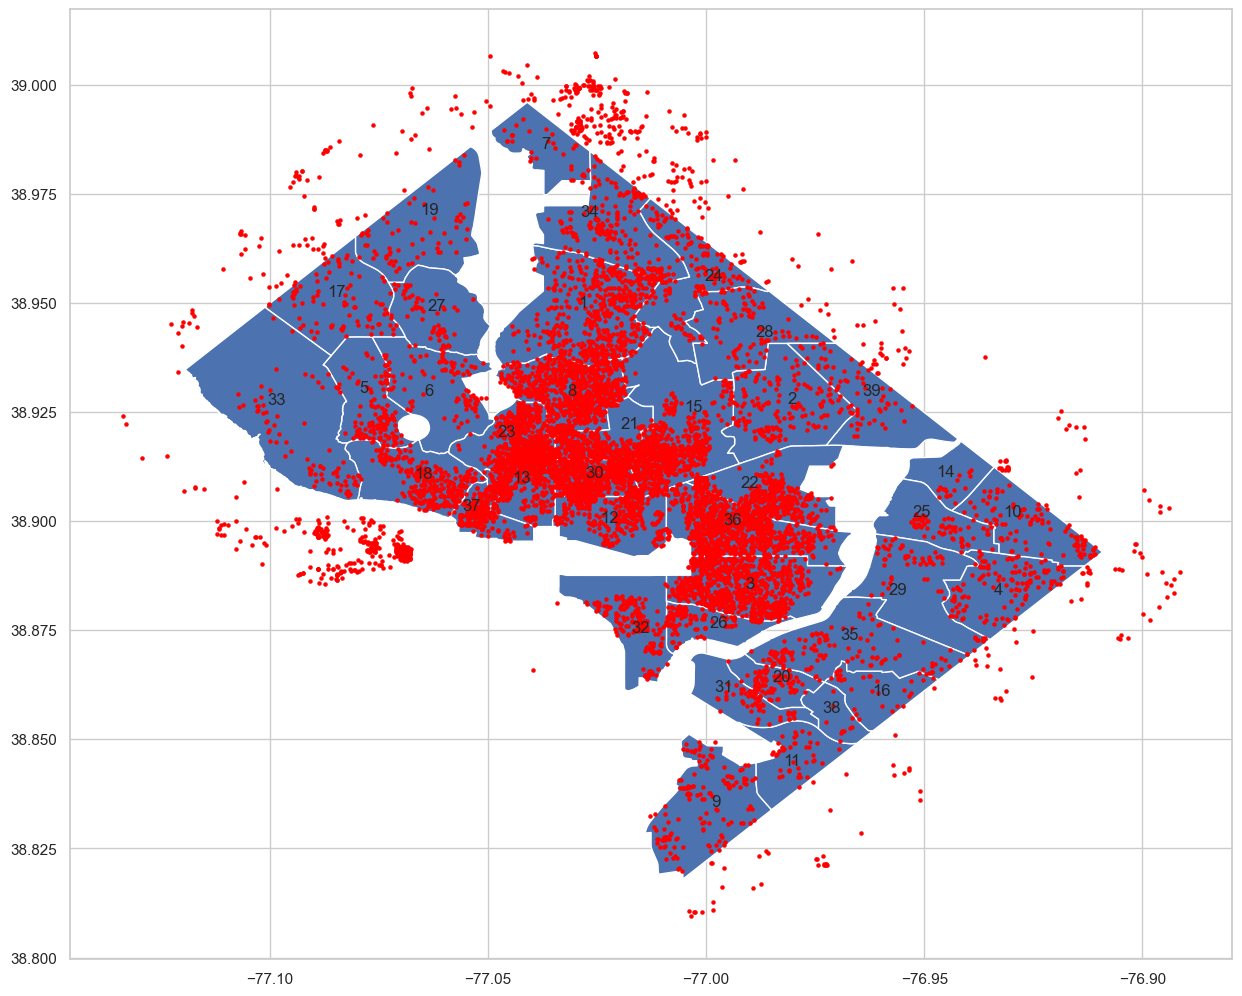

In [133]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')
    
latest_listings_gdf.geometry.plot(ax=base, marker='o', color='red', markersize=5);
    
plt.show()

It turns out there *are* listings that exist outside of the DC borders. There are listings in the Arlington are of Virginia and various parts of Maryland. The listing densities of each neighbrhood cluster vary immensely. The clusters close to the downtown/National Mall area have the highest density of AirBnBs. The density becomes smaller the further out you go from downtown. Let's look at the densities in tabular form:

In [134]:
describe_by_category(latest_listings, "price", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             518.000000   
mean                                              142.733591   
std                                               161.809158   
min                                                20.000000   
25%                                                69.000000   
50%                                                95.000000   
75%                                               150.000000   
max                                              1500.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                      152.000000   
mean                                       130.921053   
std                                        107.605087   
min                                         29.000000   
25%                                         70.000000   
50%                                         99.000000   
75%                     

This data is pretty hard to consume but we can see a stark difference in the `count` of AirBnBs per neighborhood cluster. Let's plot the average price for each neighborhood using box plots to get a better feel for the comparative price

In [135]:
latest_listings_below_1500 =  latest_listings[latest_listings.price < 1500]

In [136]:
latest_listings_below_500 =  latest_listings[latest_listings.price < 500]

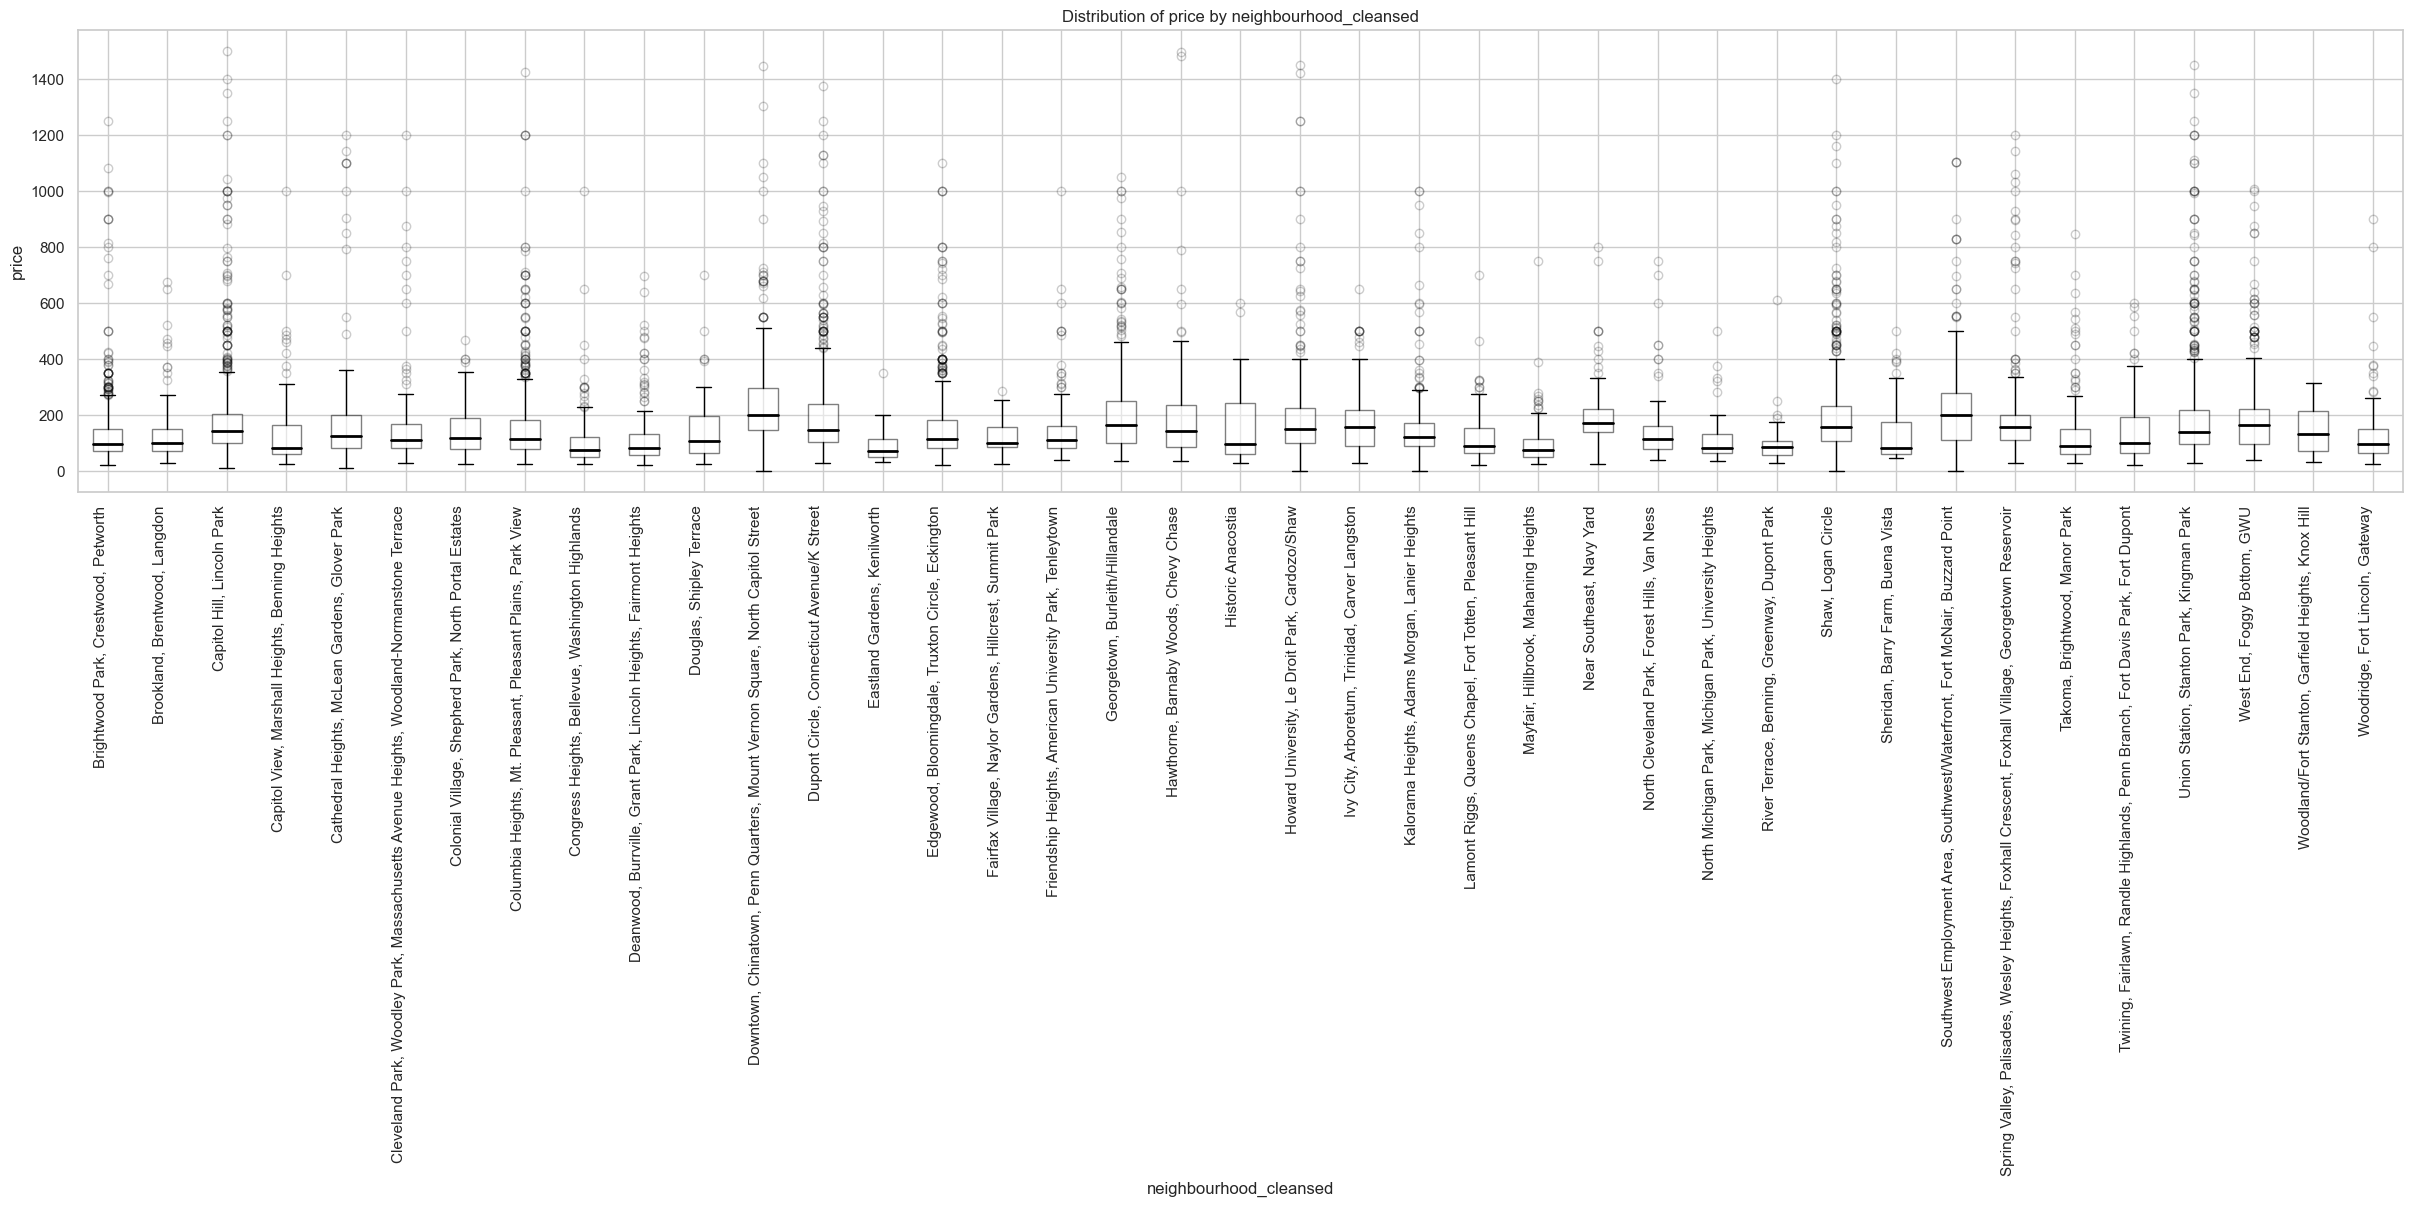

In [137]:
multiboxplot(latest_listings_below_1500, "price", "neighbourhood_cleansed")

From this plot, we can see that no neighborhood has a median nightly cost greater than ~200 USD. Some notably expensive neighborhoods include the Downtown Chinatown Penn Quarters are, Shaw Logan Circle, Georgetown, the Southwest Emplyment Area, Union Station, and West End. From my own experience living in D.C., all of these areas are near downtown, have good amenities, and are nicer neighborhoods than most.

I am now going to plot a heatmap of the average price of AirBnBs be neighborhood for (1) listings below 500 USD, (2) listings below 1500 USD, and (3) all listings.

### Price by neighborhood (only listings below 500 USD)

In [138]:
grouped = latest_listings_below_500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

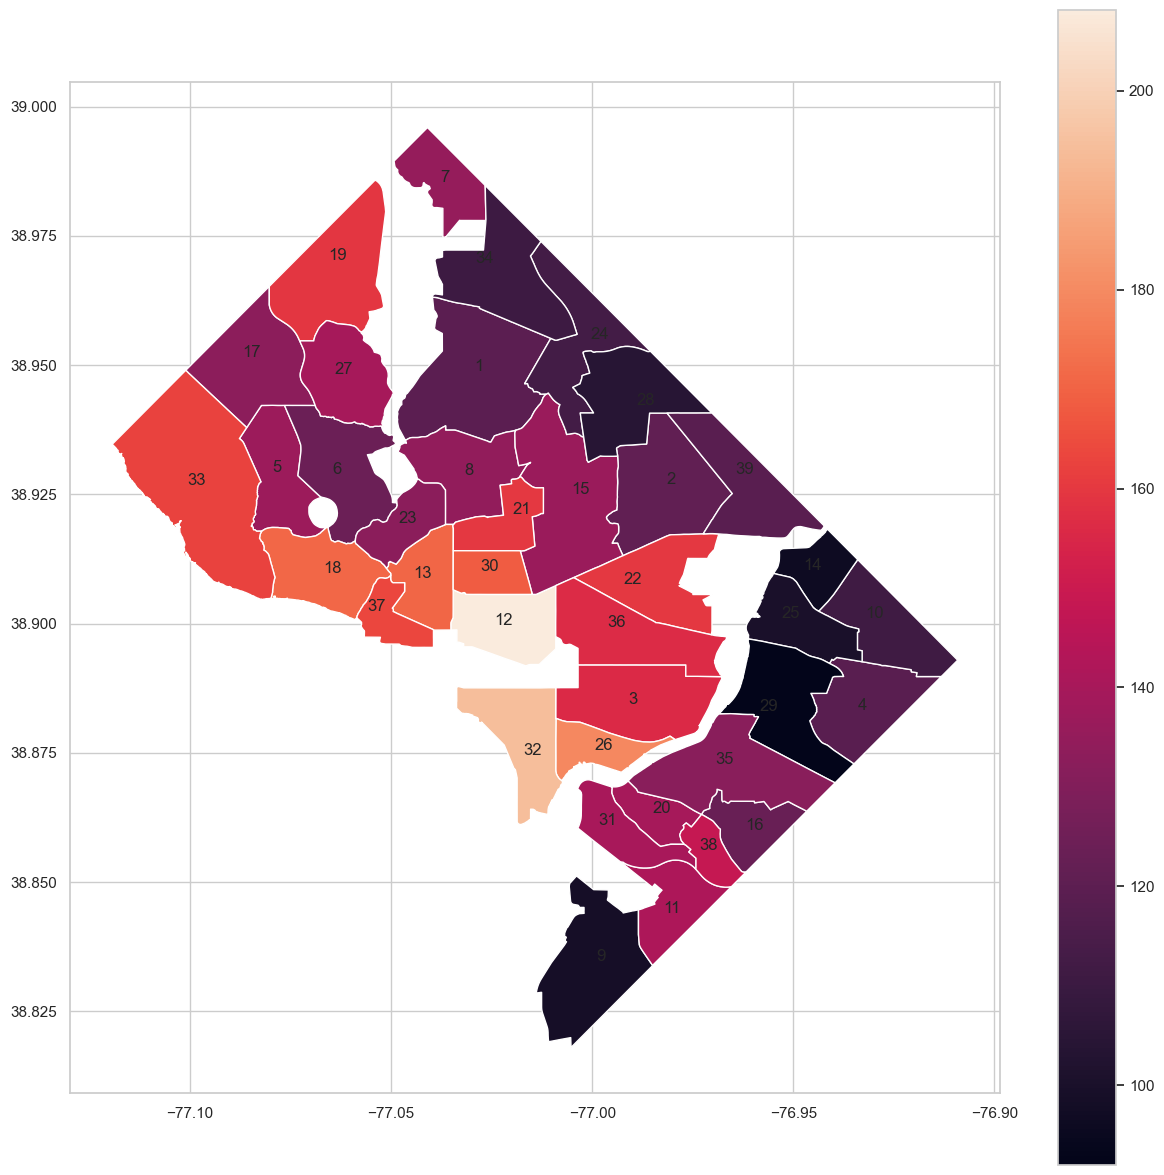

In [139]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (only listings below 1500 USD)

In [140]:
grouped = latest_listings_below_1500.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_1500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

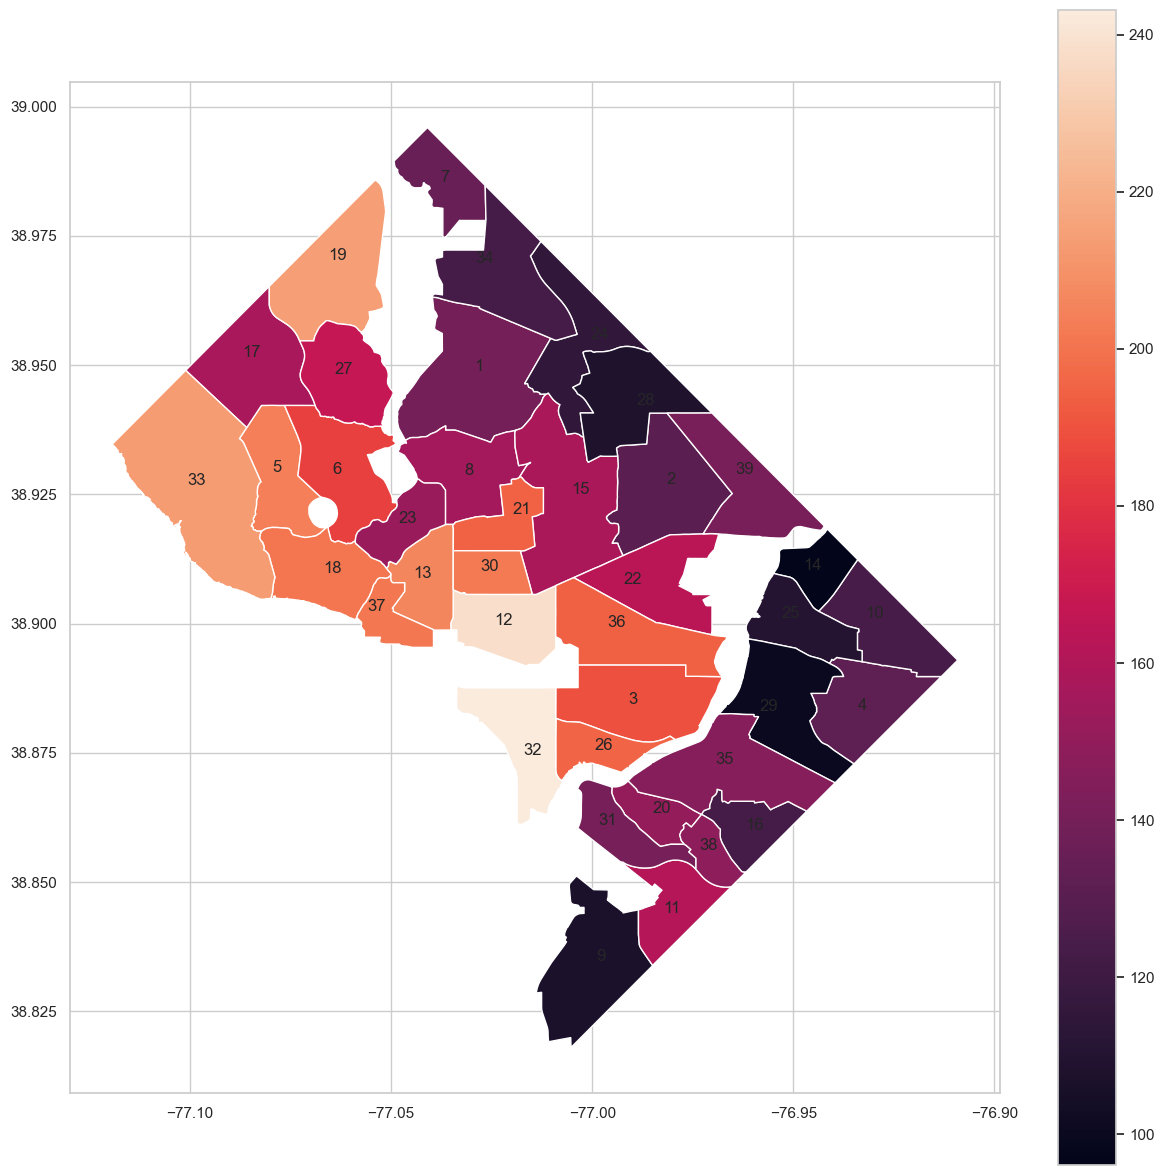

In [141]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

### Price by neighborhood (all listings)

In [142]:
grouped = latest_listings.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["price"].get_group( k) for k in labels]
grouped_y = grouped['price'].describe()
avg_price_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_price'] = avg_price_per_neighborhood

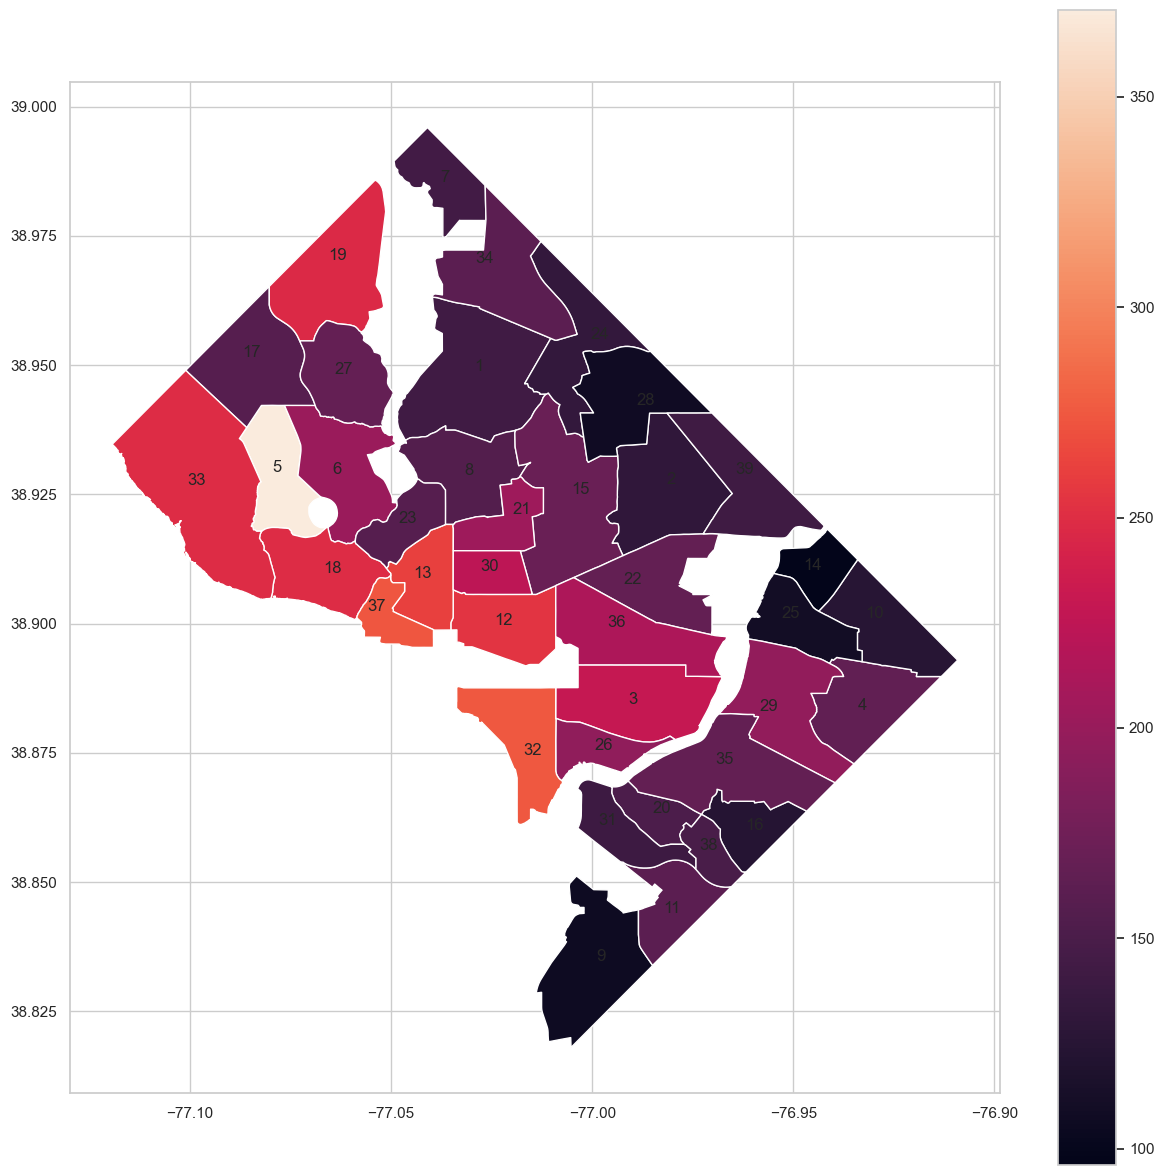

In [143]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_price",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

Clearly, the outliers in the `all_listings` table skew the coloring of the map. However, all maps align with what was predicted in that areas near downtown and/or the NW quadrant of the city (especially near the Potomac) are most expensive. Areas in the NE and SE quadrant, especially areas further away radially from Downtown are less expensive.

In [144]:
latest_listings["years_host"] = (res - latest_listings.host_since) / np.timedelta64(1,'Y')

In [145]:
latest_listings['price'].isnull().values.any()

False

### Neighborhood Conclusion

We can definitely see that price varies by neighborhood. Northwest DC and the downtown area are more expensive while northeast DC and areas further away from Downtown are cheaper. We expect that neighborhood would be useful in a regression however with there being so many categories, we also expect that we could extract the same relevant information as it relates to price by using other location-based variables like `latitude` and `longitude`. 

## <a id='host_info_v_price'>Host Information v. Price</a>

### `host_since` vs `price` <a id="host_since_vs_price"></a>

We are now going to look at the relationship between how long someone has been a host and the price of their listings. I don't expect there to be any kind of strong correlation between the two.

In [146]:
latest_listings_non_null_host_since = latest_listings[latest_listings["years_host"].notnull()]

In [147]:
correlation(latest_listings_non_null_host_since, "price", "years_host")

Correlation coefficients:
r   = -0.0032471026963352464 (very weak)
rho = -0.08698568268122552 (very weak)


As I expected, there is almost zero correlation. Let's look at the scatterplot

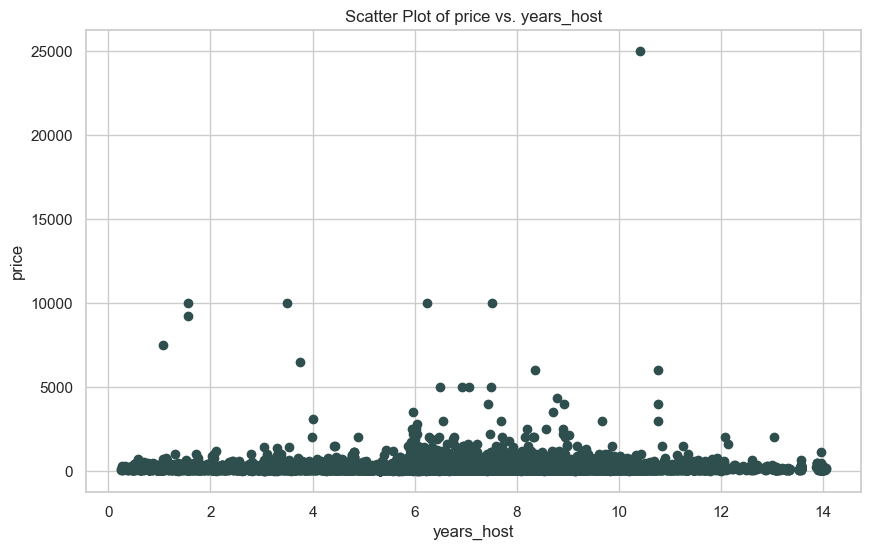

In [148]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since.years_host, latest_listings_non_null_host_since.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

This plot shows the average price is almost a straight line across all years being a host. The outliers making it hard to see detail. Let's zoom in:

In [149]:
latest_listings_below_500["years_host"] = (res - latest_listings_below_500.host_since) / np.timedelta64(1,'Y')

In [150]:
latest_listings_non_null_host_since_below_500 = latest_listings_below_500[latest_listings_below_500["years_host"].notnull()]

In [151]:
correlation(latest_listings_non_null_host_since_below_500, "price", "years_host")

Correlation coefficients:
r   = -0.10565400632052657 (very weak)
rho = -0.11097828442186954 (very weak)


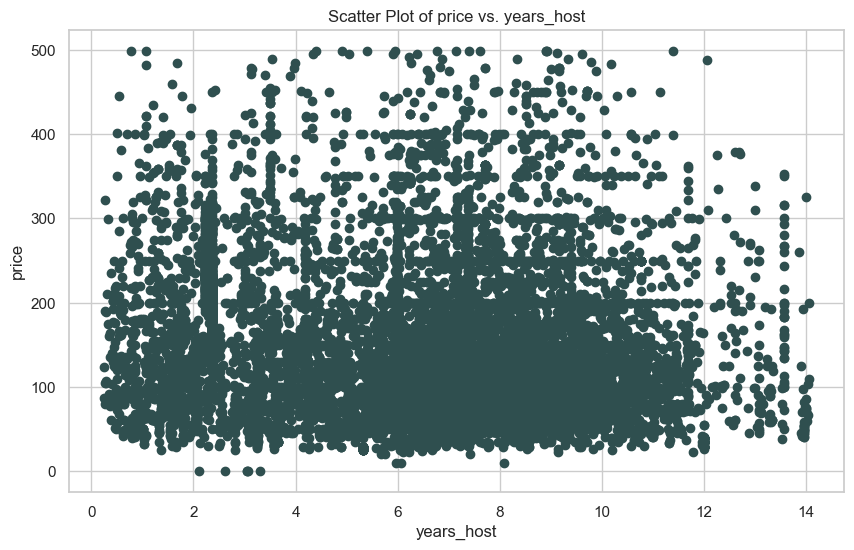

In [152]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since_below_500.years_host, latest_listings_non_null_host_since_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of price vs. years_host")

plt.show()
plt.close()

Even when we zoom in, there is clearly no correlation between year_host and price.

### `host_location` vs `price` <a id="host_location_vs_price"></a>

This one won't work because the data is ambiguous in category. There are several categories meaning the same thing like "DC" and "Washington DC" or "United States" and "US" all being separate categories.

### `host_response_time` vs `price` <a id="host_response_time_vs_price"></a>

I don't expect there to be a direct, causal relationship between these two variables. However, higher host response times likely correspond to a higher rating and overall stay experience which would in turn give the host leverage to raise the price of their AirBnB so I expect the relationship to be a slightly positive correlation.

In [153]:
describe_by_category(latest_listings_below_500, "price", "host_response_time", transpose=True)

host_response_time          N/A  a few days or more  within a day  \
count               2641.000000          182.000000    641.000000   
mean                 137.946611          124.197802    134.978159   
std                   94.925205           82.010068     81.423830   
min                    0.000000           25.000000     10.000000   
25%                   75.000000           65.000000     77.000000   
50%                  105.000000          100.000000    110.000000   
75%                  174.000000          150.000000    170.000000   
max                  499.000000          485.000000    499.000000   

host_response_time  within a few hours  within an hour  
count                      1047.000000     5344.000000  
mean                        117.108883      162.850299  
std                          82.213391       88.979790  
min                          22.000000        0.000000  
25%                          57.000000       95.000000  
50%                          95.0000

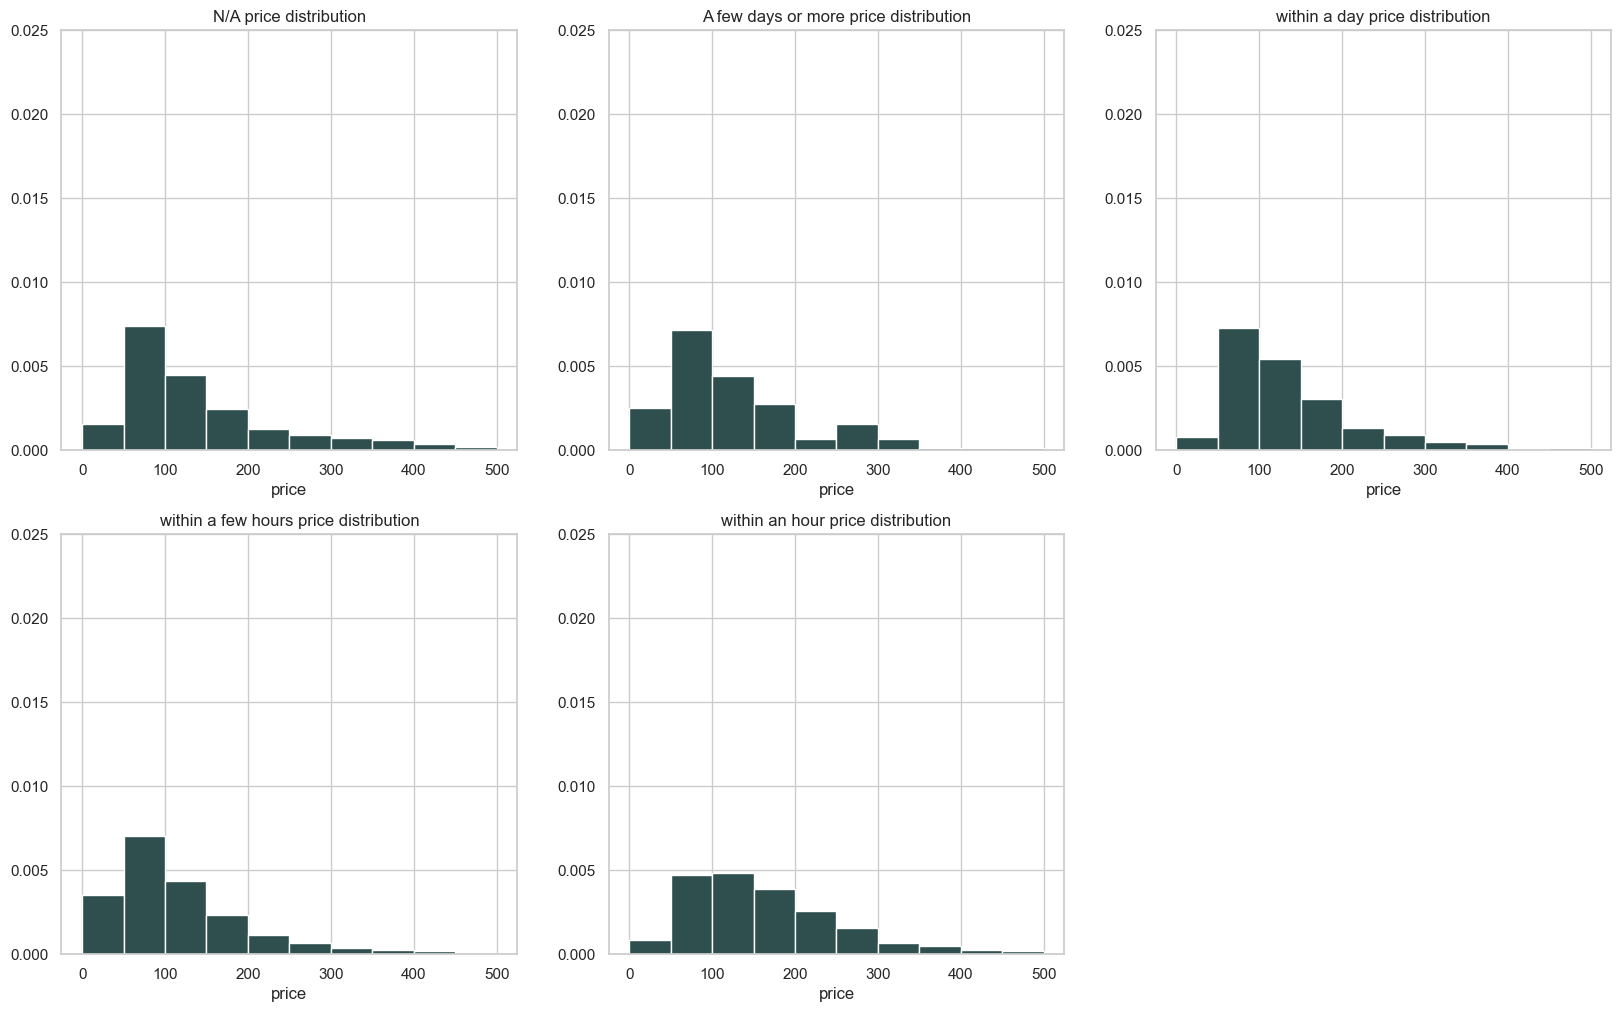

In [154]:
grouped = latest_listings_below_500.groupby("host_response_time")

figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 3, 1)
axes.hist(grouped["price"].get_group("N/A"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("N/A price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 2)
axes.hist(grouped["price"].get_group("a few days or more"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("A few days or more price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 3)
axes.hist(grouped["price"].get_group("within a day"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a day price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 4)
axes.hist(grouped["price"].get_group("within a few hours"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within a few hours price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 5)
axes.hist(grouped["price"].get_group("within an hour"),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.025))
axes.set_title("within an hour price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

Generally, the faster a host responds, the most expensive the AirBnB is nd the overall distribution of price is the same shape generally across all catogories.

### `host_response_rate` vs `price` <a id="host_respone_rate_vs_price"></a>

Similar to host response time, I expect host response rate has a positive correlation with rating which in turn gives the host leverage to raise the price of their listing.

In [155]:
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_response_rate'] = latest_listings_below_500['host_response_rate'].replace('%', '', regex=True).astype(float)

In [156]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [157]:
latest_listings_non_null_host_response_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_response_rate"].notnull()]

In [158]:
correlation(latest_listings_non_null_host_response_rate_below_500, "price", "host_response_rate")

Correlation coefficients:
r   = 0.07771063276548656 (very weak)
rho = 0.11987951077842735 (very weak)


The correlation is very weak but positive overall

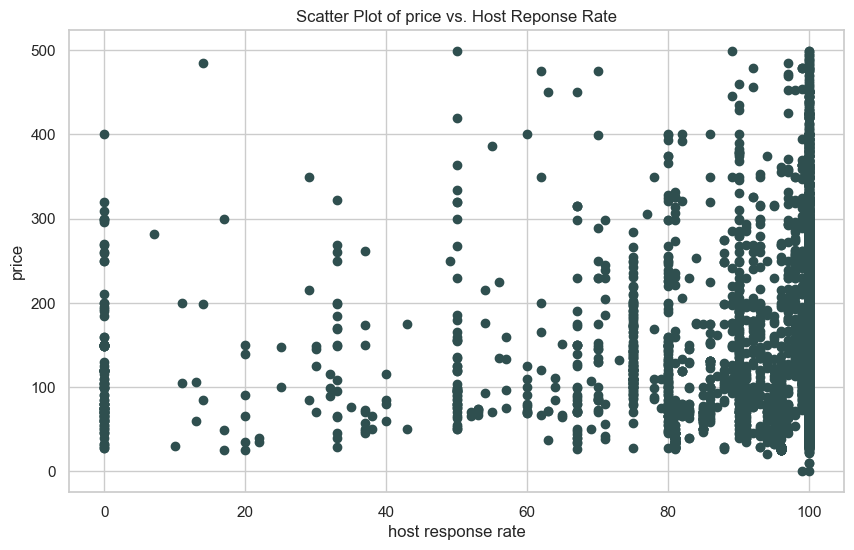

In [159]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_response_rate_below_500.host_response_rate, latest_listings_non_null_host_response_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host response rate")
axes.set_title("Scatter Plot of price vs. Host Reponse Rate")

plt.show()
plt.close()

The scatterplot shows this slight positive correlation. The handful of 0% response rate hosts might be skewing this distribution.

### `host_acceptance_rate` vs `price` <a id="host_acceptance_rate_vs_price"></a>

Similar to host response time and rate, I expect host acceptance rate has a positive correlation with rating which in turn gives the host leverage to raise the price of their listing.

In [160]:
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings_below_500['host_acceptance_rate'] = latest_listings_below_500['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [161]:
latest_listings_below_500['host_response_rate'].isnull().values.any()

True

In [162]:
latest_listings_non_null_host_acceptance_rate_below_500 = latest_listings_below_500[latest_listings_below_500["host_acceptance_rate"].notnull()]

In [163]:
correlation(latest_listings_non_null_host_acceptance_rate_below_500, "price", "host_acceptance_rate")

Correlation coefficients:
r   = 0.14181600177900086 (very weak)
rho = 0.07371328158619253 (very weak)


The correlation is very weak but overall positive

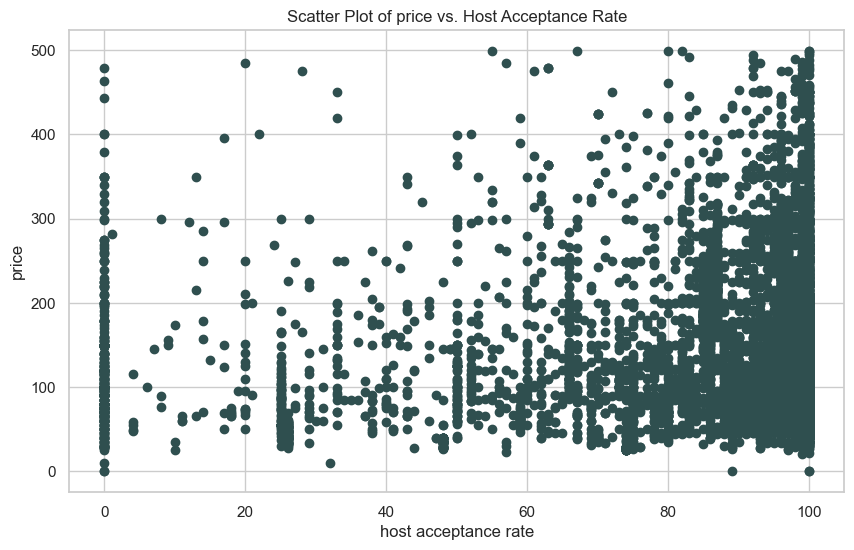

In [164]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_acceptance_rate_below_500.host_acceptance_rate, latest_listings_non_null_host_acceptance_rate_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host acceptance rate")
axes.set_title("Scatter Plot of price vs. Host Acceptance Rate")

plt.show()
plt.close()

The scatterplot shows this slight positive correlation. The handful of 0% response rate hosts might be skewing this distribution.

### `host_is_superhost` vs `price` <a id="host_is_superhost_vs_price"></a>

A host being a superhost requires that they have many positive traits. This would certainly give the host leverage to raise the price of their AirBnB. I expect there to be a weak positive correlation between the host being a superhost and price.

In [165]:
latest_listings_below_500['host_is_superhost'].isnull().values.any()

True

In [166]:
latest_listings_non_null_host_is_superhost_below_500 = latest_listings_below_500[latest_listings_below_500["host_is_superhost"].notnull()]

In [167]:
describe_by_category(latest_listings_below_500, "price", "host_is_superhost", transpose=True)

host_is_superhost        False         True
count              7509.000000  2499.000000
mean                149.125982   146.375350
std                  92.025995    84.974677
min                   0.000000    28.000000
25%                  80.000000    89.000000
50%                 125.000000   124.000000
75%                 200.000000   175.000000
max                 499.000000   499.000000


There actually appears to be a very very weak negative correlation. The average price of listings hosted by superhosts is slightly less than the average price of listings hosted by non superhosts.

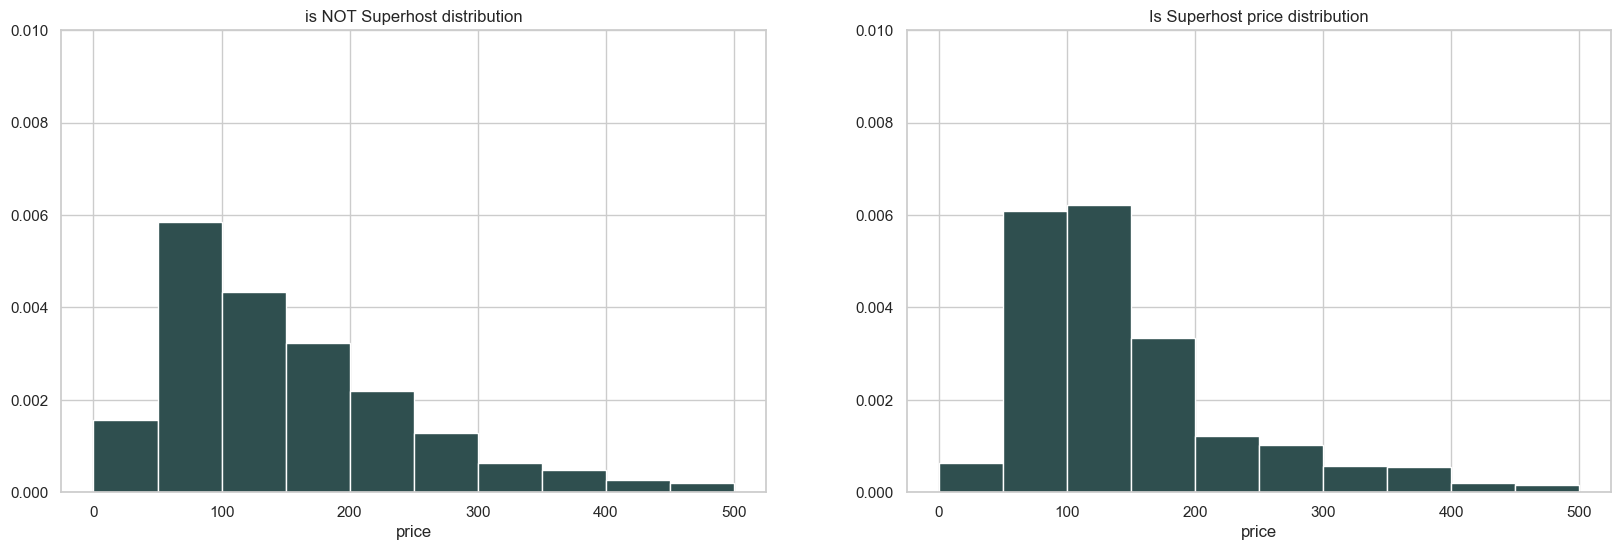

In [168]:
grouped = latest_listings_below_500.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("is NOT Superhost distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("Is Superhost price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The overall distribution across the two categories is comparable. 

### `host_listings_count` vs `price` <a id="host_listings_count_vs_price"></a>

Host listings count has some potential plausible interactions with listing price. For one, hosts with multiple listings might be more real-estate savvy and know how to prep a home that is worth a higher nightly cost. Or these hosts might only  be able to afford multiple listings because they are all cheap real-estate which would mean these two variables have a negative correlation. 

In [169]:
latest_listings_below_500['host_listings_count'].isnull().values.any()

True

In [170]:
latest_listings_non_null_host_listings_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count"].notnull()]

In [171]:
correlation(latest_listings_non_null_host_listings_count_below_500 , "price", "host_listings_count")

Correlation coefficients:
r   = 0.14389749392647586 (very weak)
rho = 0.14816794097130107 (very weak)


There is a positive correlation between these two variables. Hosts with more listings are more likely to have pricer AirBnBs.

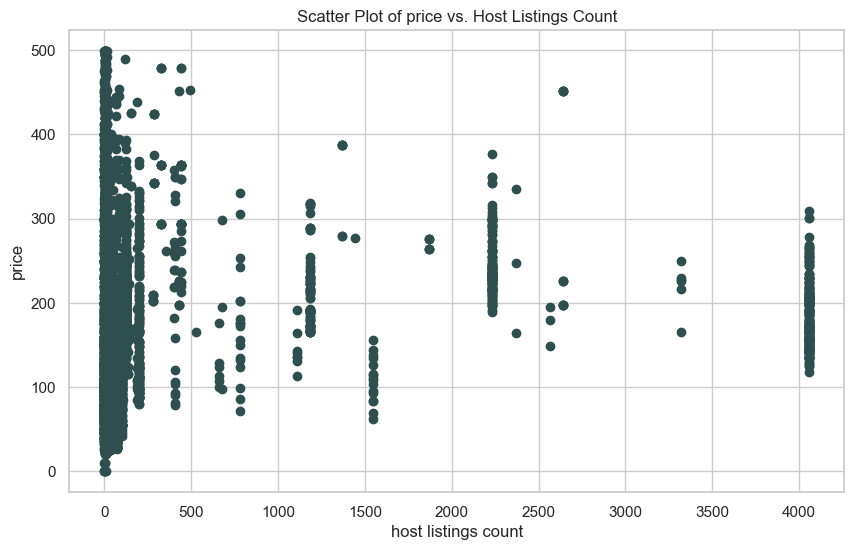

In [172]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_count_below_500.host_listings_count, latest_listings_non_null_host_listings_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count")

plt.show()
plt.close()

This scatterplot is a bit hard to read because of the outlying host counts at 4000+ listings. We can't really see a positive correlation. Let's zoom in to hosts with 0-20 listings.

In [173]:
latest_listings_below_500['host_listings_count_under_20'] = latest_listings_below_500.host_listings_count[latest_listings_below_500.host_listings_count < 20]

In [174]:
latest_listings_non_null_host_listings_under_20_count_below_500 = latest_listings_below_500[latest_listings_below_500["host_listings_count_under_20"].notnull()]

In [175]:
correlation(latest_listings_non_null_host_listings_under_20_count_below_500 , "price", "host_listings_count_under_20")

Correlation coefficients:
r   = 0.03678169211730996 (very weak)
rho = -0.010678801308667132 (very weak)


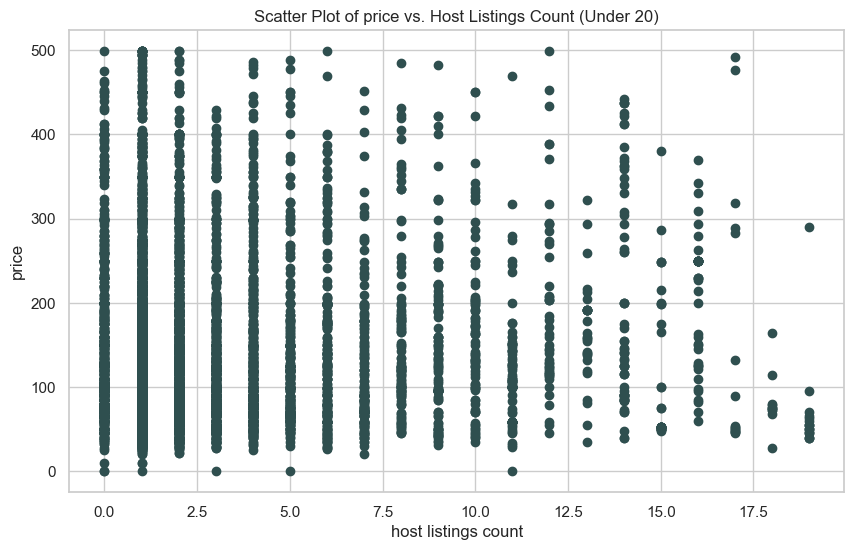

In [176]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_under_20_count_below_500.host_listings_count_under_20, latest_listings_non_null_host_listings_under_20_count_below_500.price, marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of price vs. Host Listings Count (Under 20)")

plt.show()
plt.close()

The scarcity of hosts with more than 5 listings is making this distribution almost appear to be trending downward. However, knowing that most data points exist between 0 and 2.5 listings we see that there is a slight positive correlation.

### `host_total_listings_count` vs `price` <a id="host_total_listings_count_vs_price"></a>

UNUSED

### `host_verifications` vs `price` <a id="host_verifications_vs_price"></a>
In a future iteration, this information could be pulled out in a useful way and explored.

In [177]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

### `host_has_profile_pic` vs `price` <a id="host_has_profile_pic_vs_price"></a>

Hosts are required to have a profile picture. The hosts that don't likely have junk and/or null data. Regardless, hosts with profile pictures could be interpreted as more trustable than hosts without because of the personal element and identity verification element thus I expect a slight positive correlation.

In [178]:
describe_by_category(latest_listings_below_500, "price", "host_has_profile_pic", transpose=True)

host_has_profile_pic       False         True
count                  69.000000  9786.000000
mean                  142.130435   148.837114
std                    97.503380    90.770977
min                     0.000000     0.000000
25%                    80.000000    82.000000
50%                   107.000000   125.000000
75%                   161.000000   196.000000
max                   499.000000   499.000000


There is a ~6 USD difference in mean listing price favoring hosts with a profile picture.

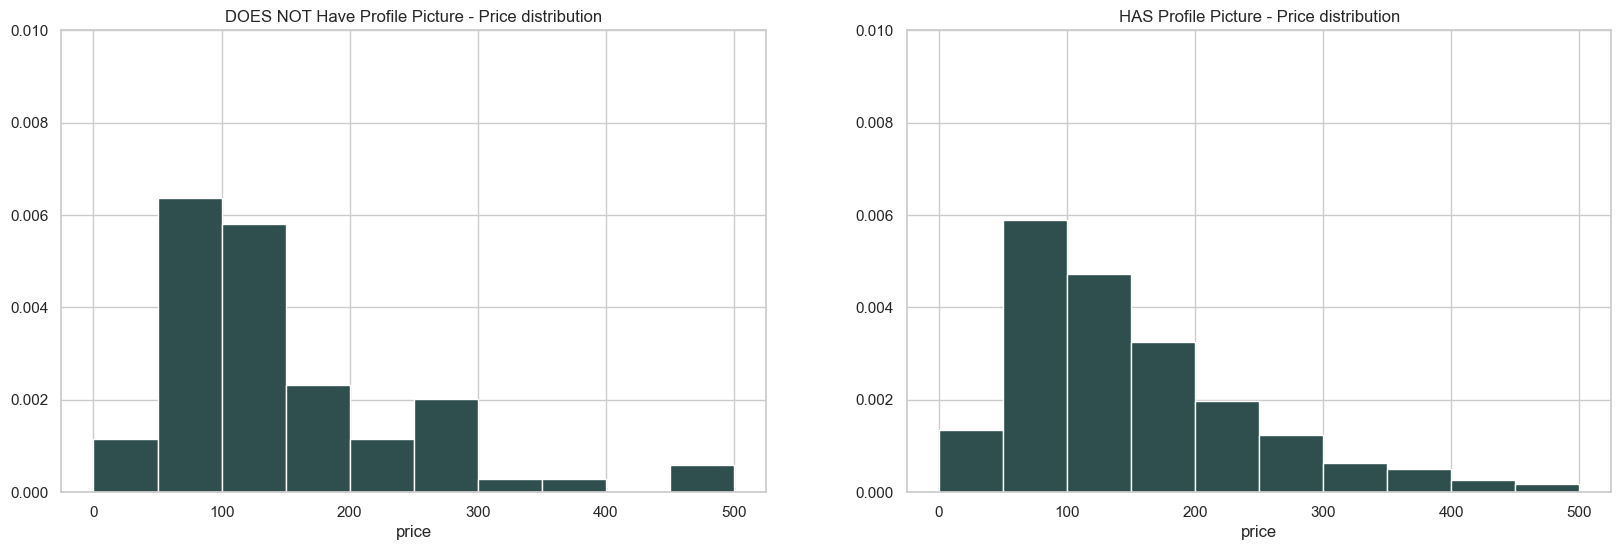

In [179]:
grouped = latest_listings_below_500.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Have Profile Picture - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Profile Picture - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The two groups have similar distributions. There are much fewer host without a profile picture so the distribution looks a bit rougher.

### `host_identity_verified` vs `price` <a id="host_identity_verified_vs_price"></a>

Hosts having their identity verified could be perceived as more trustable and therefore customers might feel more inclined to give them money and they have leverage to increase the price of their listings. For that reason, I expect the correlation to be weak and positive.

In [180]:
describe_by_category(latest_listings_below_500, "price", "host_identity_verified", transpose=True)

host_identity_verified        False         True
count                   1577.000000  8278.000000
mean                     141.034876   150.267577
std                       91.445010    90.626311
min                        0.000000     0.000000
25%                       78.000000    84.000000
50%                      111.000000   126.000000
75%                      179.000000   198.000000
max                      499.000000   499.000000


As expected, the distribution is weak but positive.

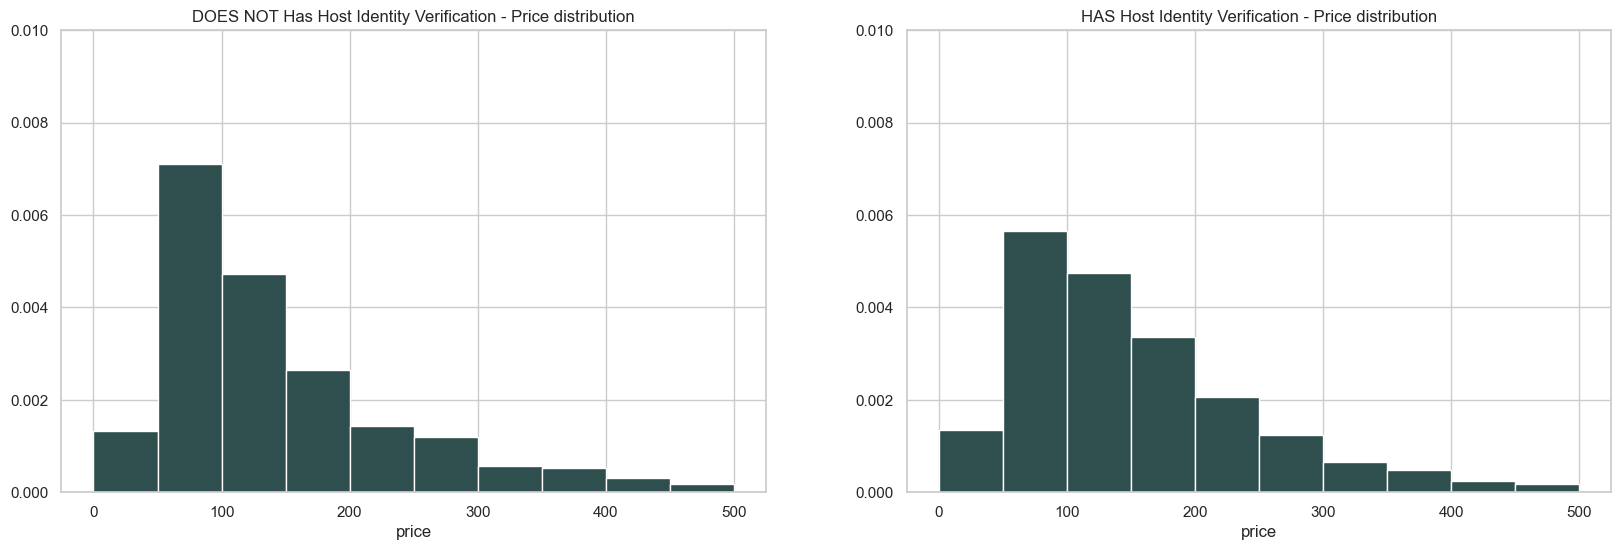

In [181]:
grouped = latest_listings_below_500.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["price"].get_group(False),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("DOES NOT Has Host Identity Verification - Price distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["price"].get_group(True),color="darkslategray",density=True, range=(0,500))
axes.set_ylim((0,0.01))
axes.set_title("HAS Host Identity Verification - Price distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

The distributions for both are unimodal and skewed to the right - both hosts with and without identity verification look very similar in distribution of price.

## Host Information Conclusion

Many of the host information variables have little to no correlation or predictive power with price. A few have very weak to weak correlations that could be potentially useful like
* `host_has_profile_picture`
* `host_acceptance_rate`
* `host_identity_verified`
* `host_listings_count`

And the correlations that we saw with these variables made sense with what we expected from domain knowledge. However, among the above variables with non-negligible correlations, only two have a tolerable either (1) split in category or (2) a reasonable distribution without too many outliers and those are
* `host_listings_count`
* `host_identity_verified`

## <a id='rental_info_v_price'>Rental Information v. Price</a>
In this section, we'll look at the relationship between the room descriptors and the target variable, price.


### <a id="room_type_vs_price">Room Type v. Price </a>

We expect an "entire home/apt" to price higher than a "private" room or "hotel room", which would price higher than a "shared room."


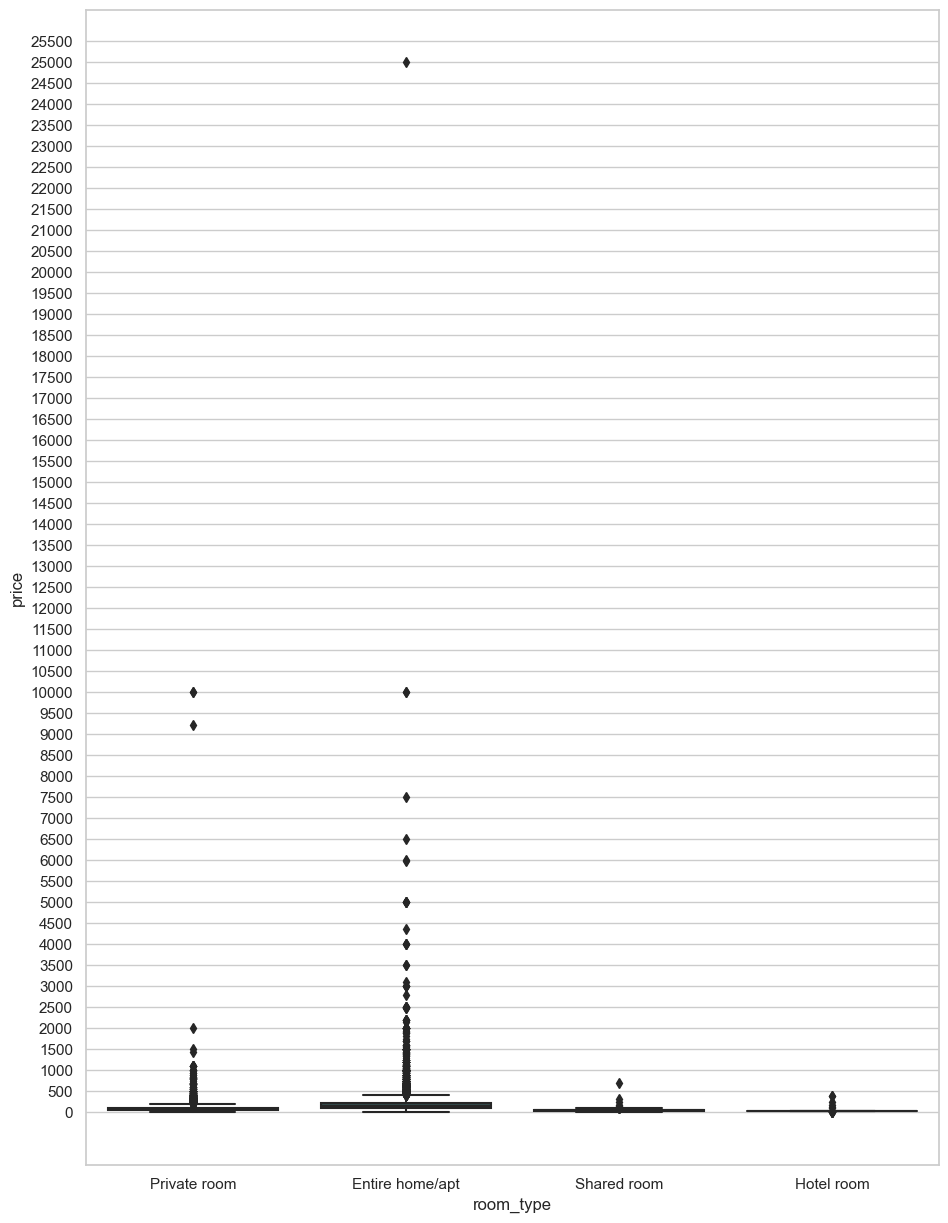

In [182]:
max_plot_price = 26000
fig = plt.figure(figsize=(11,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'room_type', y='price', data = listings_df, color='darkslategray')
ax1.set_yticks(range(0,max_plot_price,500))
plt.show()

The extreme values, especially the $25,000 listing, makes it hard to see the distribution of prices per room type.

These extreme values are real prices, and I am hesitant to throw them out.

We'll zoom into the majority of data points below.

In [183]:

def plot_box_cat(plot_df, x_name, y_name, y_lim, y_step):
    fig = plt.figure(figsize=(9,12))
    ax1 = fig.add_subplot(1,1,1)
    sns.boxplot(x = x_name, y=y_name, data = plot_df, color='darkslategray')
    ax1.set_yticks(range(0,y_lim,y_step))
    ax1.set(ylim=[0,y_lim])
    plt.show()

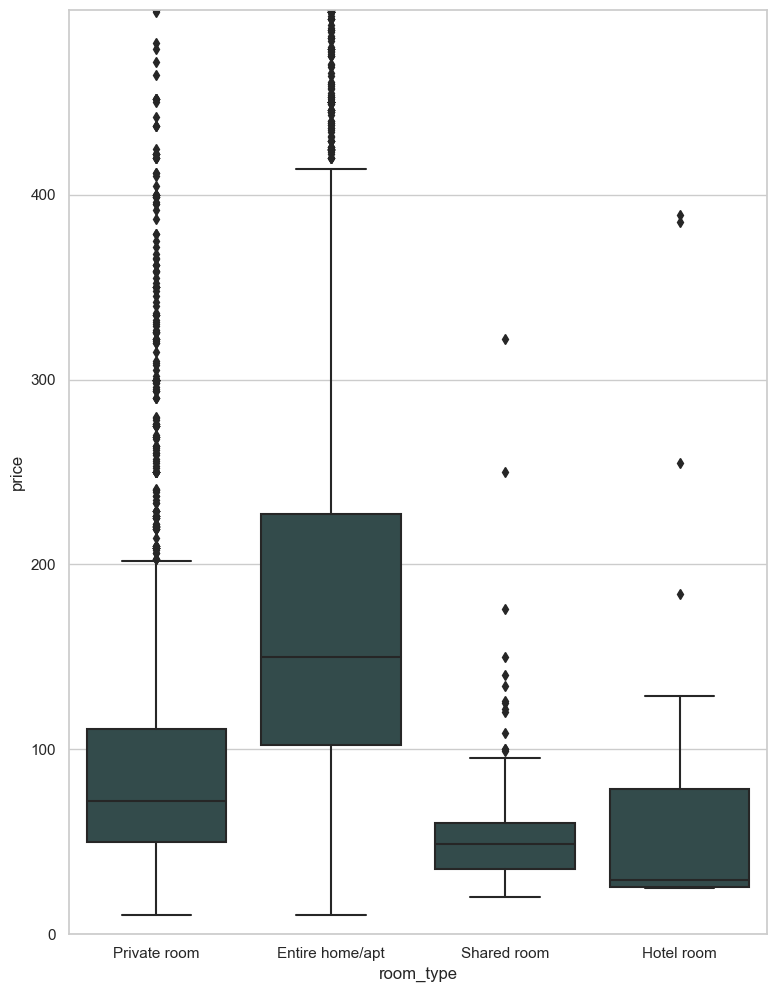

In [184]:
max_plot_price = 500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'room_type', 'price', max_plot_price, 100)



As expected, the Entire home/apt is the most pricey. This is followed by private room. The shared room median is above the hotel room median. I expected the hotel room to follow the private room trend, but it did not. With 28 of the total ~10,500 listings being hotel rooms, we may have too few samples to characterize this.

### <a id='accomodates_v_price'>Accomodates v Price</a>

We expect the price to increase as the maximum accomodation for a listing increases.

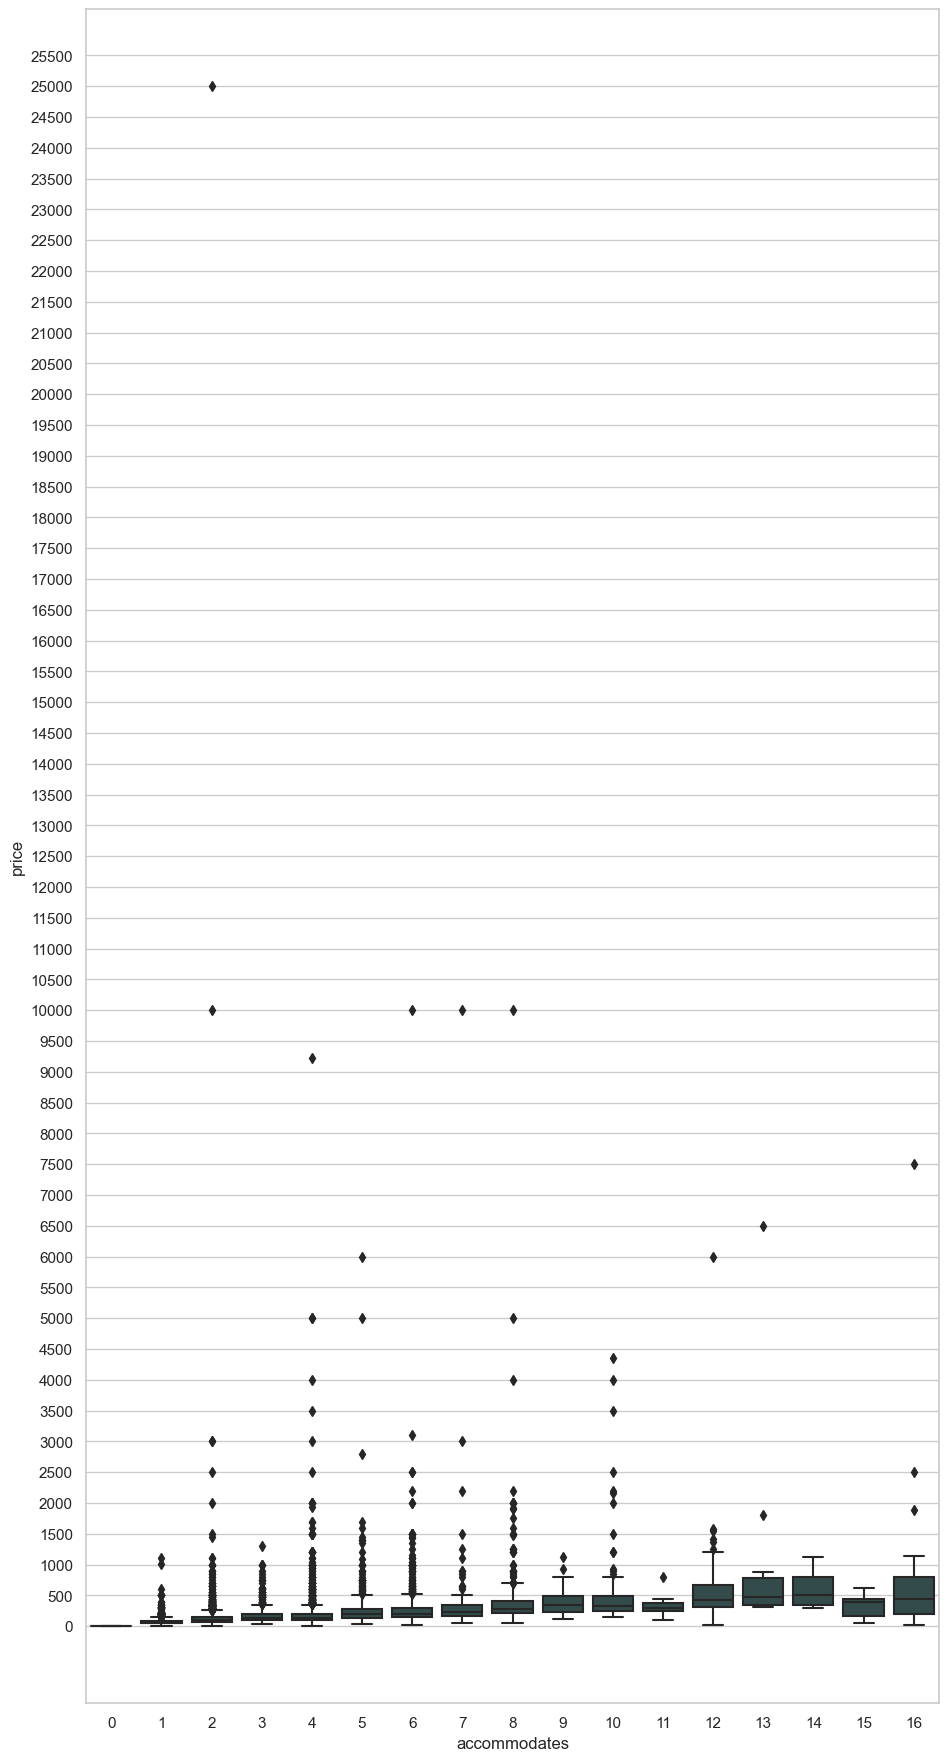

In [185]:
fig = plt.figure(figsize=(11,22))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'accommodates', y='price', data = listings_df, color='darkslategray')
ax1.set_yticks(range(0,26000,500))
plt.show()

Once again, the extreme values make it difficult to see the majority of the distributions. We'll limit the view in the next plot:

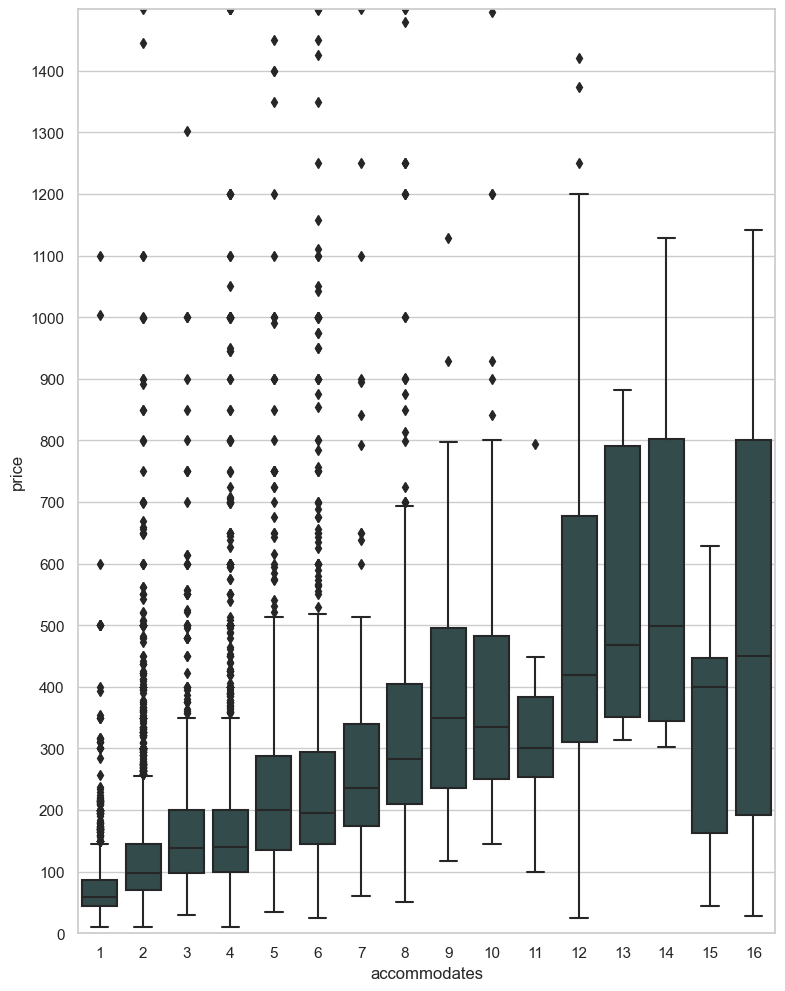

In [186]:
max_plot_price = 1500
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'accommodates', 'price', max_plot_price, 100)


The mean price tends to increase as the maximum accommodations increase. There is a wider distribution of prices as maximum accomodations increases as well. 

There may be another variable that can explain the distribution.

In [187]:
correlation(plot_df, "price", "accommodates")

Correlation coefficients:
r   = 0.23975703067904652 (weak)
rho = 0.5594564264798472 (moderate)


The Pearson's correlation coefficient is .24 (weak), and the spearman's correlation coefficient is .56 (moderate). There is an increasing monotonic relationship.

### <a id='bedrooms_v_price'>Bedrooms v. Price </a>
As with accomodations, we expect the price to increase as the number of bedrooms increases.

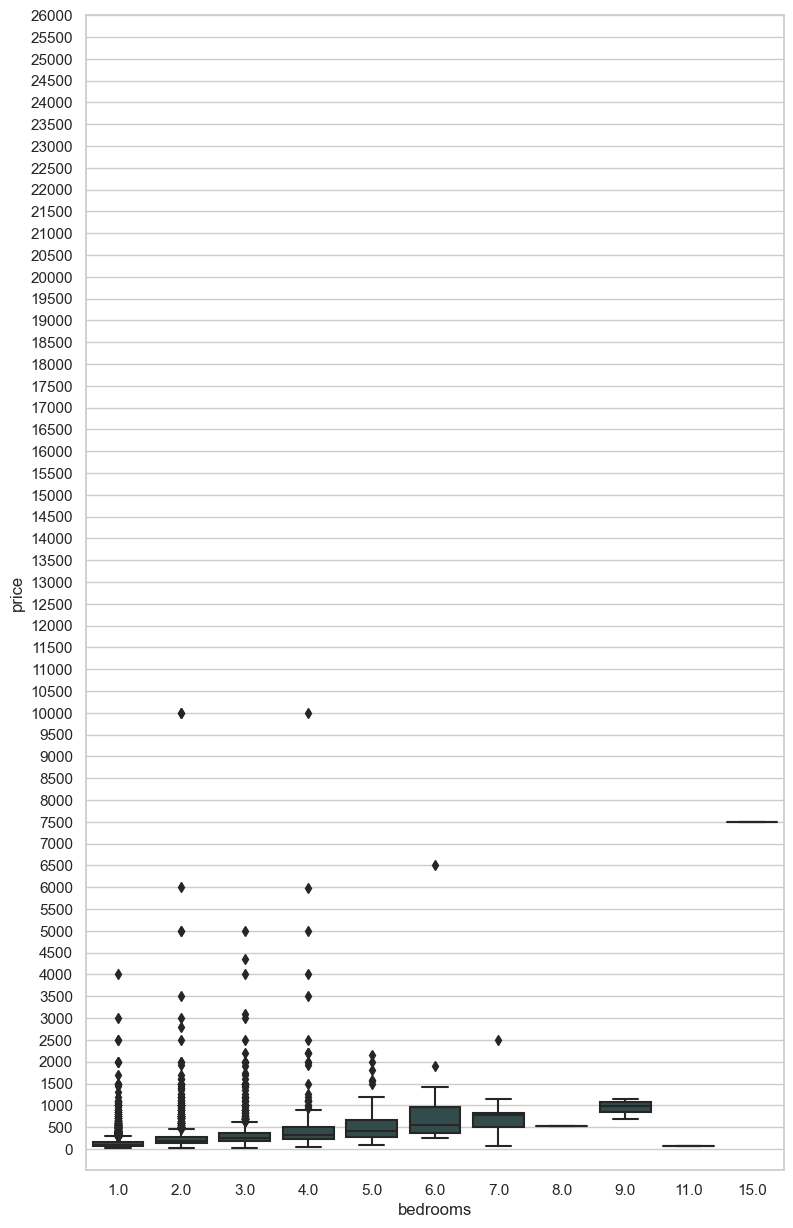

In [188]:
fig = plt.figure(figsize=(9,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'bedrooms', y='price', data = listings_df, color='darkslategray')
ax1.set_yticks(range(0,26500,500))
plt.show()

We can generally see an increase in the overall distribution of prices as we go up in bedrooms until about 8 bedrooms. There are more outliers from 1-4 bedrooms.

It's hard to see the majority if the distributions, so we'll zoom in:

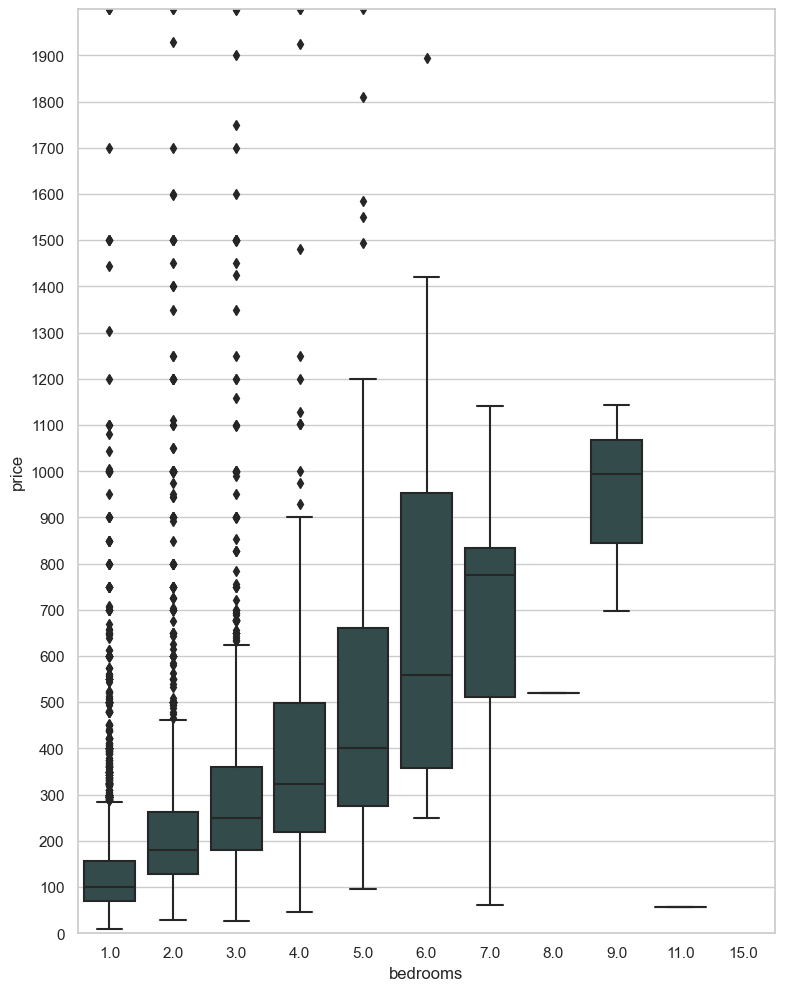

In [189]:
max_plot_price = 2000
#plot_df = listings_df[listings_df.price < max_plot_price]
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'bedrooms', 'price', max_plot_price, 100)


Here we can see rising averages and rising distributions as bedrooms increases.

In [190]:
plot_df = listings_df[listings_df[['price','bedrooms']].notnull().all(1)]

correlation(plot_df, "price", "bedrooms")
plot_df.shape


Correlation coefficients:
r   = 0.3480348197650736 (low)
rho = 0.5373803796400258 (moderate)


(9600, 9)

Here the pearson's correlation coefficient is .35 (low), and the spearman's correlation coefficient is .54 (moderate). This may be a good variable to use in modeling.

Note that there were around 800 rows that did not have data for number of bedrooms.

### <a id='beds_v_price'>Beds v. Price </a>
As with accomodations, we expect the price to increase as the number of beds increases.

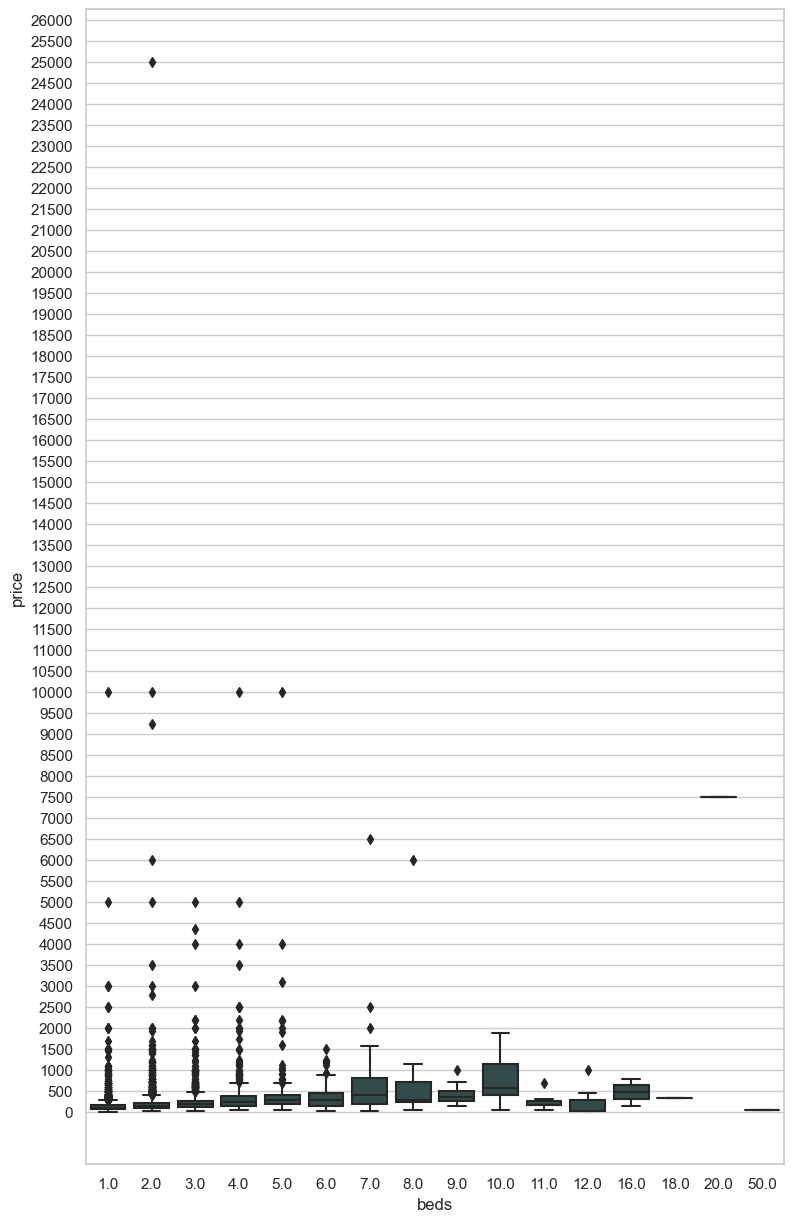

In [191]:
fig = plt.figure(figsize=(9,15))
ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'beds', y='price', data = listings_df, color='darkslategray')
ax1.set_yticks(range(0,26500,500))
plt.show()

Once again, this is difficult to make out due to the outliers compressing the other data in the plot. We'll zoom in further.

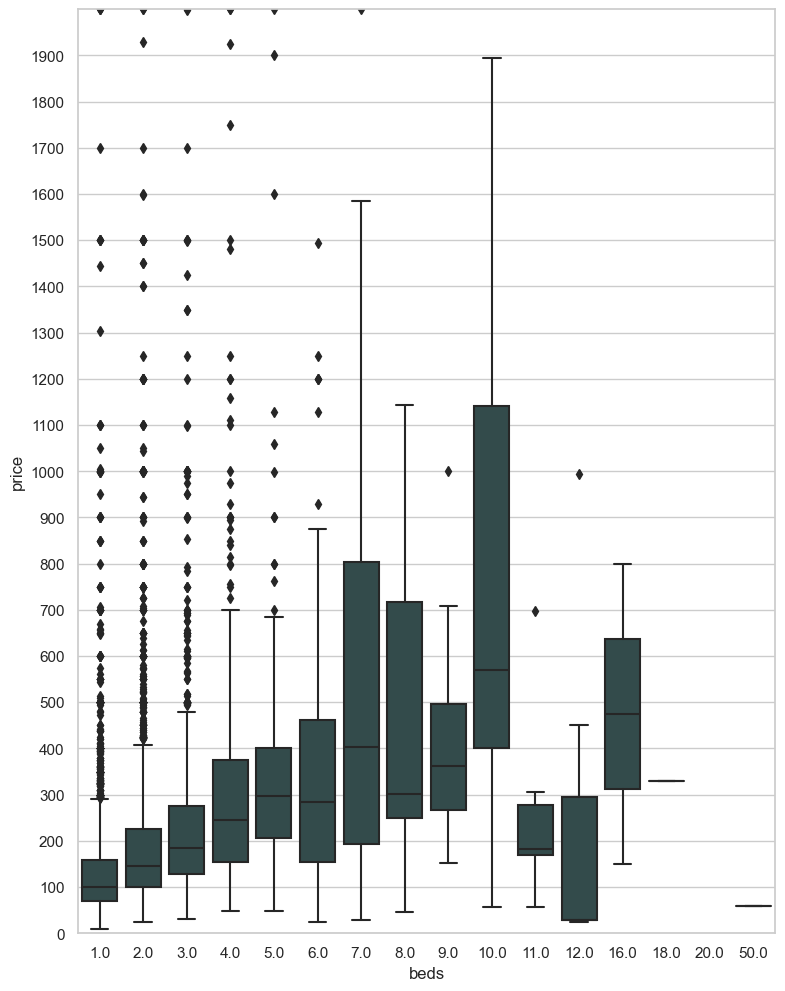

In [192]:
max_plot_price = 2000
plot_df = listings_df[listings_df.price > 0]
plot_box_cat(plot_df, 'beds', 'price', max_plot_price, 100)


This plot looks similar to the number of bedrooms.

In [193]:
plot_df = listings_df[listings_df[['price','beds']].notnull().all(1)]

correlation(plot_df, "price", "beds")
plot_df.shape

Correlation coefficients:
r   = 0.19648876526139203 (weak)
rho = 0.4389629698933788 (low)


(10291, 9)

This shows a weak Pearson's correlation (.2), and a low (.44) Spearman's correlation. The number of bedrooms had higher coefficients for both of these.

### <a id='rental_info_conclusion'>Rental Information Conclusion</a>

#### Room descriptors
* room_type - whole house > room > shared
* accomodates ->+ price
* bathrooms ->+ price  (actuals TBD)
* bedrooms ->+ price
* beds->+ price
* amenities (TBD)  

  
The numeric values are all related: accommodates, bathrooms, bedrooms, beds. The more people you can fit in, the higher the price is generally. The function criteria for "accommodates" isn't listed, but it should be a function of the number of bedrooms and bathrooms. Overall, as these increase, so does price. Of note were the accomodates variable, and the number of bedrooms variable, which yielded moderate Spearman's corellation coefficients.

#### Filters
There were a number of rows that should be thrown away as errors because they cannot be true, and we have no way to correct them in the data. For the following criteria, we will drop the data:
* Price is 0
* Accommodates is 0


## <a id='review_scores_v_price'>Review Scores to Price</a>



### <a id='price_v_review_scores_accuracy'>review_scores_accuracy v. price</a>

The price comparison with review scores accuracy. We have have some null values in our data that we will remove and only look at non-null reviews.

In [194]:
latest_listings_review_scores_accuracy = latest_listings[latest_listings[["review_scores_rating"]].notnull().all(1)]

Let's look at the correlation coefficient.

In [195]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_accuracy.price, latest_listings_review_scores_accuracy.review_scores_rating)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_accuracy.price, latest_listings_review_scores_accuracy.review_scores_rating)[0])

r   =  -0.0105822256939008
rho =  0.07745461501588657


Pearson's correlation coefficient, $r$, is only -0.01 which indicates a weak inverse relationship. Spearman's is interesting at 0.07 which might indicate that there is least a weak monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

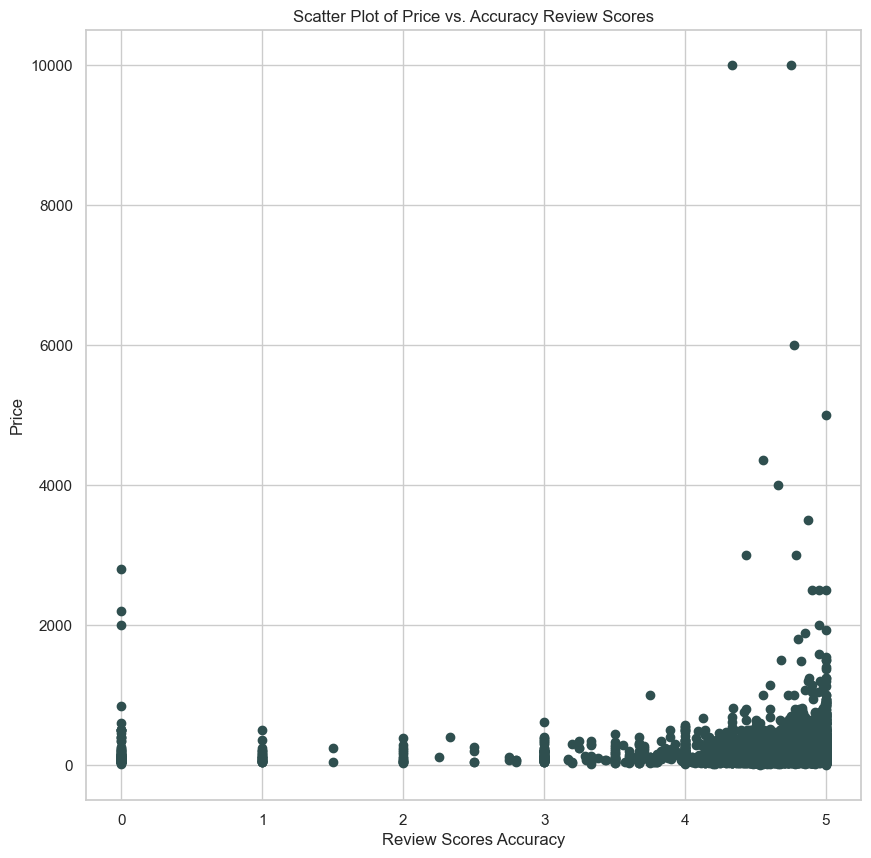

In [196]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_accuracy.review_scores_rating, latest_listings_review_scores_accuracy.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Accuracy")
axes.set_title("Scatter Plot of Price vs. Accuracy Review Scores")

plt.show()
plt.close()

We can see a slight pattern as review score goes up we see price going up, but it mostly it looks very uniform. 

### <a id='review_scores_cleanliness_v_price'>review_scores_cleanliness v. price </a>

The price comparison with review scores cleanliness. We have have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [197]:
latest_listings_review_scores_cleanliness = latest_listings[latest_listings[["review_scores_cleanliness"]].notnull().all(1)]

In [198]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_cleanliness.price, latest_listings_review_scores_cleanliness.review_scores_cleanliness)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_cleanliness.price, latest_listings_review_scores_cleanliness.review_scores_cleanliness)[0])

r   =  0.025898444513533313
rho =  0.10561959800641402


Pearson's correlation coefficient, 𝑟 , is only 0.02 which indicates a weak relationship. Spearman's is interesting at 0.105 which might indicate a monotonic relationship. This is interesting because it means that as cleanliness scores go up price goes up.

I think that does make sense, as cleaning fees have become very pricey in AirBnB and has led to a lot of backlash for the service. It would seem plausible that a listing that is clean enough to earn a high score charges more for due to the additional costs to clean the listing to such a high standard.

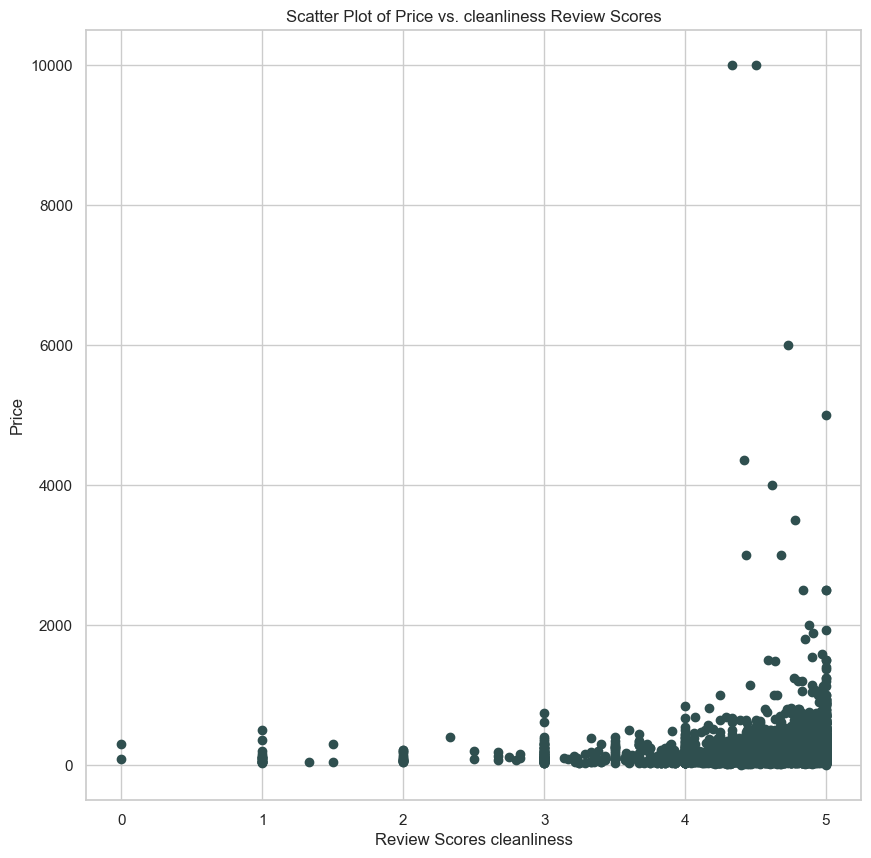

In [199]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_cleanliness.review_scores_cleanliness, latest_listings_review_scores_cleanliness.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores cleanliness")
axes.set_title("Scatter Plot of Price vs. cleanliness Review Scores")

plt.show()
plt.close()

These are all very similar graphics due to the way the ratings are all very similar as we saw from EDA.

### <a id='review_scores_checkin_v_price'>review_scores_checkin v price</a>

The price comparison to checkin reviews. We have have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [200]:
latest_listings_review_scores_checkin = latest_listings[latest_listings[["review_scores_checkin"]].notnull().all(1)]

In [201]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_checkin.price, latest_listings_review_scores_checkin.review_scores_checkin)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_checkin.price, latest_listings_review_scores_checkin.review_scores_checkin)[0])

r   =  0.007325971384927467
rho =  0.03134393309356987


Pearson's correlation coefficient, 𝑟 , is only 0.007 which indicates an extremely weak relationship. Spearman's is slightly higher at 0.031 which might indicate a weak monotonic relationship. I think checkin factors into price but it is very small, because most checkin processes are not that difficult. Like at a hotel, checkin process tends to be a very standard and unexciting process.

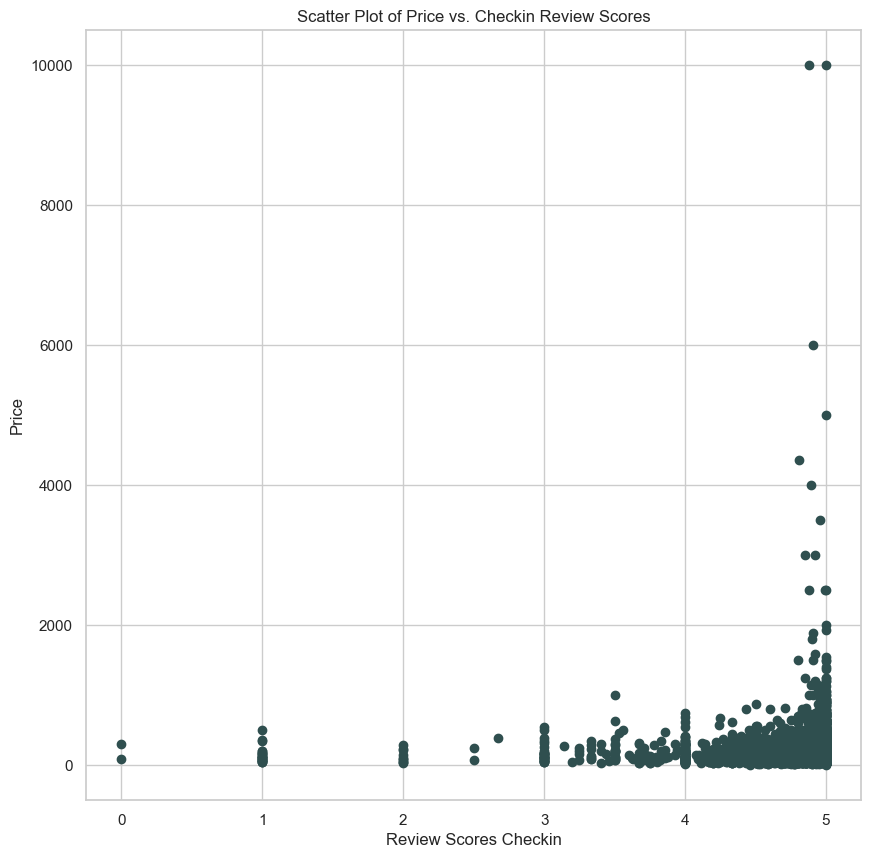

In [202]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_checkin.review_scores_checkin, latest_listings_review_scores_checkin.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Checkin")
axes.set_title("Scatter Plot of Price vs. Checkin Review Scores")

plt.show()
plt.close()

The pattern is very similar to the other variables. The effect is so small we don't observe it from the data.

### <a id='review_scores_communication_v_price'>review_scores_communication v. price</a>

The price comparison to communication reviews. We have have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [203]:
latest_listings_review_scores_communication = latest_listings[latest_listings[["review_scores_communication"]].notnull().all(1)]

In [204]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_communication.price, latest_listings_review_scores_communication.review_scores_communication)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_communication.price, latest_listings_review_scores_communication.review_scores_communication)[0])

r   =  0.0031412207072375217
rho =  0.015591363504826119


Pearson's correlation coefficient, 𝑟 , is only 0.0031 which indicates an extremely weak relationship. Spearman's is interesting at 0.01 which might indicate a very weak monotonic relationship. This score impacts prices a little more than checkin. My assumption is that communication is important, but much of that interaction happens via existing documents that a host provides in the home and through the app.

The recommendation from AirBnB is that hosts provide most relevant information in document form such as WiFi passwords, etc...This reduces the amount of actual communication with the host, thus leading to only brief interactions.

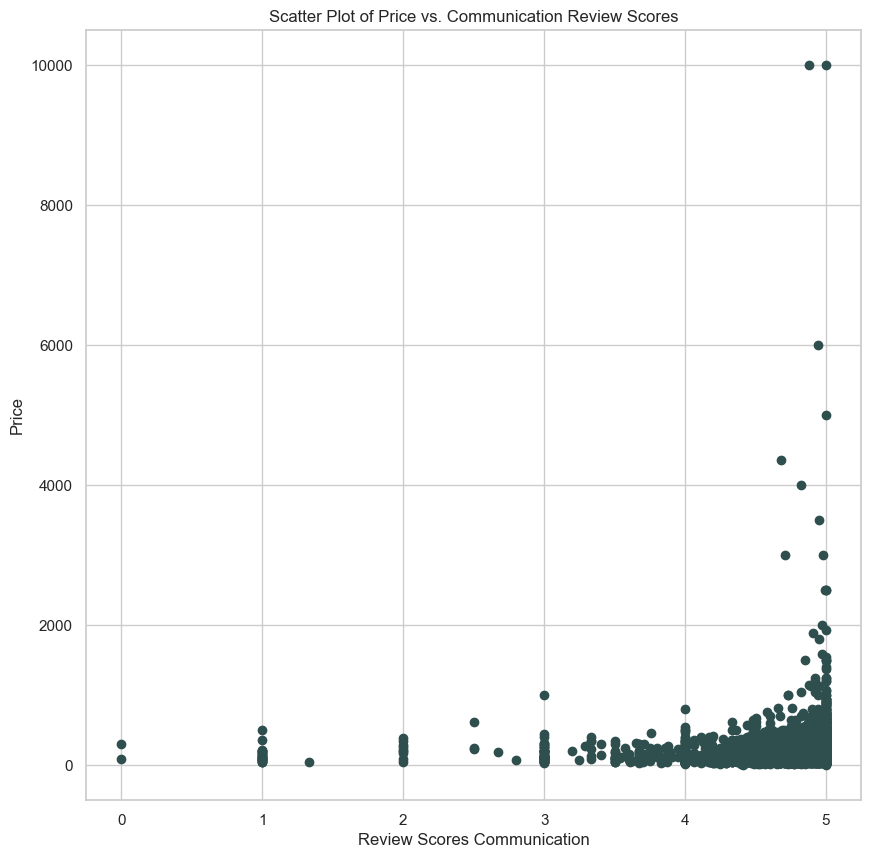

In [205]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_communication.review_scores_communication, latest_listings_review_scores_communication.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Communication")
axes.set_title("Scatter Plot of Price vs. Communication Review Scores")

plt.show()
plt.close()

This graph shows a inclined slope as scores increase from 4 - 5, we see our prices increase as well, but only slightly for a small grouping of listings.

### <a id='review_scores_location_v_price'>review_scores_location v. price </a>

The price comparison to location reviews. This is an important variable for our analysis because we predict that it has the most impact on price. Our assumption is that a lot of different qualities of an AirBnB is captured in the location. We have have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [206]:
latest_listings_review_scores_location = latest_listings[latest_listings[["review_scores_location"]].notnull().all(1)]

In [207]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_location.price, latest_listings_review_scores_location.review_scores_location)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_location.price, latest_listings_review_scores_location.review_scores_location)[0])

r   =  0.056984325513637246
rho =  0.1973334679991015


Pearson's correlation coefficient, 𝑟 , is 0.05 which indicates a weak relationship, however it is higher than some of our other review variables. Spearman's is interesting at 0.19 which indicates a moderate monotonic relationship. I think this confirms our assumption that location is very important in the pricing strategy of an AirBnB and thus the location review score captures that more clearly.

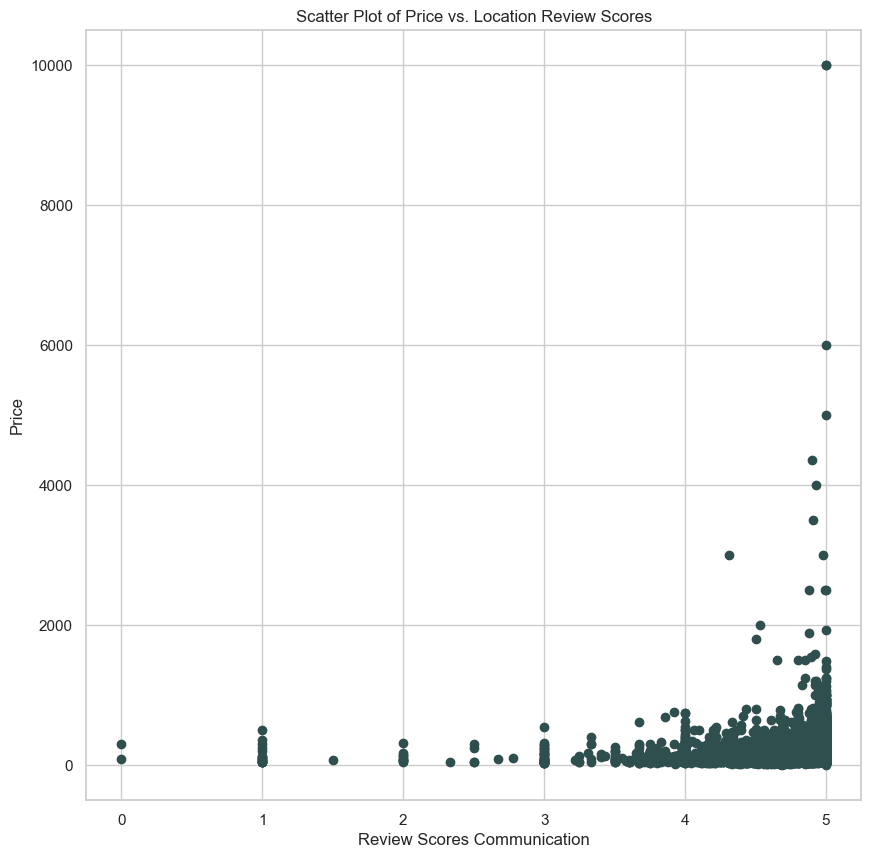

In [208]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_location.review_scores_location, latest_listings_review_scores_location.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Communication")
axes.set_title("Scatter Plot of Price vs. Location Review Scores")

plt.show()
plt.close()

This graph shows a inclined slope as scores increase from 4 - 5, we see our prices increase as well, but only slightly for a small grouping of listings.

### <a id='review_scores_value_v_price'>review_scores_value v. price</a>

The price comparison to value reviews. We have have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [209]:
latest_listings_review_scores_value = latest_listings[latest_listings[["review_scores_value"]].notnull().all(1)]

In [210]:
print("r   = ", stats.pearsonr(latest_listings_review_scores_value.price, latest_listings_review_scores_value.review_scores_value)[0])
print("rho = ", stats.spearmanr(latest_listings_review_scores_value.price, latest_listings_review_scores_value.review_scores_value)[0])

r   =  -0.00832520722754418
rho =  -0.02714469810249014


Pearson's correlation coefficient, 𝑟 , is only -0.008 which indicates a weak inverse relationship. Spearman's is interesting at -0.027 which indicates a very weak inverse monotonic relationship. This is interesting because it means that as the value score decrease the price increase. I think makes sense from a 'value' perspective, most guests would consider a range of prices that undercuts hotels or other lodging options, thus that would indicate higher value and a lower price.

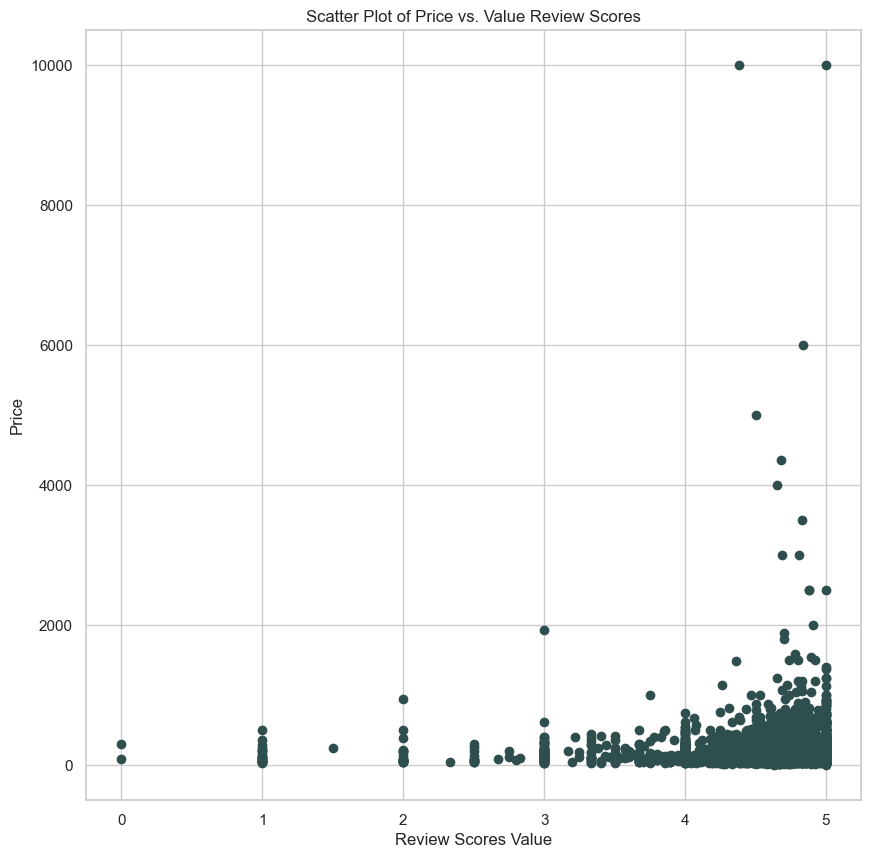

In [211]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_review_scores_value.review_scores_value, latest_listings_review_scores_value.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Value")
axes.set_title("Scatter Plot of Price vs. Value Review Scores")

plt.show()
plt.close()

### <a id='number_of_reviews_v_price '>number_of_reviews v price </a>

The price comparison to number of reviews. We have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [212]:
latest_listings_number_of_reviews = latest_listings[latest_listings[["number_of_reviews"]].notnull().all(1)]

In [213]:
print("r   = ", stats.pearsonr(latest_listings_number_of_reviews.price, latest_listings_number_of_reviews.number_of_reviews)[0])
print("rho = ", stats.spearmanr(latest_listings_number_of_reviews.price, latest_listings_number_of_reviews.number_of_reviews)[0])

r   =  -0.05603365411307578
rho =  -0.15113808981420673


Pearson's correlation coefficient, 𝑟 , is only -0.056 which indicates a weak inverse relationship. Spearman's is interesting at -0.15 which indicates a very weak inverse monotonic relationship. It's strange that as we have more reviews price goes down. I wonder if that indicates that as a listing gains more reviews and thus more guest, the revenue generated by the host allows them to lower their prices.

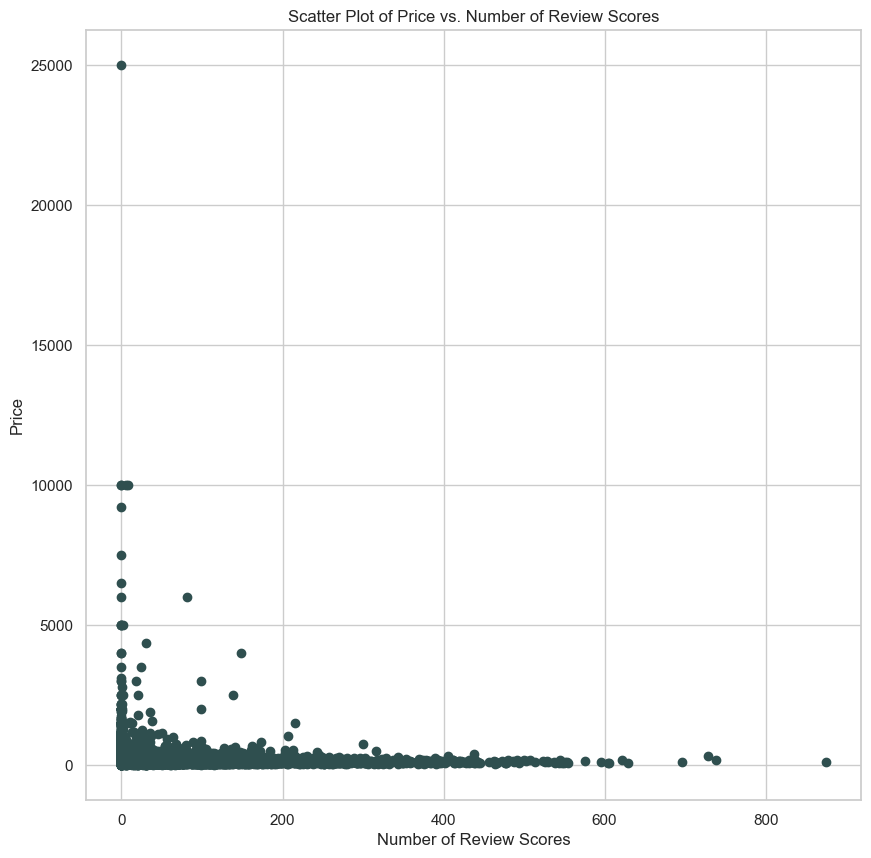

In [214]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_number_of_reviews.number_of_reviews, latest_listings_number_of_reviews.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Review Scores")
axes.set_title("Scatter Plot of Price vs. Number of Review Scores")

plt.show()
plt.close()

This graph showcases very clearly what we got above with the coefficients. There is a decline in price as the number of review scores increase.

### <a id='number_of_reviews_l30d_v_price'>number_of_reviews_l30d v. price</a>

The price comparison to number of reviews in the last 30 days. We have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [215]:
latest_listings_number_of_reviews_l30d = latest_listings[latest_listings[["number_of_reviews"]].notnull().all(1)]

In [216]:
print("r   = ", stats.pearsonr(latest_listings_number_of_reviews_l30d.price, latest_listings_number_of_reviews_l30d.number_of_reviews_l30d)[0])
print("rho = ", stats.spearmanr(latest_listings_number_of_reviews_l30d.price, latest_listings_number_of_reviews_l30d.number_of_reviews_l30d)[0])

r   =  -0.038392251877214
rho =  -0.024724854697841612


Pearson's correlation coefficient, 𝑟 , is only -0.038 which indicates a weak inverse relationship. Spearman's is interesting at -0.025 which indicates there is a weak inverse monotonic relationship.  

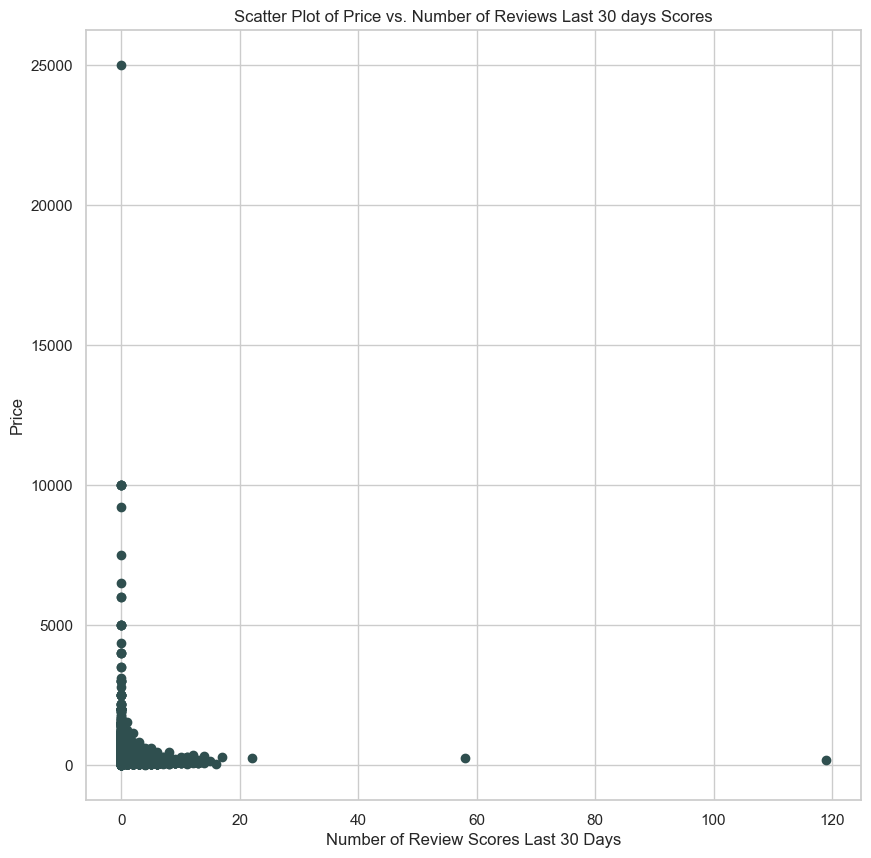

In [217]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_number_of_reviews_l30d.number_of_reviews_l30d, latest_listings_number_of_reviews_l30d.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Review Scores Last 30 Days")
axes.set_title("Scatter Plot of Price vs. Number of Reviews Last 30 days Scores")

plt.show()
plt.close()

This graph showcases very clearly what we got above with the coefficients. There is a decline in price as the number of review scores in the last 30 days increase. It does track with our analysis of the total reviews to price that we previously saw.

### <a id='reviews_per_month_v_price'> reviews_per_month v. price</a>

The price comparison to number of reviews per month. We have some null values in our data that we will remove and only look at non-null reviews.

Let's look at the correlation coefficient.

In [218]:
latest_listings_reviews_per_month = latest_listings[latest_listings[["reviews_per_month"]].notnull().all(1)]

In [219]:
print("r   = ", stats.pearsonr(latest_listings_reviews_per_month.price, latest_listings_reviews_per_month.reviews_per_month)[0])
print("rho = ", stats.spearmanr(latest_listings_reviews_per_month.price, latest_listings_reviews_per_month.reviews_per_month)[0])

r   =  -0.01878010369013164
rho =  0.0951775273308491


Pearson's correlation coefficient, 𝑟 , is only -0.019 which indicates an extremely weak inverse relationship. Spearman's is interesting at 0.096 which indicates a weak monotonic relationship. Similar to what we saw in other nominal review totals. 

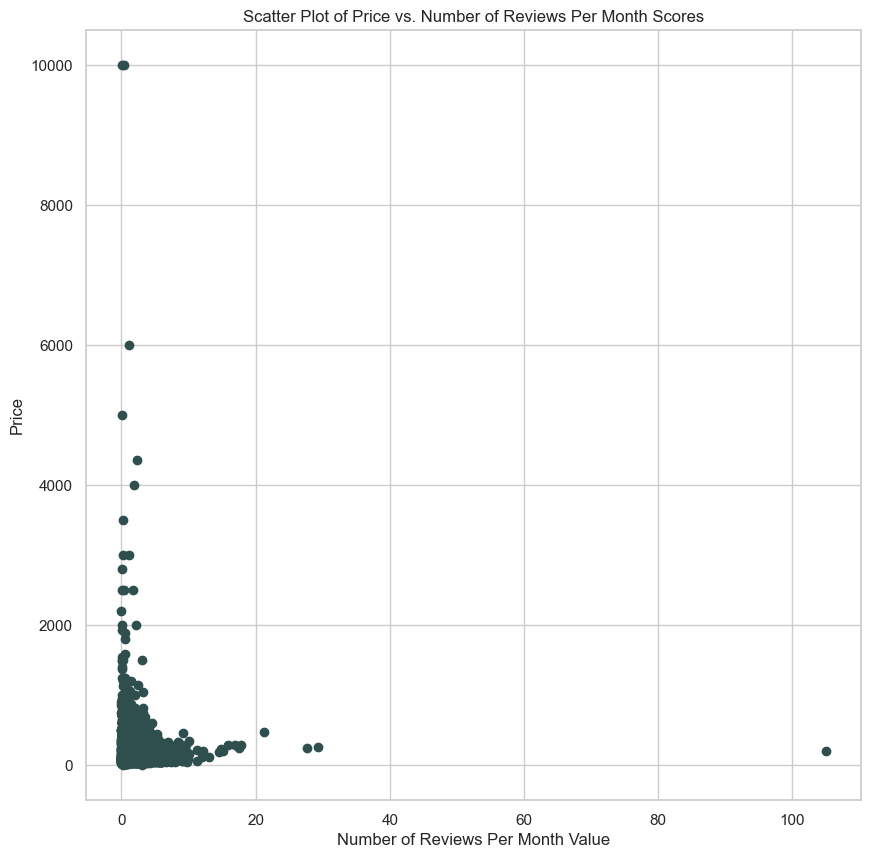

In [220]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(latest_listings_reviews_per_month.reviews_per_month, latest_listings_reviews_per_month.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews Per Month Value")
axes.set_title("Scatter Plot of Price vs. Number of Reviews Per Month Scores")

plt.show()
plt.close()

## <a id='calendar_v_price'>Calendar Information v. Price</a>


### <a id='cal_data_v_price'>Calendar Data v. Price Conclusion</a>

The calendar data didn't yield any obvious relationships to price. For more information about calendar information, see the EDA notebook (eda.ipynb).


## <a id='crimes_v_price'>Crimes v. Price</a>
We expect that areas with higher crime will be less desirable, leading to a lower price. There is the possibility that areas more heavily affected by crime will not be represented in the data set, resulting in a survivorship bias.

### `total crimes` vs `price` <a id="total_crimes_vs_price"></a>
[back to list](#pairwise)

The first comparison of crime and price will be the total count of crimes per neighborhood to price. 

In [221]:
rel = con.execute("select * from crimes")
crimes = rel.df()

In [222]:
crimes

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0             0           cluster 25      violent -77.002778   
1             1           cluster 26      violent -76.997326   
2             2           cluster 35      violent -76.964260   
3             3           cluster 39      violent -76.999896   
4             4            cluster 2     property -77.025347   
...         ...                  ...          ...        ...   
27606     27606            cluster 1     property -77.042324   
27607     27607            cluster 1     property -77.042369   
27608     27608           cluster 26     property -76.994963   
27609     27609           cluster 11     property -77.081165   
27610     27610           cluster 25     property -77.001314   

                     END_DATE                offense-text     SHIFT  \
0        9/7/2021, 2:18:00 PM                    homicide  midnight   
1       10/3/2021, 3:20:00 PM                     robbery   evening   
2       10/3/2021, 6:40:00 PM                     robbery   evening   
3      10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4      10/2/2021, 11:01:00 PM                theft f/auto   evening   
...                       ...                         ...       ...   
27606   7/21/2022, 7:00:00 PM                 theft/other  midnight   
27607   8/12/2022, 6:30:00 AM                 theft/other  midnight   
27608   8/12/2022, 9:00:00 AM                theft f/auto  midnight   
27609   5/31/2022, 7:00:00 AM                theft f/auto       day   
27610  5/31/2022, 11:37:00 AM                theft f/auto       day   

                               offensekey START_DATE  \
0                        violent|homicide 2021-09-07   
1                         violent|robbery 2021-10-03   
2                         violent|robbery 2021-10-03   
3      violent|assault w/dangerous weapon 2021-10-11   
4                   property|theft f/auto 2021-10-02   
...                                   ...        ...   
27606                property|theft/other 2022-07-21   
27607                property|theft/other 2022-08-11   
27608               property|theft f/auto 2022-08-12   
27609               property|theft f/auto 2022-05-26   
27610               property|theft f/auto 2022-05-27   

                          OFFENSE  METHOD   LATITUDE  \
0                        homicide  others  38.897331   
1                         robbery  others  38.881269   
2                         robbery     gun  38.858661   
3      assault w/dangerous weapon  others  38.831632   
4                    theft f/auto  others  38.922290   
...                           ...     ...        ...   
27606                 theft/other  others  38.926303   
27607                 theft/other  others  38.924303   
27608                theft f/auto  others  38.891322   
27609                theft f/auto  others  38.955947   
27610                theft f/auto  others  38.898907   

                                       NEIGHBORHOOD_NAME  
0              Union Station, Stanton Park, Kingman Park  
1                             Capitol Hill, Lincoln Park  
2      Fairfax Village, Naylor Gardens, Hillcrest, Su...  
3       Congress Heights, Bellevue, Washington Highlands  
4      Columbia Heights, Mt. Pleasant, Pleasant Plain...  
...                                                  ...  
27606     Kalorama Heights, Adams Morgan, Lanier Heights  
27607     Kalorama Heights, Adams Morgan, Lanier Heights  
27608                         Capitol Hill, Lincoln Park  
27609  Friendship Heights, American University Park, ...  
27610          Union Station, Stanton Park, Kingman Park  

[27611 rows x 13 columns]

A new column is added that has the count of crimes for each neighborhood.

In [223]:
crimes["total_crimes"] = crimes.groupby("NEIGHBORHOOD_NAME")["NEIGHBORHOOD_NAME"].transform('count')

In [224]:
crimes

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0             0           cluster 25      violent -77.002778   
1             1           cluster 26      violent -76.997326   
2             2           cluster 35      violent -76.964260   
3             3           cluster 39      violent -76.999896   
4             4            cluster 2     property -77.025347   
...         ...                  ...          ...        ...   
27606     27606            cluster 1     property -77.042324   
27607     27607            cluster 1     property -77.042369   
27608     27608           cluster 26     property -76.994963   
27609     27609           cluster 11     property -77.081165   
27610     27610           cluster 25     property -77.001314   

                     END_DATE                offense-text     SHIFT  \
0        9/7/2021, 2:18:00 PM                    homicide  midnight   
1       10/3/2021, 3:20:00 PM                     robbery   evening   
2       10/3/2021, 6:40:00 PM                     robbery   evening   
3      10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4      10/2/2021, 11:01:00 PM                theft f/auto   evening   
...                       ...                         ...       ...   
27606   7/21/2022, 7:00:00 PM                 theft/other  midnight   
27607   8/12/2022, 6:30:00 AM                 theft/other  midnight   
27608   8/12/2022, 9:00:00 AM                theft f/auto  midnight   
27609   5/31/2022, 7:00:00 AM                theft f/auto       day   
27610  5/31/2022, 11:37:00 AM                theft f/auto       day   

                               offensekey START_DATE  \
0                        violent|homicide 2021-09-07   
1                         violent|robbery 2021-10-03   
2                         violent|robbery 2021-10-03   
3      violent|assault w/dangerous weapon 2021-10-11   
4                   property|theft f/auto 2021-10-02   
...                                   ...        ...   
27606                property|theft/other 2022-07-21   
27607                property|theft/other 2022-08-11   
27608               property|theft f/auto 2022-08-12   
27609               property|theft f/auto 2022-05-26   
27610               property|theft f/auto 2022-05-27   

                          OFFENSE  METHOD   LATITUDE  \
0                        homicide  others  38.897331   
1                         robbery  others  38.881269   
2                         robbery     gun  38.858661   
3      assault w/dangerous weapon  others  38.831632   
4                    theft f/auto  others  38.922290   
...                           ...     ...        ...   
27606                 theft/other  others  38.926303   
27607                 theft/other  others  38.924303   
27608                theft f/auto  others  38.891322   
27609                theft f/auto  others  38.955947   
27610                theft f/auto  others  38.898907   

                                       NEIGHBORHOOD_NAME  total_crimes  
0              Union Station, Stanton Park, Kingman Park          2070  
1                             Capitol Hill, Lincoln Park          1095  
2      Fairfax Village, Naylor Gardens, Hillcrest, Su...           315  
3       Congress Heights, Bellevue, Washington Highlands           990  
4      Columbia Heights, Mt. Pleasant, Pleasant Plain...          1788  
...                                                  ...           ...  
27606     Kalorama Heights, Adams Morgan, Lanier Heights           729  
27607     Kalorama Heights, Adams Morgan, Lanier Heights           729  
27608                         Capitol Hill, Lincoln Park          1095  
27609  Friendship Heights, American University Park, ...           365  
27610          Union Station, Stanton Park, Kingman Park          2070  

[27611 rows x 14 columns]

Next we want to be able to compare prices to crime so we have to add prices to the same dataframe. As the listing ids aren't going to be useful for the crimes database, the average for each neighborhood will be used. Any rows with NAs are dropped. 

In [225]:
prices = latest_listings[["id", "price", "neighbourhood_cleansed"]]
prices = prices.dropna()
prices

id  price  \
0                    3686   67.0   
1                  841260   39.0   
2                    3943   75.0   
3                  842418  250.0   
4                  860336  113.0   
...                   ...    ...   
10555  574415195460129986  235.0   
10556  582832241528964793  110.0   
10557  552672006345399432  207.0   
10558            48252468  192.0   
10559  578751728298235973  237.0   

                                  neighbourhood_cleansed  
0                                     Historic Anacostia  
1                   Brightwood Park, Crestwood, Petworth  
2      Edgewood, Bloomingdale, Truxton Circle, Eckington  
3      Downtown, Chinatown, Penn Quarters, Mount Vern...  
4             Dupont Circle, Connecticut Avenue/K Street  
...                                                  ...  
10555                                 Shaw, Logan Circle  
10556          Union Station, Stanton Park, Kingman Park  
10557  Colonial Village, Shepherd Park, North Portal ...  
10558  Colonial Village, Shepherd Park, North Portal ...  
10559                                 Shaw, Logan Circle  

[10560 rows x 3 columns]

A new column is added:

In [226]:
prices["avg_price"] = prices.groupby("neighbourhood_cleansed")["price"].transform("mean")
prices

id  price  \
0                    3686   67.0   
1                  841260   39.0   
2                    3943   75.0   
3                  842418  250.0   
4                  860336  113.0   
...                   ...    ...   
10555  574415195460129986  235.0   
10556  582832241528964793  110.0   
10557  552672006345399432  207.0   
10558            48252468  192.0   
10559  578751728298235973  237.0   

                                  neighbourhood_cleansed   avg_price  
0                                     Historic Anacostia  151.233766  
1                   Brightwood Park, Crestwood, Petworth  142.733591  
2      Edgewood, Bloomingdale, Truxton Circle, Eckington  171.148545  
3      Downtown, Chinatown, Penn Quarters, Mount Vern...  254.383929  
4             Dupont Circle, Connecticut Avenue/K Street  262.198238  
...                                                  ...         ...  
10555                                 Shaw, Logan Circle  223.815951  
10556          Union Station, Stanton Park, Kingman Park  213.681243  
10557  Colonial Village, Shepherd Park, North Portal ...  144.356784  
10558  Colonial Village, Shepherd Park, North Portal ...  144.356784  
10559                                 Shaw, Logan Circle  223.815951  

[10560 rows x 4 columns]

Only using the relevant columns and removing duplicates:

In [227]:
price_neigh  = prices[["neighbourhood_cleansed", "avg_price"]]
price_neigh = price_neigh.drop_duplicates()
price_neigh

neighbourhood_cleansed   avg_price
0                                   Historic Anacostia  151.233766
1                 Brightwood Park, Crestwood, Petworth  142.733591
2    Edgewood, Bloomingdale, Truxton Circle, Eckington  171.148545
3    Downtown, Chinatown, Penn Quarters, Mount Vern...  254.383929
4           Dupont Circle, Connecticut Avenue/K Street  262.198238
5       Howard University, Le Droit Park, Cardozo/Shaw  203.638961
6                             Douglas, Shipley Terrace  161.063830
7                           Capitol Hill, Lincoln Park  230.157343
8    Lamont Riggs, Queens Chapel, Fort Totten, Plea...  132.696970
9    Friendship Heights, American University Park, ...  157.533333
11      Kalorama Heights, Adams Morgan, Lanier Heights  157.829480
12   Columbia Heights, Mt. Pleasant, Pleasant Plain...  155.922889
14      Ivy City, Arboretum, Trinidad, Carver Langston  166.836812
19                                  Shaw, Logan Circle  223.815951
23                         West End, Foggy Bottom, GWU  273.766871
25                       Brookland, Brentwood, Langdon  130.921053
27      Cathedral Heights, McLean Gardens, Glover Park  370.658915
28                      Takoma, Brightwood, Manor Park  161.151163
38           Union Station, Stanton Park, Kingman Park  213.681243
46    Congress Heights, Bellevue, Washington Highlands  106.824561
51   Colonial Village, Shepherd Park, North Portal ...  144.356784
59                     Georgetown, Burleith/Hillandale  249.234763
61   Southwest Employment Area, Southwest/Waterfron...  275.127451
64   Spring Valley, Palisades, Wesley Heights, Foxh...  248.885463
71               Hawthorne, Barnaby Woods, Chevy Chase  246.425743
78     Capitol View, Marshall Heights, Benning Heights  165.534722
90   North Michigan Park, Michigan Park, University...  107.840000
116  Cleveland Park, Woodley Park, Massachusetts Av...  201.939394
190  Deanwood, Burrville, Grant Park, Lincoln Heigh...  124.220690
233  Fairfax Village, Naylor Gardens, Hillcrest, Su...  123.060606
326                       Eastland Gardens, Kenilworth   96.105263
331      River Terrace, Benning, Greenway, Dupont Park  196.857143
338       North Cleveland Park, Forest Hills, Van Ness  167.000000
441                          Near Southeast, Navy Yard  195.355556
459  Twining, Fairlawn, Randle Highlands, Penn Bran...  166.392308
583                  Sheridan, Barry Farm, Buena Vista  140.472727
595               Mayfair, Hillbrook, Mahaning Heights  109.968750
637  Woodland/Fort Stanton, Garfield Heights, Knox ...  148.666667
638                   Woodridge, Fort Lincoln, Gateway  141.282353

Adding the price column to the crimes dataframe:

In [228]:
crimes = crimes.join(price_neigh.set_index("neighbourhood_cleansed"), on="NEIGHBORHOOD_NAME")
crimes = crimes.dropna()

In [229]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   METHOD   LATITUDE                                  NEIGHBORHOOD_NAME  \
0  others  38.897331          Union Station, Stanton Park, Kingman Park   
1  others  38.881269                         Capitol Hill, Lincoln Park   
2     gun  38.858661  Fairfax Village, Naylor Gardens, Hillcrest, Su...   
3  others  38.831632   Congress Heights, Bellevue, Washington Highlands   
4  others  38.922290  Columbia Heights, Mt. Pleasant, Pleasant Plain...   

   total_crimes   avg_price  
0          2070  213.681243  
1          1095  230.157343  
2           315  123.060606  
3           990  106.824561  
4          1788  155.922889

Now we have average price and total crime counts per neighborhood. 

In [230]:
total_crimes = crimes["total_crimes"]
avg_price = crimes["avg_price"]

In [231]:
print("r   = ", stats.pearsonr(avg_price, total_crimes)[0])
print("rho = ", stats.spearmanr(avg_price, total_crimes)[0])

r   =  0.2741294484862969
rho =  0.33422917462614293


This is not a very strong correlation, though it is positive. It's possible that higher crimes and higher prices are correlated simply because of population density, but we would need more data to determine that relationship.

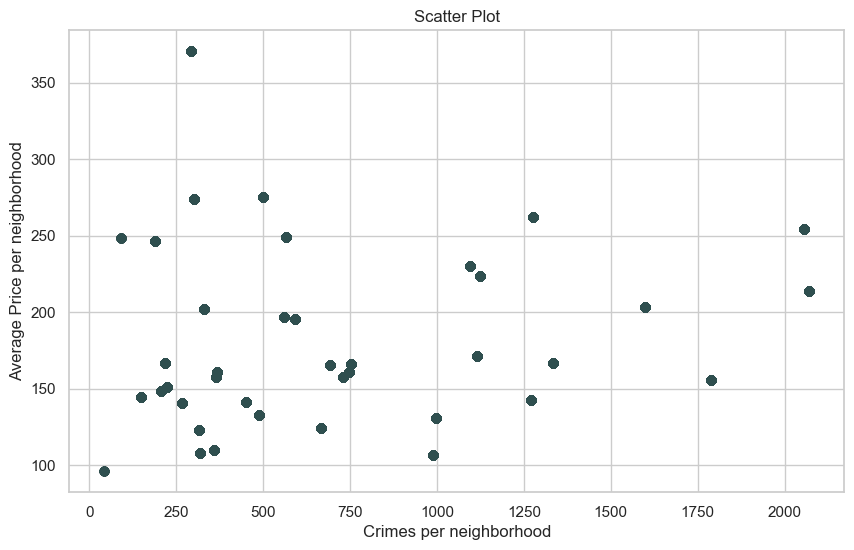

In [232]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_crimes, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The slight correlation is visible here, though it is slight.

### `total types of crimes` vs `price` <a id="total_types_crimes_vs_price"></a>  
[back to list](#pairwise)

This is the total of each type of crime versus price. 

In [233]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   METHOD   LATITUDE                                  NEIGHBORHOOD_NAME  \
0  others  38.897331          Union Station, Stanton Park, Kingman Park   
1  others  38.881269                         Capitol Hill, Lincoln Park   
2     gun  38.858661  Fairfax Village, Naylor Gardens, Hillcrest, Su...   
3  others  38.831632   Congress Heights, Bellevue, Washington Highlands   
4  others  38.922290  Columbia Heights, Mt. Pleasant, Pleasant Plain...   

   total_crimes   avg_price  
0          2070  213.681243  
1          1095  230.157343  
2           315  123.060606  
3           990  106.824561  
4          1788  155.922889

We want to look at the each offense. 

In [234]:
crimes = pd.concat([crimes, pd.get_dummies(crimes["OFFENSE"], prefix="offense")], axis=1)

Renaming the columns.

In [235]:
crimes = crimes.rename(columns={"offense_assault w/dangerous weapon":"offense_assault_dangerous_weapon", "offense_motor vehicle theft":"offense_motor_vehicle_theft", "offense_sex abuse":"offense_sex_abuse", "offense_theft f/auto":"offense_theft_auto", "offense_theft/other":"offense_theft_other"})
crimes

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0             0           cluster 25      violent -77.002778   
1             1           cluster 26      violent -76.997326   
2             2           cluster 35      violent -76.964260   
3             3           cluster 39      violent -76.999896   
4             4            cluster 2     property -77.025347   
...         ...                  ...          ...        ...   
27606     27606            cluster 1     property -77.042324   
27607     27607            cluster 1     property -77.042369   
27608     27608           cluster 26     property -76.994963   
27609     27609           cluster 11     property -77.081165   
27610     27610           cluster 25     property -77.001314   

                     END_DATE                offense-text     SHIFT  \
0        9/7/2021, 2:18:00 PM                    homicide  midnight   
1       10/3/2021, 3:20:00 PM                     robbery   evening   
2       10/3/2021, 6:40:00 PM                     robbery   evening   
3      10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4      10/2/2021, 11:01:00 PM                theft f/auto   evening   
...                       ...                         ...       ...   
27606   7/21/2022, 7:00:00 PM                 theft/other  midnight   
27607   8/12/2022, 6:30:00 AM                 theft/other  midnight   
27608   8/12/2022, 9:00:00 AM                theft f/auto  midnight   
27609   5/31/2022, 7:00:00 AM                theft f/auto       day   
27610  5/31/2022, 11:37:00 AM                theft f/auto       day   

                               offensekey START_DATE  \
0                        violent|homicide 2021-09-07   
1                         violent|robbery 2021-10-03   
2                         violent|robbery 2021-10-03   
3      violent|assault w/dangerous weapon 2021-10-11   
4                   property|theft f/auto 2021-10-02   
...                                   ...        ...   
27606                property|theft/other 2022-07-21   
27607                property|theft/other 2022-08-11   
27608               property|theft f/auto 2022-08-12   
27609               property|theft f/auto 2022-05-26   
27610               property|theft f/auto 2022-05-27   

                          OFFENSE  ...   avg_price  offense_arson  \
0                        homicide  ...  213.681243              0   
1                         robbery  ...  230.157343              0   
2                         robbery  ...  123.060606              0   
3      assault w/dangerous weapon  ...  106.824561              0   
4                    theft f/auto  ...  155.922889              0   
...                           ...  ...         ...            ...   
27606                 theft/other  ...  157.829480              0   
27607                 theft/other  ...  157.829480              0   
27608                theft f/auto  ...  230.157343              0   
27609                theft f/auto  ...  157.533333              0   
27610                theft f/auto  ...  213.681243              0   

      offense_assault_dangerous_weapon  offense_burglary  offense_homicide  \
0                                    0                 0                 1   
1                                    0                 0                 0   
2                                    0                 0                 0   
3                                    1                 0                 0   
4                                    0                 0                 0   
...                                ...               ...               ...   
27606                                0                 0                 0   
27607                                0                 0                 0   
27608                                0                 0                 0   
27609                                0                 0                 0   
27610                    

In [236]:
crimes["OFFENSE"].unique()

array(['homicide', 'robbery', 'assault w/dangerous weapon',
       'theft f/auto', 'theft/other', 'motor vehicle theft', 'burglary',
       'sex abuse', 'arson'], dtype=object)

Now taking the average for each neighborhood per offense. 

In [237]:
crimes["total_offense_arson"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_arson"].transform("sum")

In [238]:
crimes["total_offense_assault_dangerous_weapon"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_assault_dangerous_weapon"].transform("sum")

In [239]:
crimes["total_offense_burglary"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_burglary"].transform("sum")

In [240]:
crimes["total_offense_homicide"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_homicide"].transform("sum")

In [241]:
crimes["total_offense_motor_vehicle_theft"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_motor_vehicle_theft"].transform("sum")

In [242]:
crimes["total_offense_robbery"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_robbery"].transform("sum")

In [243]:
crimes["total_offense_sex_abuse"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_sex_abuse"].transform("sum")

In [244]:
crimes["total_offense_theft_auto"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_theft_auto"].transform("sum")

In [245]:
crimes["total_offense_theft_other"] = crimes.groupby("NEIGHBORHOOD_NAME")["offense_theft_other"].transform("sum")

In [246]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... offense_theft_other  total_offense_arson  \
0  ...                   0                    0   
1  ...                   0                    1   
2  ...                   0                    0   
3  ...                   0                    1   
4  ...                   0                    0   

  total_offense_assault_dangerous_weapon  total_offense_burglary  \
0                                     55                      78   
1                                     23                      36   
2                                     13                       8   
3                                    132                      50   
4                                     51                      51   

   total_offense_homicide  total_offense_motor_vehicle_theft  \
0                       8                              349.0   
1                       4                              110.0   
2                       3                               42.0   
3                      27                              160.0   
4                       5                              182.0   

   total_offense_robbery  total_offense_sex_abuse  total_offense_theft_auto  \
0                    139                       12                     521.0   
1                     82                        3                     283.0   
2                     33                        2                     100.0   
3                    109                        7                     135.0   
4                    131                        6                     516.0   

   total_offense_theft_other  
0                      772.0  
1                      503.0  
2                       85.0  
3                      213.0  
4                      703.0  

[5 rows x 33 columns]

In [247]:
offense_sum = crimes["total_offense_arson"]

In [248]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  -0.11866420773467688
rho =  -0.0629486848558514


There is a slight negative correlation between arson crimes and average price. 

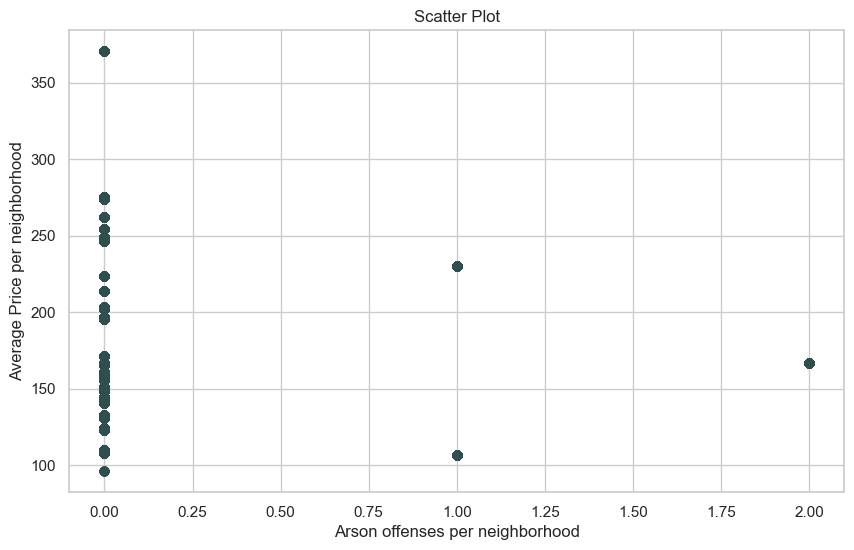

In [249]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Arson offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There are too few arson offenses to really draw conclusions. 

In [250]:
offense_sum = crimes["total_offense_assault_dangerous_weapon"]

In [251]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  -0.3407583655881097
rho =  -0.19319826732628786


There is a slight positive correlation between assault with a dangerous weapon crimes and average price. 

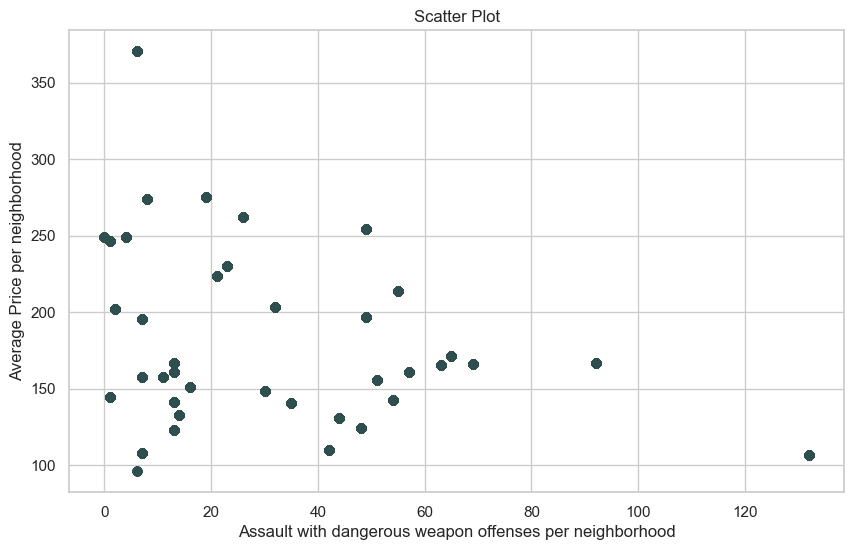

In [252]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Assault with dangerous weapon offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There is a slight positive correlation. It's possible that, similar to total crimes, the more populous or dense a neighborhood is, the more crime there is and the higher the prices, but without price depending on crime or vice versa. 

In [253]:
offense_sum = crimes["total_offense_burglary"]

In [254]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  0.0760714915926916
rho =  0.12415044676181282


There is a slight positive correlation between burglary crimes and average price. 

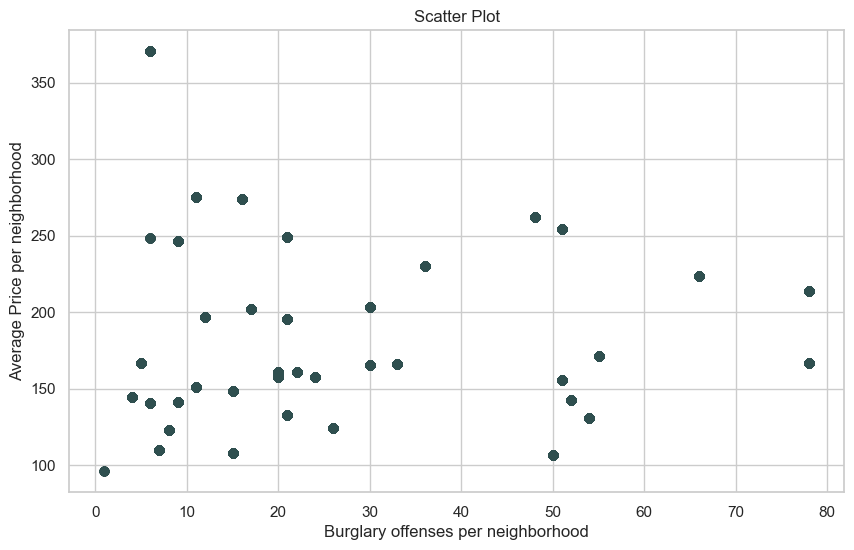

In [255]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Burglary offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There is possibly a very slight positive correlation. 

In [256]:
offense_sum = crimes["total_offense_homicide"]

In [257]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  -0.452242606629432
rho =  -0.4193329909486742


There is a medium negative correlation between homicide crimes and average price. 

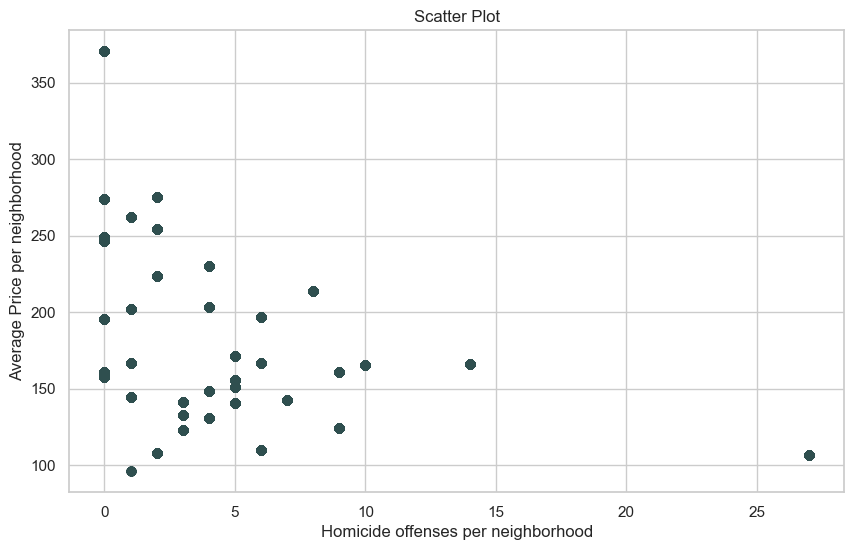

In [258]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Homicide offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There does appear to be a negative correlation between homicide and price. 

In [259]:
offense_sum = crimes["total_offense_motor_vehicle_theft"]

In [260]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  0.08516232954716718
rho =  0.11592847942971346


There is a slight positive correlation between motor vehicle theft crimes and average price. 

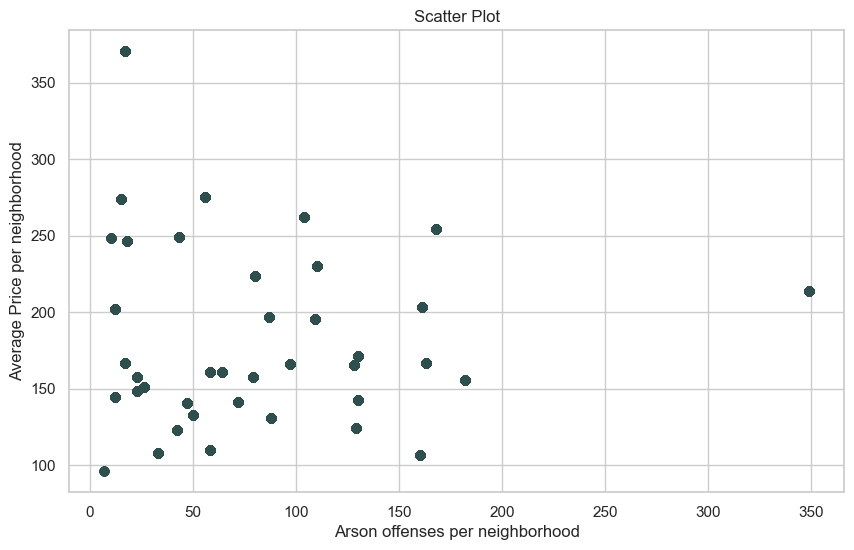

In [261]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Arson offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There does not appear to be a strong correlation. 

In [262]:
offense_sum = crimes["total_offense_robbery"]

In [263]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  -0.08478055618637566
rho =  0.01861935538151312


There is a slight negative correlation between robbery crimes and average price. 

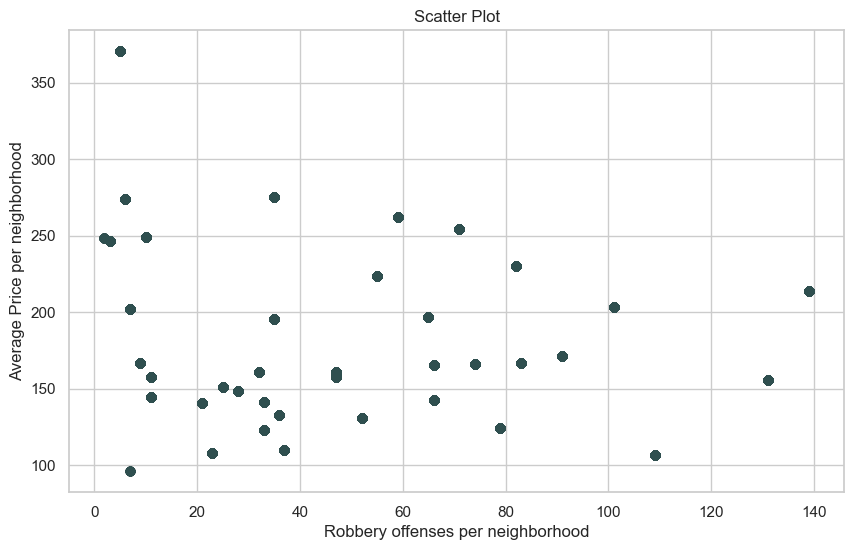

In [264]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Robbery offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There is not an obvious correlation. 

In [265]:
offense_sum = crimes["total_offense_sex_abuse"]

In [266]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  0.08486037004194204
rho =  0.21899182451401208


There is a slight positive correlation between sex abuse crimes and average price. 

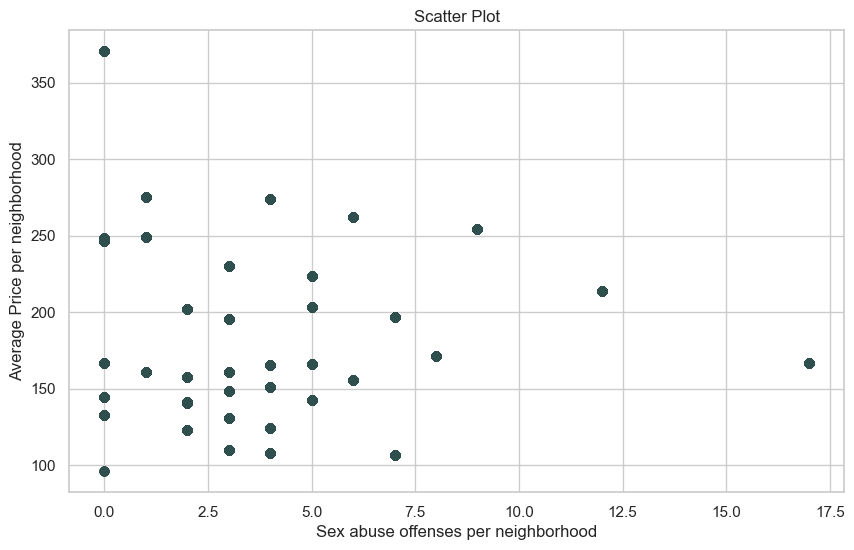

In [267]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Sex abuse offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

Just based on the chart there would appear to be a slight negative correlation, though it is probably that there is not enough data or there is not a correlation. 

In [268]:
offense_sum = crimes["total_offense_theft_auto"]

In [269]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  0.28750469985174165
rho =  0.35221021086374615


There is a slight/medium positive correlation between auto theft crimes and average price. 

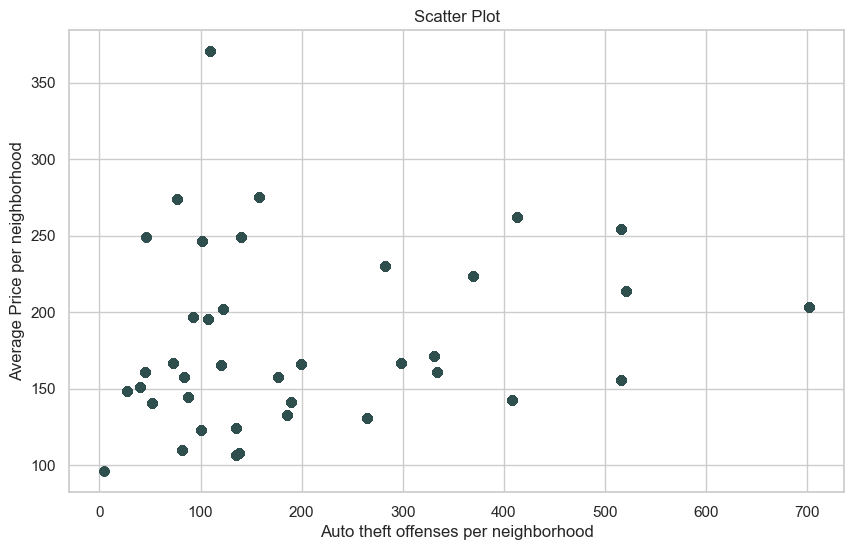

In [270]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Auto theft offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There appears to be a slight positive correlation. 

In [271]:
offense_sum = crimes["total_offense_theft_other"]

In [272]:
print("r   = ", stats.pearsonr(avg_price, offense_sum)[0])
print("rho = ", stats.spearmanr(avg_price, offense_sum)[0])

r   =  0.427154432329103
rho =  0.47560561790571704


There is a medium positive correlation between other theft crimes and average price. 

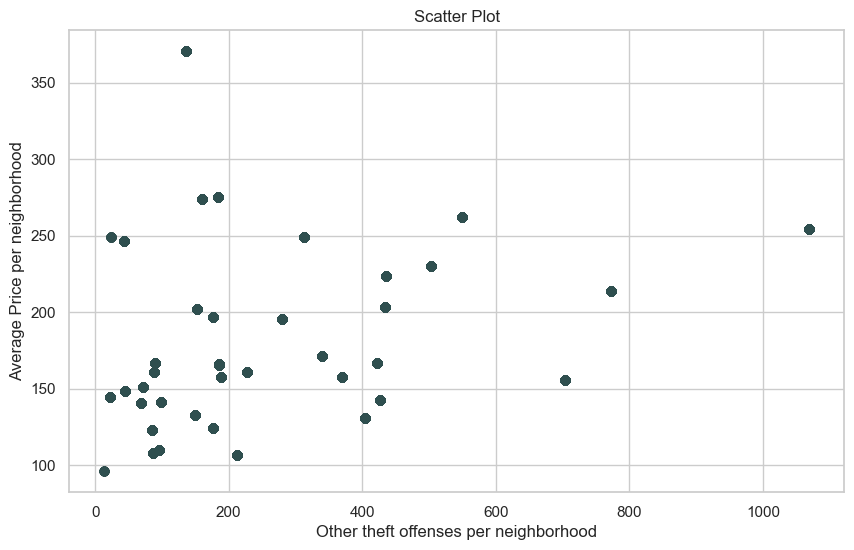

In [273]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(offense_sum, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Other theft offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There does appear to be a slight positive correlation. 

Overall there appear to be some crimes that do show a correlation between average price per neighborhood and total offenses per neighborhood. There are some offenses that do not appear to have a correlation. However, we don't know if there are unknown confounding variables, so it may be unhelpful to use these variables in the model. 

### `offense types` vs `price` <a id="offense_type_vs_price"></a>  
[back to list](#pairwise)

This is if the crime is a property crime or a violent crimes. The sums of each per neighbohood will be added as columns.

In [274]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... offense_theft_other  total_offense_arson  \
0  ...                   0                    0   
1  ...                   0                    1   
2  ...                   0                    0   
3  ...                   0                    1   
4  ...                   0                    0   

  total_offense_assault_dangerous_weapon  total_offense_burglary  \
0                                     55                      78   
1                                     23                      36   
2                                     13                       8   
3                                    132                      50   
4                                     51                      51   

   total_offense_homicide  total_offense_motor_vehicle_theft  \
0                       8                              349.0   
1                       4                              110.0   
2                       3                               42.0   
3                      27                              160.0   
4                       5                              182.0   

   total_offense_robbery  total_offense_sex_abuse  total_offense_theft_auto  \
0                    139                       12                     521.0   
1                     82                        3                     283.0   
2                     33                        2                     100.0   
3                    109                        7                     135.0   
4                    131                        6                     516.0   

   total_offense_theft_other  
0                      772.0  
1                      503.0  
2                       85.0  
3                      213.0  
4                      703.0  

[5 rows x 33 columns]

Confirming that there are just the two expected values. 

In [275]:
crimes["offensegroup"].unique()

array(['violent', 'property'], dtype=object)

Adding dummy variables. 

In [276]:
crimes = pd.concat([crimes, pd.get_dummies(crimes["offensegroup"], prefix="off_type")], axis=1)

In [277]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... total_offense_assault_dangerous_weapon  total_offense_burglary  \
0  ...                                     55                      78   
1  ...                                     23                      36   
2  ...                                     13                       8   
3  ...                                    132                      50   
4  ...                                     51                      51   

  total_offense_homicide  total_offense_motor_vehicle_theft  \
0                      8                              349.0   
1                      4                              110.0   
2                      3                               42.0   
3                     27                              160.0   
4                      5                              182.0   

   total_offense_robbery  total_offense_sex_abuse  total_offense_theft_auto  \
0                    139                       12                     521.0   
1                     82                        3                     283.0   
2                     33                        2                     100.0   
3                    109                        7                     135.0   
4                    131                        6                     516.0   

   total_offense_theft_other  off_type_property  off_type_violent  
0                      772.0                  0                 1  
1                      503.0                  0                 1  
2                       85.0                  0                 1  
3                      213.0                  0                 1  
4                      703.0                  1                 0  

[5 rows x 35 columns]

Summing the values for each type per neighborhood.

In [278]:
crimes["total_property"] = crimes.groupby("NEIGHBORHOOD_NAME")["off_type_property"].transform("sum")

In [279]:
crimes["total_violent"] = crimes.groupby("NEIGHBORHOOD_NAME")["off_type_violent"].transform("sum")

In [280]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... total_offense_homicide  total_offense_motor_vehicle_theft  \
0  ...                      8                              349.0   
1  ...                      4                              110.0   
2  ...                      3                               42.0   
3  ...                     27                              160.0   
4  ...                      5                              182.0   

  total_offense_robbery  total_offense_sex_abuse  total_offense_theft_auto  \
0                   139                       12                     521.0   
1                    82                        3                     283.0   
2                    33                        2                     100.0   
3                   109                        7                     135.0   
4                   131                        6                     516.0   

   total_offense_theft_other  off_type_property  off_type_violent  \
0                      772.0                  0                 1   
1                      503.0                  0                 1   
2                       85.0                  0                 1   
3                      213.0                  0                 1   
4                      703.0                  1                 0   

   total_property  total_violent  
0          1720.0          214.0  
1           933.0          112.0  
2           235.0           51.0  
3           559.0          275.0  
4          1452.0          193.0  

[5 rows x 37 columns]

In [281]:
total_type = crimes["total_property"]

In [282]:
print("r   = ", stats.pearsonr(avg_price, total_type)[0])
print("rho = ", stats.spearmanr(avg_price, total_type)[0])

r   =  0.3511584011434341
rho =  0.3852270390342173


There is a medium positive correlation between property crimes and average price. 

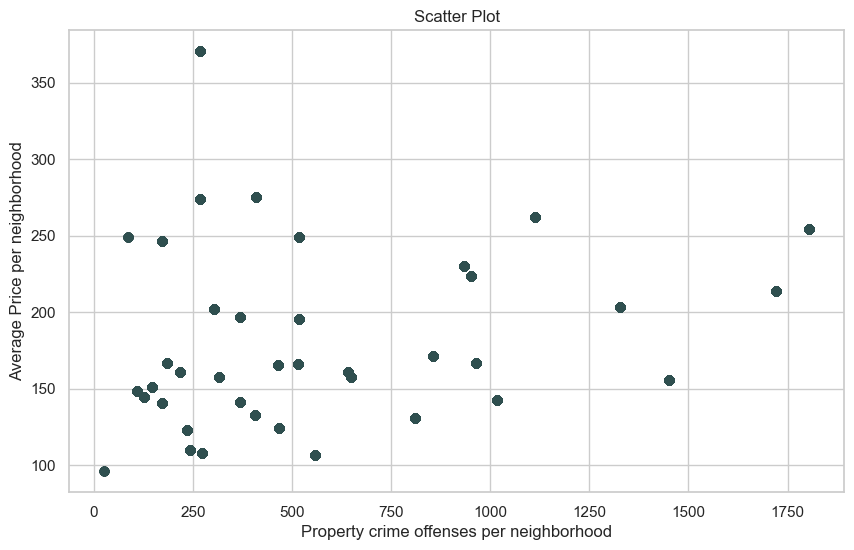

In [283]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_type, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Property crime offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There does appear to be a positive correlation. 

In [284]:
total_type = crimes["total_violent"]

In [285]:
print("r   = ", stats.pearsonr(avg_price, total_type)[0])
print("rho = ", stats.spearmanr(avg_price, total_type)[0])

r   =  -0.22601437664047108
rho =  -0.12378245872988368


There is a slight/medium negative correlation between violent crimes and average price. 

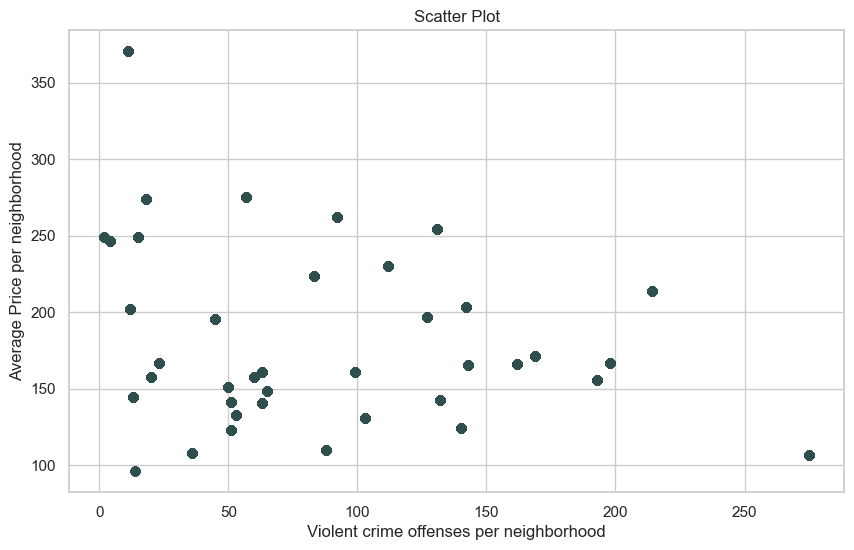

In [286]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_type, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Violent crime offenses per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

There does appear to be a negative correlation, though it appears less obvious than the property crime appears positive. 

Violent crimes appear to be negatively correlated with price and property crime positively correlated. This makes some intuitive sense, as areas with violent crime would not be popular with tourists, but areas of higher population density that attract property crime may still have higher prices. 

## `method` vs `price` <a id="method_vs_price"></a>  
[back to list](#pairwise)

The method of the crime will be compared to the price. 

In [287]:
crimes["METHOD"].unique()

array(['others', 'gun', 'knife'], dtype=object)

The values for this variable are as expected, so we'll make dummy variables. 

In [288]:
crimes = pd.concat([crimes, pd.get_dummies(crimes["METHOD"], prefix="method")], axis=1)

In [289]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... total_offense_sex_abuse  total_offense_theft_auto  \
0  ...                      12                     521.0   
1  ...                       3                     283.0   
2  ...                       2                     100.0   
3  ...                       7                     135.0   
4  ...                       6                     516.0   

  total_offense_theft_other  off_type_property  off_type_violent  \
0                     772.0                  0                 1   
1                     503.0                  0                 1   
2                      85.0                  0                 1   
3                     213.0                  0                 1   
4                     703.0                  1                 0   

   total_property  total_violent  method_gun  method_knife  method_others  
0          1720.0          214.0           0             0              1  
1           933.0          112.0           0             0              1  
2           235.0           51.0           1             0              0  
3           559.0          275.0           0             0              1  
4          1452.0          193.0           0             0              1  

[5 rows x 40 columns]

Summing the values for each method per neighborhood.

In [290]:
crimes["total_gun"] = crimes.groupby("NEIGHBORHOOD_NAME")["method_gun"].transform("sum")

In [291]:
crimes["total_knife"] = crimes.groupby("NEIGHBORHOOD_NAME")["method_knife"].transform("sum")

In [292]:
crimes["total_others"] = crimes.groupby("NEIGHBORHOOD_NAME")["method_others"].transform("sum")

In [293]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... off_type_property  off_type_violent total_property  total_violent  \
0  ...                 0                 1         1720.0          214.0   
1  ...                 0                 1          933.0          112.0   
2  ...                 0                 1          235.0           51.0   
3  ...                 0                 1          559.0          275.0   
4  ...                 1                 0         1452.0          193.0   

   method_gun  method_knife  method_others  total_gun  total_knife  \
0           0             0              1        116           28   
1           0             0              1         57            9   
2           1             0              0         42            2   
3           0             0              1        190           37   
4           0             0              1         94           27   

   total_others  
0        1790.0  
1         979.0  
2         242.0  
3         607.0  
4        1524.0  

[5 rows x 43 columns]

In [294]:
total_method = crimes["total_gun"]

In [295]:
print("r   = ", stats.pearsonr(avg_price, total_method)[0])
print("rho = ", stats.spearmanr(avg_price, total_method)[0])

r   =  -0.41188814871022433
rho =  -0.2945376995157476


There is a medium negative correlation between gun crimes and average price. 

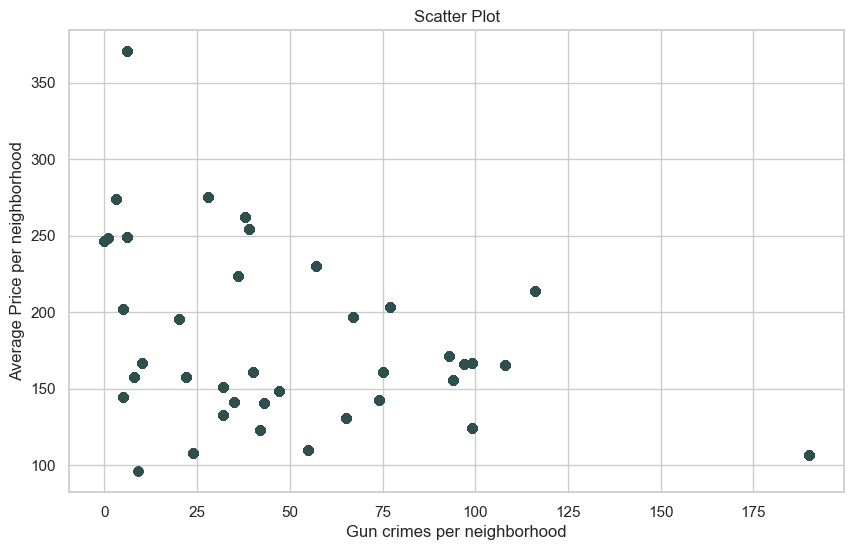

In [296]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_method, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Gun crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart does appear to be a negative correlation. 

In [297]:
total_method = crimes["total_knife"]

In [298]:
print("r   = ", stats.pearsonr(avg_price, total_method)[0])
print("rho = ", stats.spearmanr(avg_price, total_method)[0])

r   =  -0.11715637516060468
rho =  -0.0033041250964812737


There is a slight negative correlation between knife crimes and average price. 

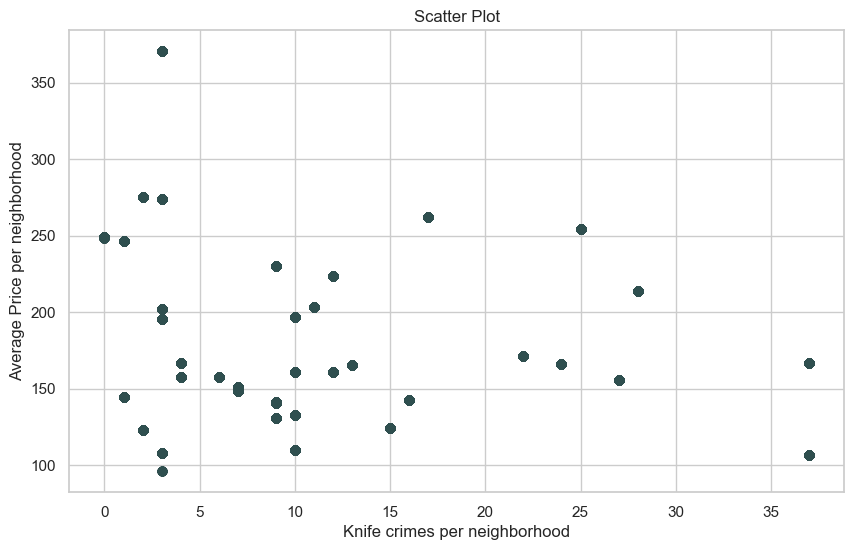

In [299]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_method, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Knife crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart appears to have a slight negative correlation. 

In [300]:
total_method = crimes["total_others"]

In [301]:
print("r   = ", stats.pearsonr(avg_price, total_method)[0])
print("rho = ", stats.spearmanr(avg_price, total_method)[0])

r   =  0.34433289936254546
rho =  0.3842336057132542


There is a slight positive correlation between other crimes and average price. 

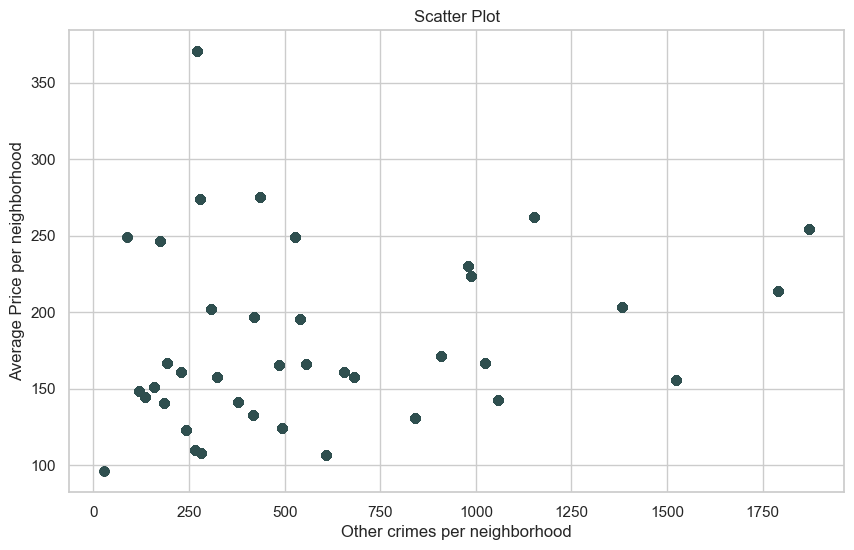

In [302]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_method, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Other crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart appears to have a positive correlation. 

There seems to be a negative correlation between gun and knife crimes and prices and a positive correlation between other method crimes and price. This seems to fit with the previous comparison, that violent crime is negatively correlated with price and property crime positively correlated. There is probably a breakdown to very specific types or ratios of crimes in a neighborhood that are more closely related to price. There is also perhaps more crime/population data that would explain these numbers that are not available in the data we have. 

### `shift` vs `price` <a id="shift_vs_price"></a>  
[back to list](#pairwise)

The shift variable is what time of day that the crime occurs. 

In [303]:
crimes["SHIFT"].unique()

array(['midnight', 'evening', 'day'], dtype=object)

As the values are expected, we will create a dummy variable. 

In [304]:
crimes = pd.concat([crimes, pd.get_dummies(crimes["SHIFT"], prefix="shift")], axis=1)

In [305]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... total_violent  method_gun method_knife  method_others  total_gun  \
0  ...         214.0           0            0              1        116   
1  ...         112.0           0            0              1         57   
2  ...          51.0           1            0              0         42   
3  ...         275.0           0            0              1        190   
4  ...         193.0           0            0              1         94   

   total_knife  total_others  shift_day  shift_evening  shift_midnight  
0           28        1790.0          0              0               1  
1            9         979.0          0              1               0  
2            2         242.0          0              1               0  
3           37         607.0          0              0               1  
4           27        1524.0          0              1               0  

[5 rows x 46 columns]

Summing the values for each method per neighborhood.

In [306]:
crimes["total_day"] = crimes.groupby("NEIGHBORHOOD_NAME")["shift_day"].transform("sum")

In [307]:
crimes["total_evening"] = crimes.groupby("NEIGHBORHOOD_NAME")["shift_evening"].transform("sum")

In [308]:
crimes["total_midnight"] = crimes.groupby("NEIGHBORHOOD_NAME")["shift_midnight"].transform("sum")

In [309]:
crimes.head()

column00 NEIGHBORHOOD_CLUSTER offensegroup  LONGITUDE  \
0         0           cluster 25      violent -77.002778   
1         1           cluster 26      violent -76.997326   
2         2           cluster 35      violent -76.964260   
3         3           cluster 39      violent -76.999896   
4         4            cluster 2     property -77.025347   

                 END_DATE                offense-text     SHIFT  \
0    9/7/2021, 2:18:00 PM                    homicide  midnight   
1   10/3/2021, 3:20:00 PM                     robbery   evening   
2   10/3/2021, 6:40:00 PM                     robbery   evening   
3  10/11/2021, 8:52:00 PM  assault w/dangerous weapon  midnight   
4  10/2/2021, 11:01:00 PM                theft f/auto   evening   

                           offensekey START_DATE                     OFFENSE  \
0                    violent|homicide 2021-09-07                    homicide   
1                     violent|robbery 2021-10-03                     robbery   
2                     violent|robbery 2021-10-03                     robbery   
3  violent|assault w/dangerous weapon 2021-10-11  assault w/dangerous weapon   
4               property|theft f/auto 2021-10-02                theft f/auto   

   ... method_others  total_gun total_knife  total_others  shift_day  \
0  ...             1        116          28        1790.0          0   
1  ...             1         57           9         979.0          0   
2  ...             0         42           2         242.0          0   
3  ...             1        190          37         607.0          0   
4  ...             1         94          27        1524.0          0   

   shift_evening  shift_midnight  total_day  total_evening  total_midnight  
0              0               1      805.0          763.0           366.0  
1              1               0      491.0          390.0           164.0  
2              1               0      136.0          107.0            43.0  
3              0               1      260.0          326.0           248.0  
4              1               0      689.0          619.0           337.0  

[5 rows x 49 columns]

In [310]:
total_shift = crimes["total_day"]

In [311]:
print("r   = ", stats.pearsonr(avg_price, total_shift)[0])
print("rho = ", stats.spearmanr(avg_price, total_shift)[0])

r   =  0.3183165635613521
rho =  0.4089085328652436


There is a medium negative correlation between day crimes and average price. 

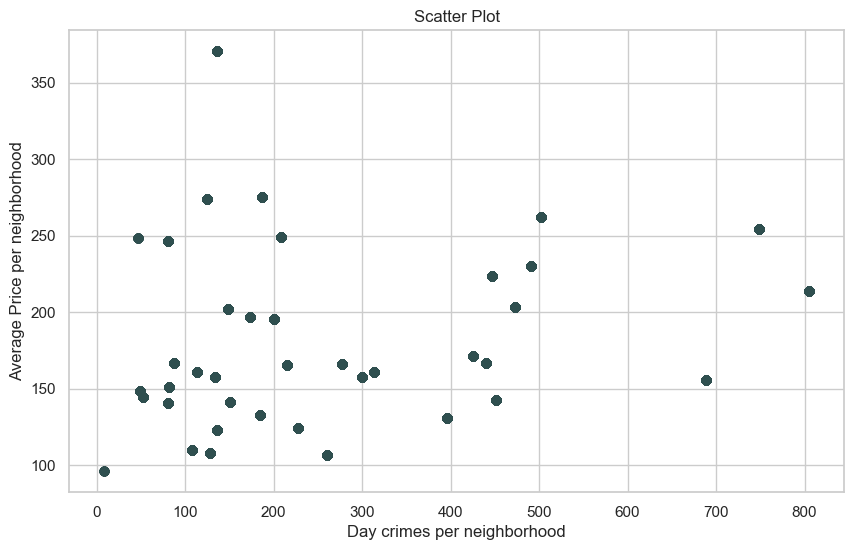

In [312]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_shift, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Day crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart does appear to be a positive correlation. 

In [313]:
total_shift = crimes["total_evening"]

In [314]:
print("r   = ", stats.pearsonr(avg_price, total_shift)[0])
print("rho = ", stats.spearmanr(avg_price, total_shift)[0])

r   =  0.3088018392887768
rho =  0.337923881227923


There is a medium/slight positive correlation between evening crimes and average price. 

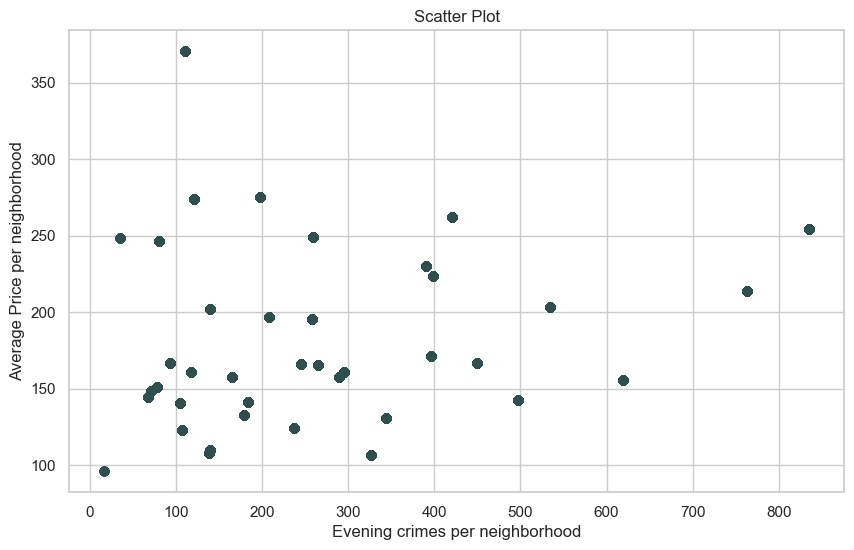

In [315]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_shift, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Evening crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart appears to have a slight positive correlation. 

In [316]:
total_shift = crimes["total_midnight"]

In [317]:
print("r   = ", stats.pearsonr(avg_price, total_shift)[0])
print("rho = ", stats.spearmanr(avg_price, total_shift)[0])

r   =  0.20845253952901144
rho =  0.2663572018757196


There is a slight positive correlation between midnight crimes and average price. 

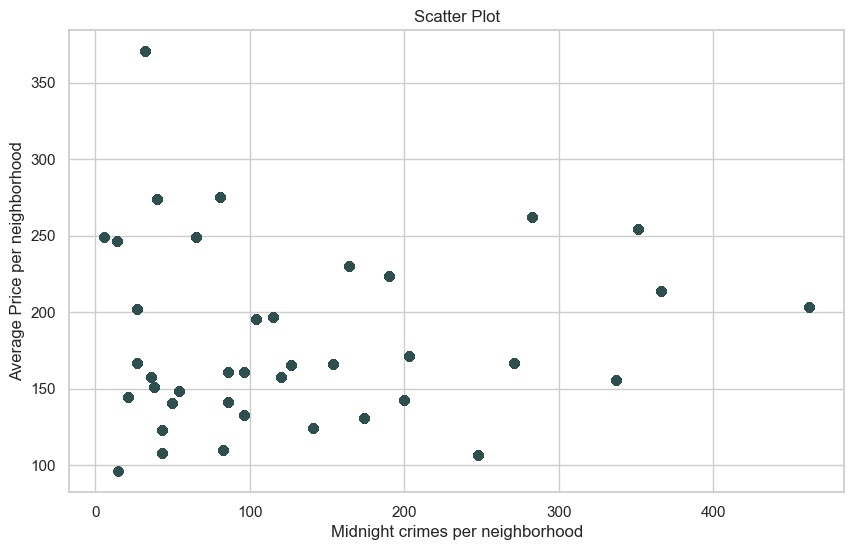

In [318]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(total_shift, avg_price, marker="o", color="darkslategray")

axes.set_ylabel("Average Price per neighborhood")
axes.set_xlabel("Midnight crimes per neighborhood")
axes.set_title("Scatter Plot")

plt.show()
plt.close()

The chart appears to have a slight positive correlation. 

There appears to be a slight positive correlation between each time of day and price. The highest positive correlation is day, then evening, then midnight, which if we assume that more violent crimes are committed at night, makes sense. Overall these numbers are similar to those of the overall crime totals. 

The crime data does appear to be correlated with price, but without more information on how population distribution affects both price and crime, it may not be useful in helping to predict prices. 

### Crime Conclusion
When comparing crime and price it was first necessary to group them both by neighborhood. When thinking about the data, if we hypothesize that crimes in an area affect prices of listings, we are talking about crimes that have happened within a geographic distance as well as a temporal distance prior to the listing date. This was not the end goal of the project and would have involved a lot more data to explore potential relationship factors, so the times of crimes relative to listings were ignored. Instead we took counts or averages of crimes for each neighborhood, as a way to create a metric that could represent a sort of "crime potential" value. As we also grouped the listings into neighborhoods and compared this against the average price per area we are looking at general trends in each area, which, even if there is a relationship between crimes and prices, may not have the nuance to show it.

The specific variables looked at include total crimes (the count of crimes occuring in each neighborhood), the counts of each type of offense, the count of crimes in each offense group (property or violent), the count of crimes of each method (gun, knife, other), and the count of crimes occuring during which shift, or time period (day, evening, midnight).

None of the correlation statitics suggested a strong correlation:

Total crimes showed a lower-medium positive correlation with price.

Homicide had medium negative, auto theft lower-medium positive correlation, and other thefts offences medium positive correlations respectively.

A lower-medium positive correlation with propety crimes, and a lower-medium negative correlation with violent crimes.

Gun crime had a medium negative correlation and the method other types had a lower-medium positive correlation.

Day shift had the highest medium positive correlation, evening shift a lower medium positive, and midnight a little lower than that.

Note: we hypothesize that the positive correlations between crime and price are due in part to population density - more crime is expected in areas with more people, and more people in an area can also increase prices. To confirm this, we would need additional data. The patterns in correlation statistics suggest that in general, crime is associated with higher prices, unless the crime is violent (the offense types with negative correlation, gun crime with negative correlation, the violent crime group with negative correlation). This is why we used violent crime when developing the model - it seemed less likely to have a confounding variable that would be represented by one of the location variables.

# Baseline Model


### EDA-Price

The variable price that represents price per night charged for that listing in the database, is the target variable we interested to predict by other related covariates. Since Airbnb is an online community that provides short-term homestays and apartment rental at an amzing price, therefore, the price in database is expected to concentrate within the smaller charges and looks like positive skewed distribution.

In [319]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [320]:
full_latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [321]:
pd.DataFrame(full_latest_listings.price.head())

price
0   67.0
1   39.0
2   75.0
3  250.0
4  113.0

In [322]:
price=pd.DataFrame(full_latest_listings.price)
price.describe()

price
count  10560.000000
mean     198.181818
std      422.463628
min        0.000000
25%       85.000000
50%      129.000000
75%      206.000000
max    24999.000000

In [323]:
print("The rows of price over than $1000 is",len(price[price.price>1000]))
np.round(len(price[price.price>1000])/len(price)*100,3)# the ratio of price over than $1000 

The rows of price over than $1000 is 137


1.297

Text(0.5, 0, 'Price($)')

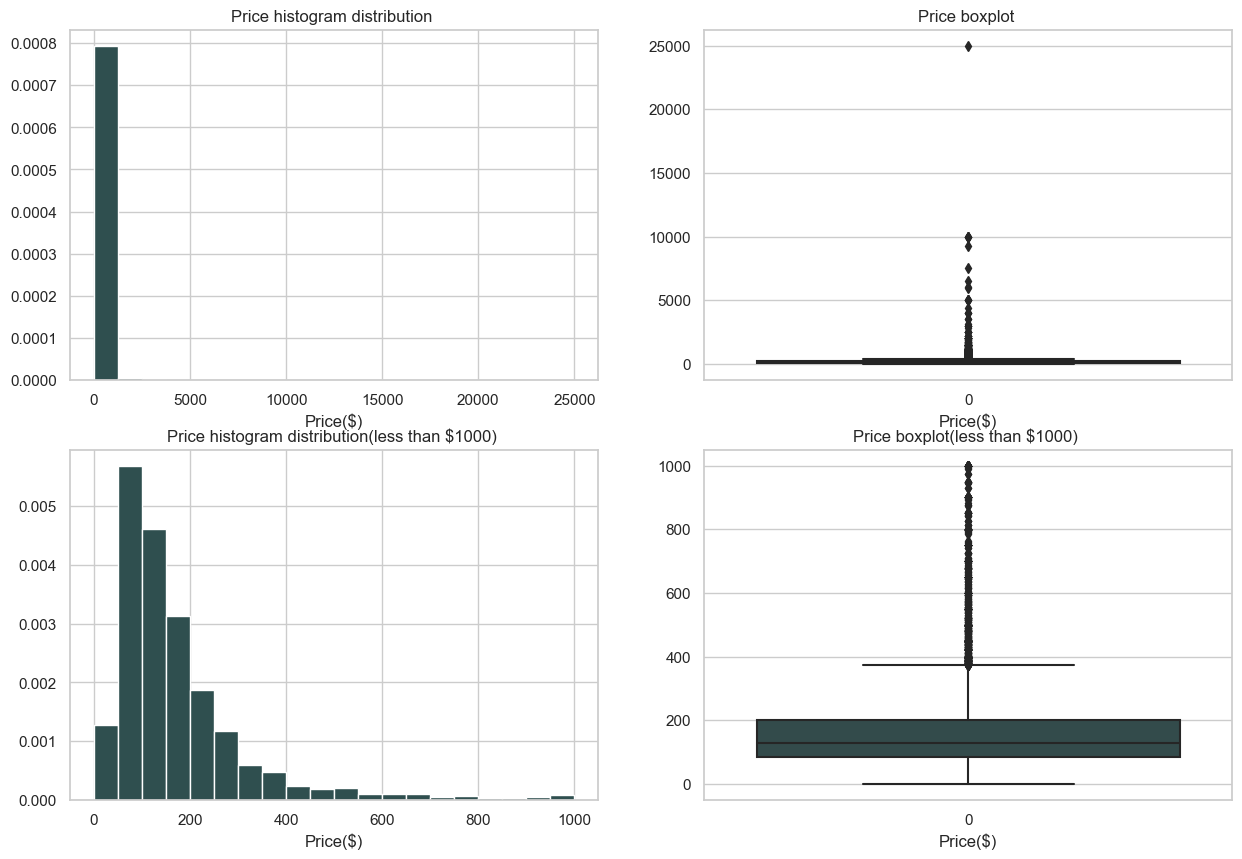

In [324]:
figure = plt.figure(figsize=(15,10))

axes = figure.add_subplot(2, 2, 1)
axes.hist(price,color="darkslategray",bins=20,density=True)
axes.set_title("Price histogram distribution ")
axes.set_xlabel("Price($)")

axes = figure.add_subplot(2, 2, 2)
sns.boxplot(np.array(price),color="darkslategray")
axes.set_title("Price boxplot ")
axes.set_xlabel("Price($)")


data_price=price[price.price<1001]
axes = figure.add_subplot(2, 2, 3)
axes.hist(data_price,color="darkslategray",bins=20,density=True)
axes.set_title("Price histogram distribution(less than $1000) ")
axes.set_xlabel("Price($)")

axes = figure.add_subplot(2, 2, 4)
sns.boxplot(np.array(data_price),color="darkslategray")
axes.set_title("Price boxplot(less than $1000) ")
axes.set_xlabel("Price($)")

According to the summary statistics of price and the distribution of price, it can be found that
* the deviation of price is large with the range of $\$$24,999(max-min), and the perception of price charged below $\$$ 1000 is 98.70$\%$ (100%-1.30%)of overall data
* the distribution of price is positively skewed sharply and most of price are concentrated within the range from $\$$50 to $\$$400.

### Story generation

As per the previous EDA and CLD analysis, there are many factors are estimated to influence the booked price in Airbnb.For instance, the room type, number of beds, property type, and apartment location are all the potential factores to decrease or increase the price of apartment rental. So price is likely to be the outcome of many independent variables affects some working to increase price and some working to decrease price. As a result, price is very likely to follow an approximate normal distribution.

However, since the deviation of price is large as 482, and the histogram shows the positive skewed distribution, we will try logarithmic transformation of price to fit the distribution model alternatively.

### Null (Mean) Model of price

We want to be able to predict price of a random booking. Our loss function will be MSE which means that over and under estimates are symmetric and large errors are penalized more than small errors. Because of this, we'll use the mean as our prediction:

In [325]:
price_mean=np.mean(data_price)
price_std=np.std(data_price)

In [326]:
price_mean

price    169.130673
dtype: float64

We predict that the price of a random booking will be $171.05.

The 95% error bounds on that estimate are:

In [327]:
price_std

price    139.129992
dtype: float64

In [328]:
price_mean-1.96*price_std,price_mean+1.96*price_std

(price   -103.564112
 dtype: float64,
 price    441.825457
 dtype: float64)

Since the price cannot be negative, that is, we expect to see a range of values for price from 0 to $441.82 about 95% percent of the time. 

### Distributional model of price

As per the previous analysis, we first try Normal distribution to fit data.

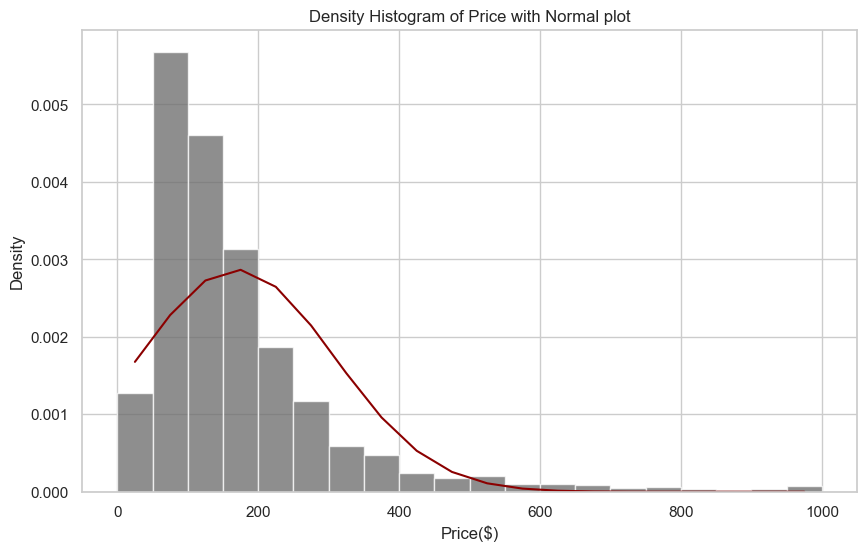

In [329]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(data_price, color="DimGray", density=True, bins=20, alpha=0.75)
axes.set_xlabel( "Price($)")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Price with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [stats.norm.pdf( k, loc=price_mean, scale=price_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

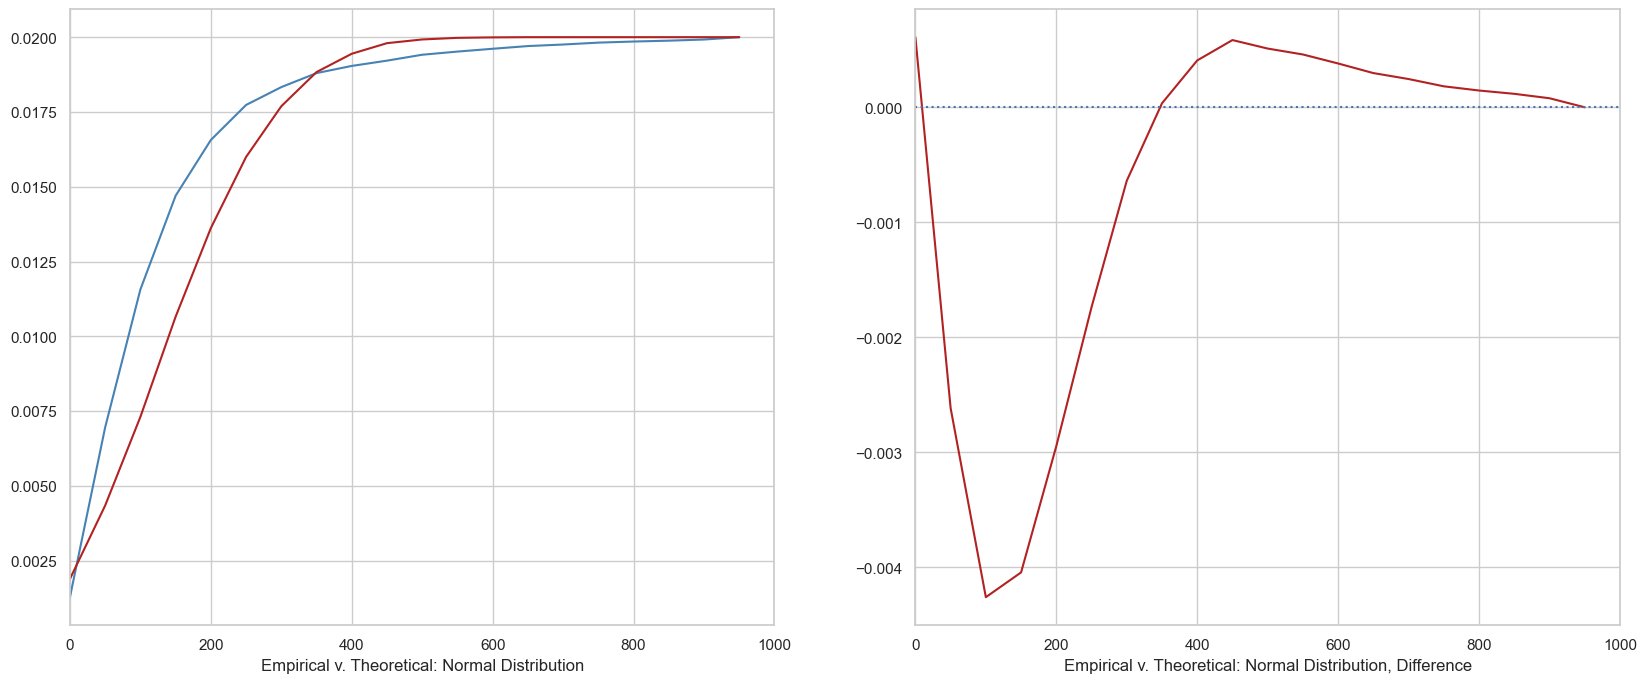

In [330]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(data_price)
price_mx = np.max(data_price)
mean = np.mean(data_price)
std = np.std(data_price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(data_price, bins=20, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((0, 1000))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((0, 1000))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((0, 1000))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

From above model analysis, we can see the Normal model is not a very perfect model for fitting the price data. The model will predict lower price below approximate $\$$350 and higher price over $\$$400. The largest discrepancies between empirical and theoretical difference are around $\$$100 to $\$$ 150 but they are very small.

### Null(Mean) Model of log(Price)

As mentioned in story generation part, since the deviation of price is large and the histogram shows the positive skewed distribution, we will try logarithmic transformation of price to fit Normal distribution model alternatively.

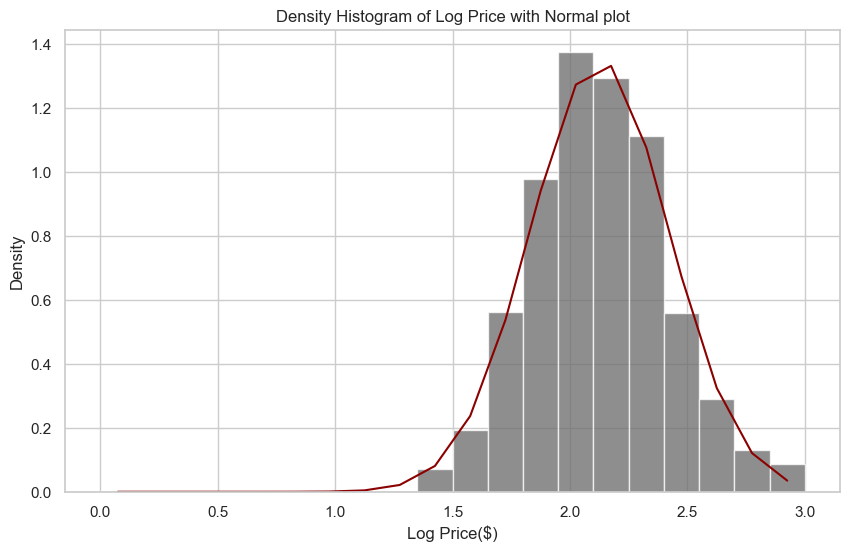

In [331]:
log_price=np.log10(data_price+1)#there are some free charged price, to avoid the infinite value, we add 1 to each price data
log_mean=np.mean(log_price)
log_std=np.std(log_price)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(log_price, color="DimGray", density=True, bins=20, alpha=0.75)
axes.set_xlabel( "Log Price($)")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Log Price with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [stats.norm.pdf( k, loc=log_mean, scale=log_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

In [332]:
log_mean=np.mean(log_price)
log_std=np.std(log_price)

In [333]:
10**log_mean-1

price    132.786801
dtype: float64

We predict that the price of a random booking will be $132.78.

The 95% error bounds on that estimate are:

In [334]:
log_std

price    0.295416
dtype: float64

In [335]:
10**(log_mean-1.96*log_std)-1,10**(log_mean+1.96*log_std)-1

(price    34.26937
 dtype: float64,
 price    506.491576
 dtype: float64)

The logarithmic transformation price estimation is more rational compared to the estimation by null model, that is, we expect to see a range of values for price from $ 34.27 to $506.49 about 95% percent of the time.

### Distribution model of log(Price)

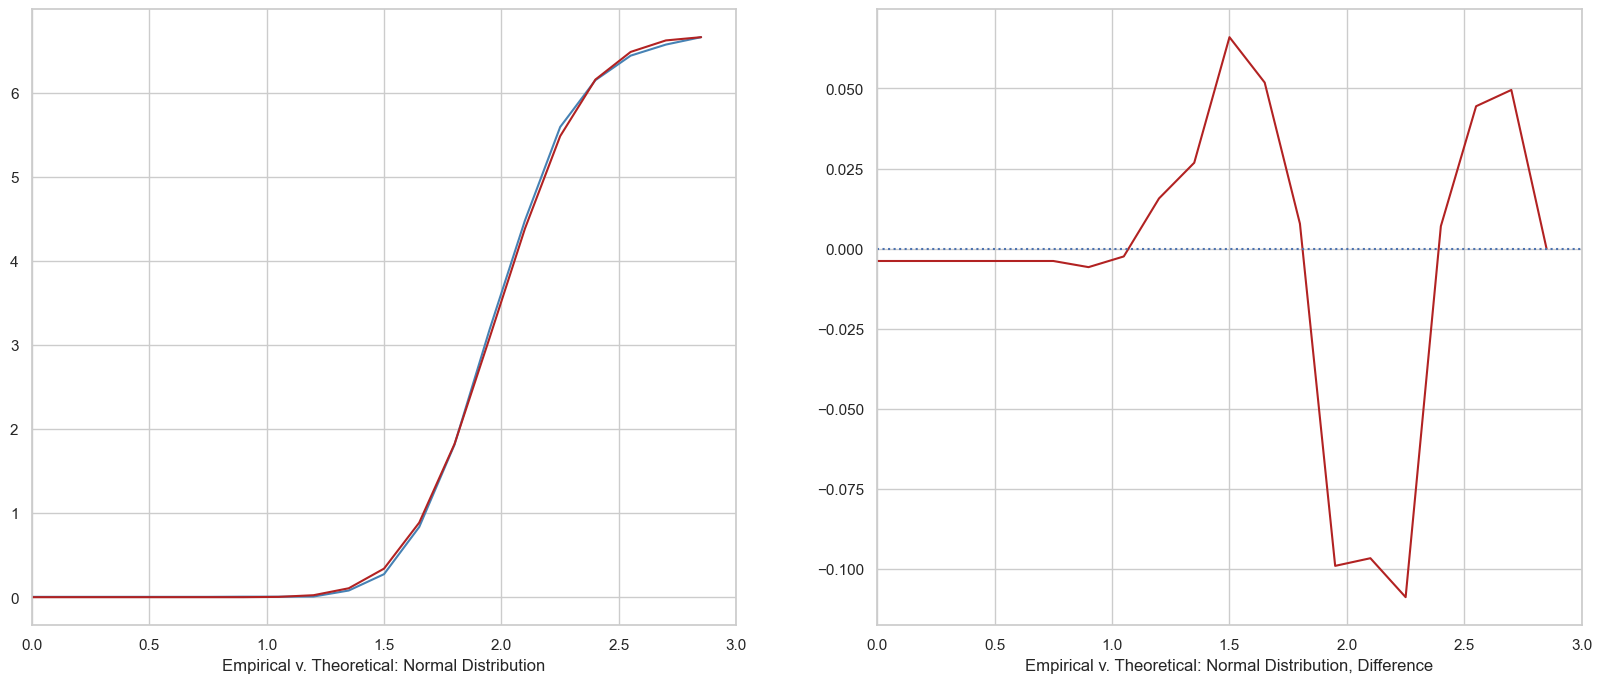

In [336]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(log_price)
price_mx = np.max(log_price)
mean = np.mean(log_price)
std = np.std(log_price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(log_price, bins=20, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((0, 3))

sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((0, 3))
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((0, 3))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

The blue line (Normal distribution of Log Price) looks like a pretty good (smooth) approximation of the red line (Empirical distribution). The Normal distributional model with logarithmic transformation of price can fit the practical price data better compared to the previous model.

The largest discrepency is at $\$$ 50 (10<sup>1.7</sup>) approximately, the differences between fitted price and practical price mainly range from $\$$ 50 to $\$$ 200  (10<sup>2.3</sup>) according to the Normal Distribution Difference linechart.

What is the probability of the Price less than $\$$ 400 in Airbnb ?

In [337]:
stats.norm.cdf(np.log10(400), log_mean, log_std)

array([0.94631097])

There is 94.6% probability of  a (random) price less than $\$$400 in Airbnb from the last quarter.

## Conclusion for Null model and Distributional model of Price

* Based on previous EDA and CLD analysis, we know price is likely to be the outcome of many independent variables affects some working to increase price and some working to decrease price. As per the domain knowledge, we assume price is very likely to follow an approximate normal distribution. 

* Two kinds of Null model(Mean model) and Distributional model are constructed by Price and logarithmic transformation of Price.

* Normal model of Price is not a very perfect model for fitting the price data. The model will predict lower price below approximate  $\$$ 350 and higher price over  $\$$ 400. The largest discrepancies between empirical and theoretical difference are around  $\$$ 100 to  $\$$  150.

* Normal distribution of Log Price looks like a pretty good approximation of the Empirical distribution. The Normal distributional model with logarithmic transformation of price can fit the practical price data better.

* Range of values for random booked price is from $\$$34.27 to $\$$506.49  about 95% percent of the time.

* The largest discrepency is at $\$$ 50 (10<sup>1.7</sup>) approximately, the differences between fitted price and practical price mainly range from $\$$ 50 to $\$$ 200  (10<sup>2.3</sup>) according to the Normal Distribution Difference linechart.
* We can predict that the probability of price less than $\$$ 400 booked in Airbnb from the last quarter is 94.6%

# Regression Model

In [338]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [339]:
# Code from Lab 10 Solution
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [340]:
import models

In [341]:
# Code from Lab 10 Solution
def plot_residuals(result, df, variables):
    height = (len(variables) // 3) * 6 
    figure = plt.figure(figsize=(20,height))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

In [342]:
# Code from Lab 11 Solution
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [343]:
# Code from Lab 11 Solution
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [344]:
from collections import defaultdict

In [345]:
# Code from Lab 11 Solution
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [346]:
# Code from Lab 11 Solution 
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [347]:
# Code from Lab 11 Solution
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [348]:
# Code from Lab 11 Solution
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

# Regression

Our team used
1. Domain knowledge
2. EDA
3. Trial and error of alternative regression models

To come up with the following list of variables for our final regression model:
* `host_listings_count`
* `latitude`
* `longitude"`
* `room_type`
* `accommodates`
* `bedrooms`
* `beds`
* `minimum_nights`
* `maximum_nights`
* `number_of_reviews_ltm`
* `number_of_reviews`
* `review_scores_rating`
* `review_scores_accuracy`
* `review_scores_cleanliness`
* `review_scores_checkin`
* `review_scores_communication`
* `review_scores_location`
* `review_scores_value`
* `reviews_per_month`
* `violent_crimes`
* `host_identity_verified`

Let's filter our latest listings dataframe to include only rows that have non-null/non-NaN values for these variables.

In [349]:
df = full_latest_listings[full_latest_listings[["host_listings_count",
                                               "latitude",
                                               "longitude", 
                                               "room_type",
                                               "accommodates",
                                               "bedrooms",
                                               "beds",
                                               "minimum_nights",
                                               "maximum_nights",
                                               "number_of_reviews_ltm",
                                               "number_of_reviews",
                                               "review_scores_rating",
                                               "review_scores_accuracy",
                                               "review_scores_cleanliness",
                                               "review_scores_checkin",
                                               "review_scores_communication",
                                               "review_scores_location",
                                               "review_scores_value",
                                               "reviews_per_month",
                                               "violent_crimes",
                                               "host_identity_verified"]].notnull().all(1)]
df = df[["price",
                "host_listings_count",
                "latitude",
                "longitude",
                "room_type",
                "accommodates",
                "bedrooms",
                "beds",
                "minimum_nights",
                "maximum_nights",
                "number_of_reviews_ltm",
                "number_of_reviews",
                "review_scores_rating",
                "review_scores_accuracy",
                "review_scores_cleanliness",
                "review_scores_checkin",
                "review_scores_communication",
                "review_scores_location",
                "review_scores_value",
                "reviews_per_month",
                "violent_crimes",
                "host_identity_verified"]].copy()

We also know from our EDA and queries that `price` has a handful of extreme outliers. The above filtering might have already eliminated those outliers. Let's remove all listings with a nightly price greater than \$1000 and see the percentage of listings that are removed in the process.

We chose 1000 because we found that it was reasonably far beyond the 25th, 50th, and 75th percentile to categorize it as an outlier while not being too large so as to hurt the performance of our model for the wide majority of prices which were between 50 and 250. We expect that if we were to field this regression model as a product, we could reasonably expect most users wanting to predict the price of their AirBnB to be satisfied with a price cap at 1000.

In [350]:
df = df[df.price <= 1000]

This removed 36 / 6751 = 0.5% of entries which is a tolerable amount. Our EDA of `price` also supports this decision because the mean `price` before filtering was: 201 USD and the 25th, 50th, and the 75th percentile were 85, 127 and 201, respectively. 

Next, we need to convert all cateogorical variables into one-hot-encodings in order to be useable in the regression.

In [351]:
# Encode categorical variables into one-hot-encodings
df = pd.concat([df, pd.get_dummies(df["room_type"], prefix='room_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df["host_identity_verified"], prefix='host_identity_verified')], axis=1)

The new column names created here might have resulted in spaces in the column names so lets fix that:

In [352]:
df.columns = df.columns.str.replace(', ','_')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('\._','_')
df.columns = df.columns.str.replace('/|-','')

We are going to be modeling `price` so it is important to understand the distribution of that variable. We know from our EDA and the creation of the null model that `price` has a skewed distribution. It would be beneficial to transform `price` into `log-price` so that the distribution approached a symmetric, Normal distribution.

In [353]:
df["log_price"] = df["price"].apply(np.log)

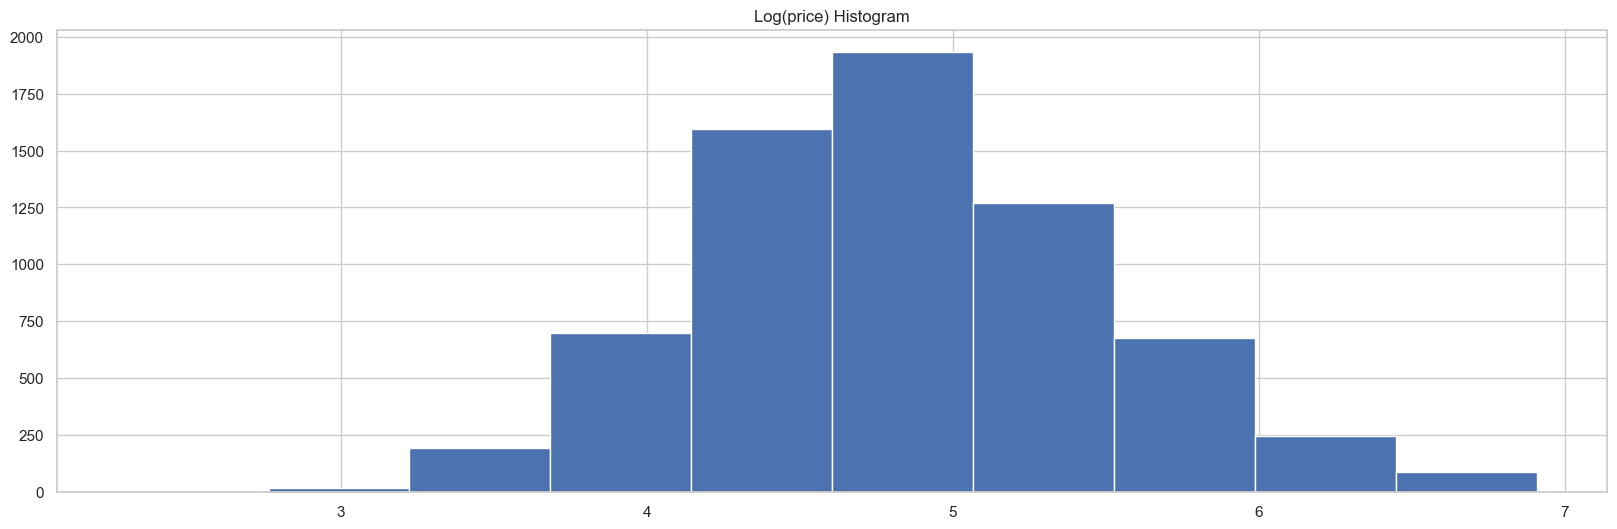

In [354]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(df.log_price)
axes.set_title("Log(price) Histogram")
plt.show()
plt.close()

This distribution looks more symmetric. We will be predicting `log_price` with our model.

We no longer need the "object" type variables as they have been replaced by numerical one-hot encodings:

In [355]:
df = df.select_dtypes(exclude=['object'])

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6715 entries, 0 to 10549
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         6715 non-null   float64
 1   host_listings_count           6715 non-null   float64
 2   latitude                      6715 non-null   float64
 3   longitude                     6715 non-null   float64
 4   accommodates                  6715 non-null   int32  
 5   bedrooms                      6715 non-null   float64
 6   beds                          6715 non-null   float64
 7   minimum_nights                6715 non-null   int32  
 8   maximum_nights                6715 non-null   int32  
 9   number_of_reviews_ltm         6715 non-null   int32  
 10  number_of_reviews             6715 non-null   int32  
 11  review_scores_rating          6715 non-null   float64
 12  review_scores_accuracy        6715 non-null   float64
 13  re

When creating the actual model, we must remove one one-hot-encoded categorical variables so that the y-intercept of the model is interpretable:

In [357]:
model_variables = ['host_listings_count',
                     'latitude',
                     'longitude',
                     'accommodates',
                     'bedrooms',
                     'beds',
                     'minimum_nights',
                     'maximum_nights',
                     'number_of_reviews_ltm',
                     'number_of_reviews',
                     'review_scores_rating',
                     'review_scores_accuracy',
                     'review_scores_cleanliness',
                     'review_scores_checkin',
                     'review_scores_communication',
                     'review_scores_location',
                     'review_scores_value',
                     'reviews_per_month',
                     'violent_crimes',
                     'room_type_Entire_homeapt',
                     'room_type_Hotel_room',
                     'room_type_Private_room',
#                      'room_type_Shared_room',
                     'host_identity_verified_False',
#                      'host_identity_verified_True',
                      ]

Now let's look at the correlations coefficients for each variable in or model with `log_price`.

In [358]:
correlations(df, "log_price", df.columns.values.tolist())

feature         r       rho
0                          price  0.899914  1.000000
1            host_listings_count  0.082657  0.028360
2                       latitude -0.091517 -0.133721
3                      longitude -0.149263 -0.138889
4                   accommodates  0.593653  0.622281
5                       bedrooms  0.596898  0.599590
6                           beds  0.464350  0.535848
7                 minimum_nights  0.004228  0.014154
8                 maximum_nights  0.019535  0.083456
9          number_of_reviews_ltm  0.086171  0.148961
10             number_of_reviews -0.007513  0.004874
11          review_scores_rating  0.063512  0.080738
12        review_scores_accuracy  0.035579  0.055293
13     review_scores_cleanliness  0.103900  0.113144
14         review_scores_checkin  0.001992  0.029995
15   review_scores_communication -0.007127  0.019137
16        review_scores_location  0.138357  0.203495
17           review_scores_value -0.006496 -0.024706
18             reviews_per_month  0.059912  0.094734
19                violent_crimes -0.074163 -0.061904
20      room_type_Entire_homeapt  0.506162  0.523631
21          room_type_Hotel_room -0.090992 -0.063876
22        room_type_Private_room -0.456913 -0.482954
23         room_type_Shared_room -0.181160 -0.163918
24  host_identity_verified_False -0.013812 -0.021373
25   host_identity_verified_True  0.013812  0.021373
26                     log_price  1.000000  1.000000

And here is the correlations between all the model variabels and regular `price`.

In [359]:
correlations(df, "price", df.columns.values.tolist())

feature         r       rho
0                          price  1.000000  1.000000
1            host_listings_count  0.056107  0.028360
2                       latitude -0.082851 -0.133721
3                      longitude -0.117552 -0.138889
4                   accommodates  0.573274  0.622281
5                       bedrooms  0.615569  0.599590
6                           beds  0.478420  0.535848
7                 minimum_nights  0.020790  0.014154
8                 maximum_nights  0.018611  0.083456
9          number_of_reviews_ltm  0.020588  0.148961
10             number_of_reviews -0.053327  0.004874
11          review_scores_rating  0.040370  0.080738
12        review_scores_accuracy  0.008794  0.055293
13     review_scores_cleanliness  0.059820  0.113144
14         review_scores_checkin -0.011653  0.029995
15   review_scores_communication -0.018098  0.019137
16        review_scores_location  0.091118  0.203495
17           review_scores_value -0.027861 -0.024706
18             reviews_per_month -0.003883  0.094734
19                violent_crimes -0.073404 -0.061904
20      room_type_Entire_homeapt  0.327073  0.523631
21          room_type_Hotel_room -0.036810 -0.063876
22        room_type_Private_room -0.302324 -0.482954
23         room_type_Shared_room -0.101439 -0.163918
24  host_identity_verified_False -0.008370 -0.021373
25   host_identity_verified_True  0.008370  0.021373
26                     log_price  0.899914  1.000000

Note that `rho` or the Spearman coefficient does not change between `log_price` and `price` whereas `r` or  the Pearson's correlation coefficient does change. This is because Pearson's measures the *linear* dependence between the variable which changes when we apply a transformation like log to one of the variables.

## Final Regression Model

In [360]:
model_string = "log_price ~ " + ' + '.join(model_variables)

In [361]:
result = models.bootstrap_linear_regression(model_string, data=df)
models.describe_bootstrap_lr(result)

## Model Evaluation

We have an $R^2$ of 0.56 which is fair performance for a real-world model. The $\sigma$ value is 0.43 in **log space**. That means that we can get a 95% CI on the mean price of:

In [362]:
(np.exp(np.log(171.046379) - (1.96 * 0.43)), np.exp(np.log(171.046379) + (1.96 * 0.43)))

(73.63605194038358, 397.31711570710326)

Where the mean of 171 comes from the mean price for latest listings below 1000. 

Compared to the null model, which had a standard deviation (not in log space) of **144.426415**, the interval for the mean would be: 

In [363]:
(171.046379 - 1.96*144.426415, 171.046379 + 1.96*144.426415)

(-112.0293944, 454.1221524)

**Comparing these two confidence intervals, we can say that our model yields tighter, more sensical confidence intervals than the null model.**

The values of the coefficients hold valuable information as well:

* latitude and longitude have a negative correlation with price. This means that as listings increase in latitude and longitude (as listings become more and more *northeast* within DC), their price descreases. This tracks with our domain knowledge and neighborhood based EDA.
* Other variables with notable negative correlations include: beds, review_scores_checkin, review_scores_communication, review_scores_value, and hotel type rooms. This seems to indicate that cheaper listings tended to have higher ratings in a few of the review categories.
* accomodates, bedrooms, review_score_rating, review_score_cleanliness, review_score_location, home/apartment room types, and private rooms all had postive coefficients which aligns with our domain knowledge and EDA.
* Many of the variables appear to have either 0 or possibly 0 (95% BCI contains 0) coefficients with `log_price`.
* The y-intercept coefficient isn't particularly interesting because we don't have any houses that accomodate zero people or exist at a (0,0) lat/lon.

Let's now look at the residual plots for each of the variables in our model. We hope to see a symmetric distribution centered at 0 with a denser collection of points closer to the 0 line than further away. We also want to see a uniform distribution across the x-axis a.k.a. no heteroskedacity in the residuals.

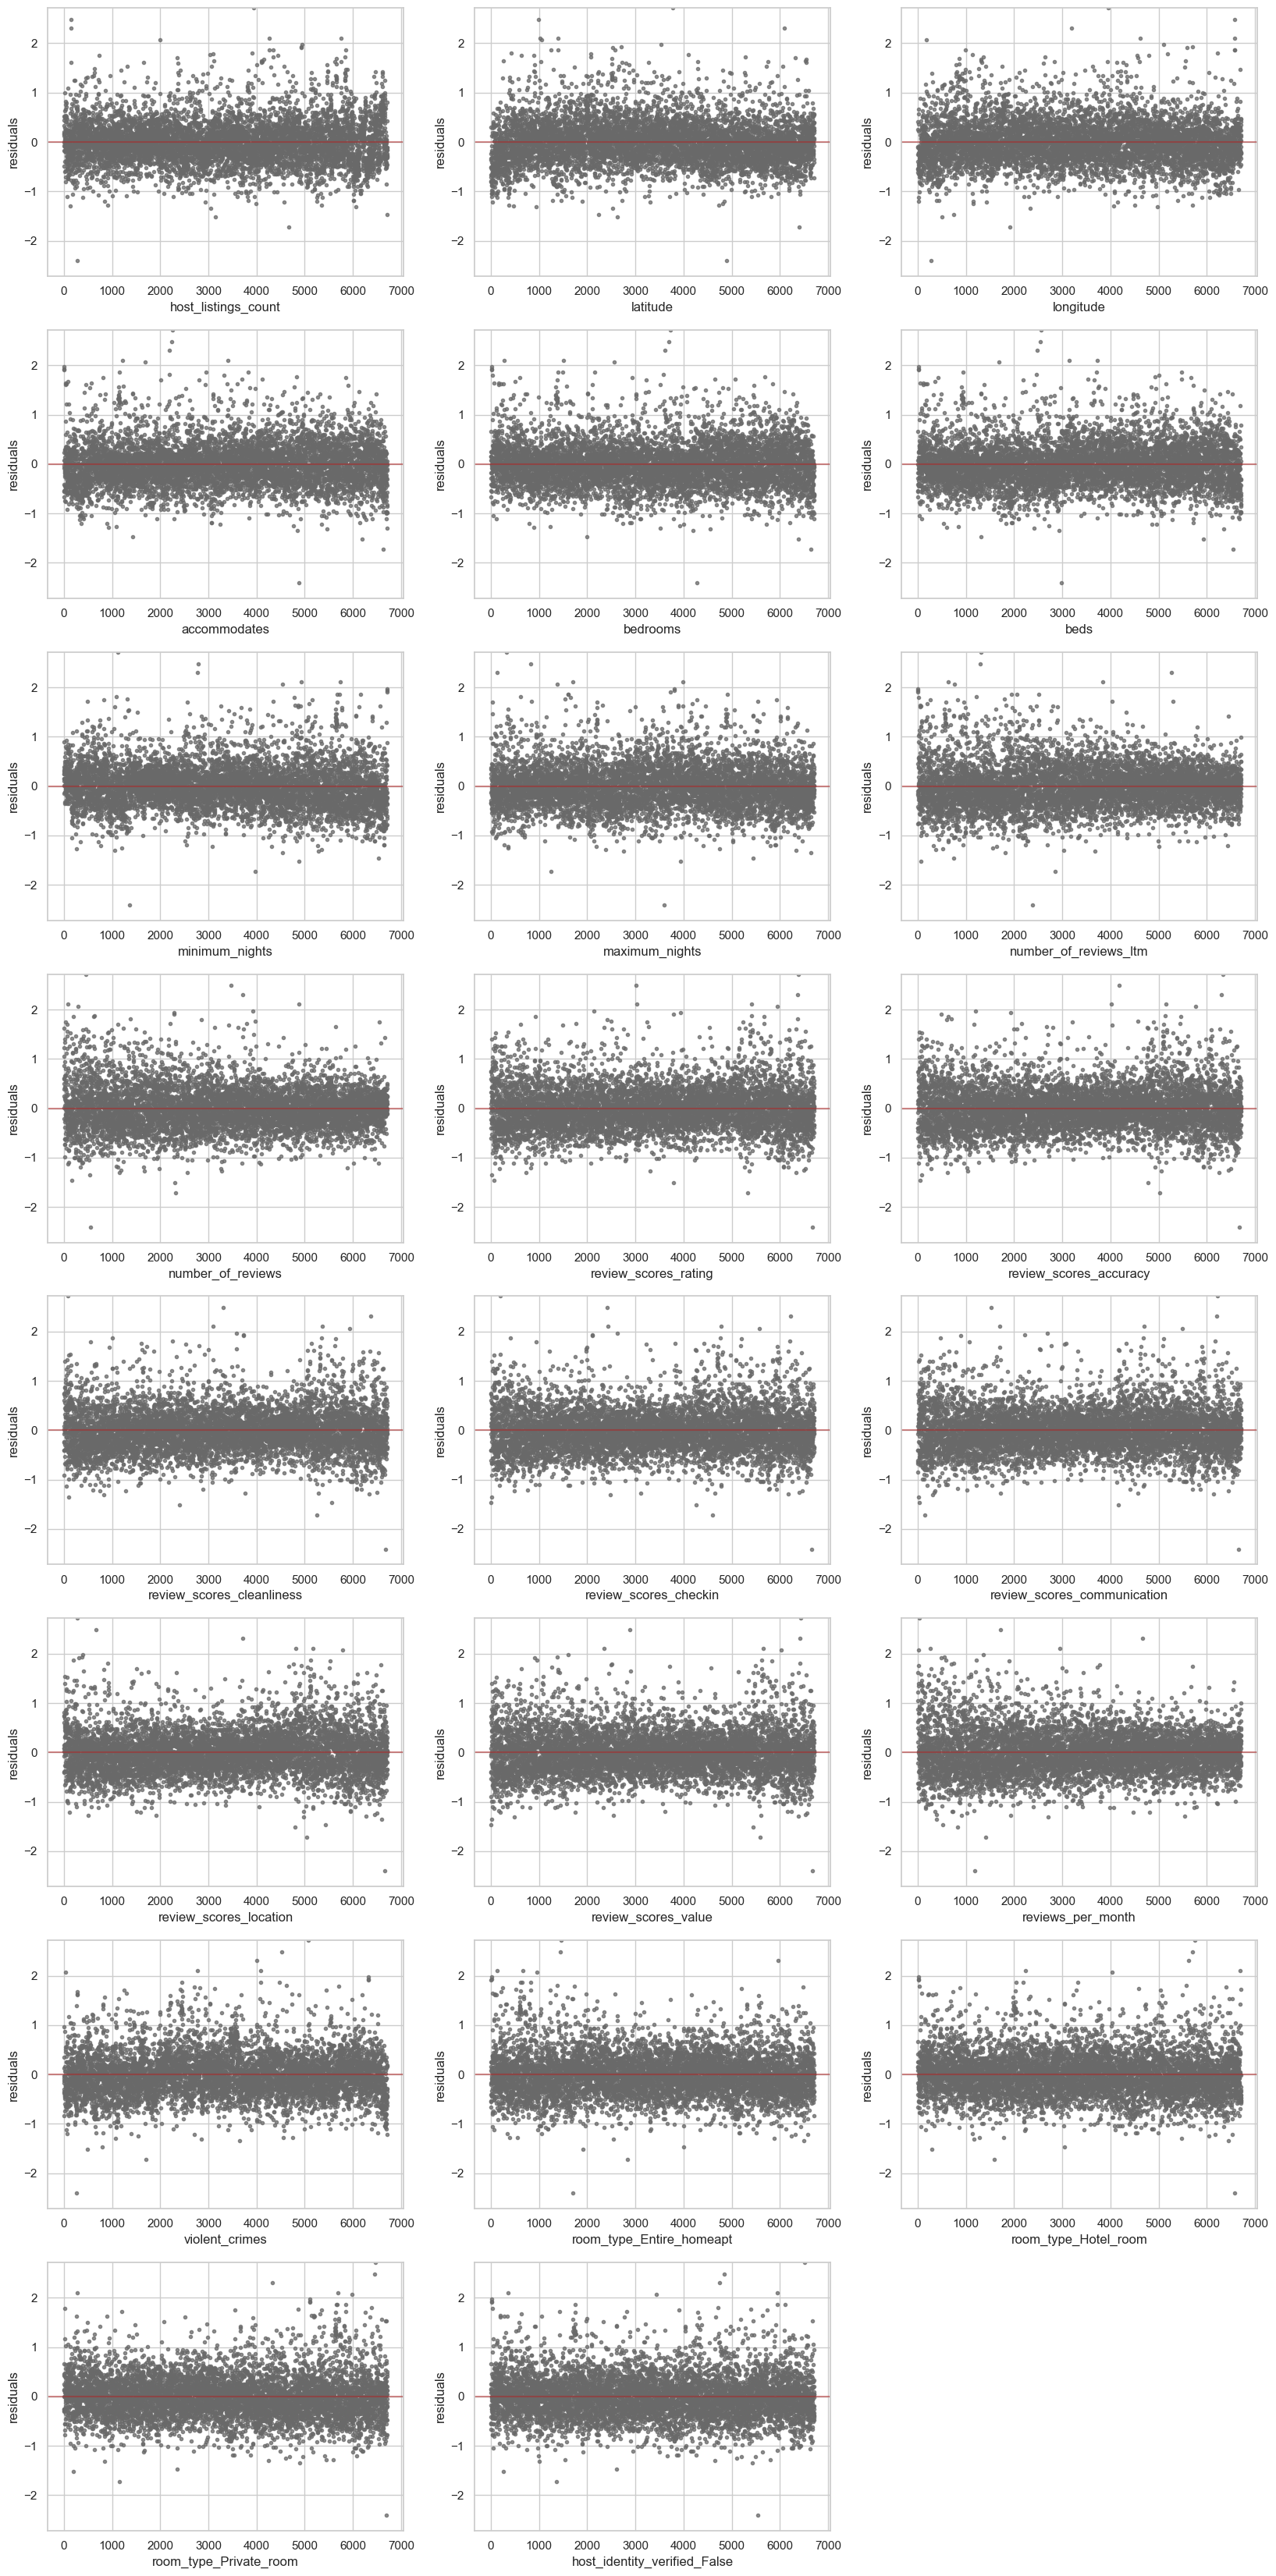

In [364]:
residuals = plot_residuals(result, df, model_variables)

Each of these plots looks in line with the desired distribution of residual points.

We wanted to understand how our model would perform more generally on data outside of the training set. To do this, we used cross validation. The below results are from 3 rounds of 10-fold cross validation:

In [365]:
print(r"95% CI for sigma:", (0.41461169, 0.47870567))

95% CI for sigma: (0.41461169, 0.47870567)


In [366]:
print(r"95% CI for R^2:", (0.46657763, 0.62646393))

95% CI for R^2: (0.46657763, 0.62646393)


We can also calculate the *mean* $\sigma$ and $R^2$ and calculate the 95% credible intervals for the *mean* values. This is useful for understanding the average performance of our model if we were to field it.

Let's start by seeing what the mean values are:

In [367]:
print("mean sigma: ", 0.4422992878849424)
print("mean R^2: ", 0.5607481871543466)

mean sigma:  0.4422992878849424
mean R^2:  0.5607481871543466


We also used the Bootstrap technique to get confidence intervals on our mean $\sigma$ and $R^2$.

In [368]:
print(r"95% CI for *mean* sigma:", (0.43830355, 0.44850006))

95% CI for *mean* sigma: (0.43830355, 0.44850006)


In [369]:
print(r"95% CI for *mean* R^2:", (0.54619598, 0.57009005))

95% CI for *mean* R^2: (0.54619598, 0.57009005)


We also wanted to understand if more data would help our model. That is, would we see a decreased value of $\sigma$ if we had used more data in our regression. To do this, we used learning curves and below are the results:

In [370]:
import random
import patsy

In [371]:
lc_result_sigma = learning_curves(models.linear_regression, model_string, df, lambda r: r["sigma"])

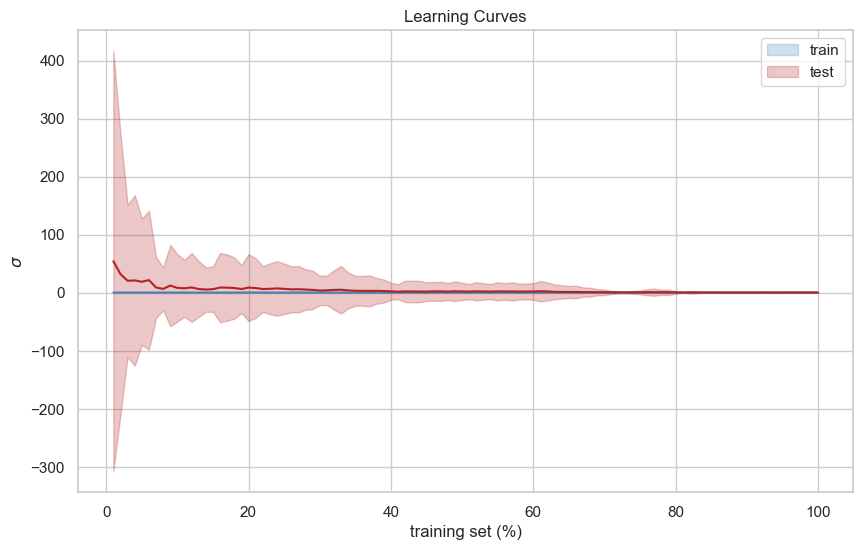

In [372]:
plot_learning_curves(lc_result_sigma, r"$\sigma$")

The deviation has mostly converged with some slightly sporadic changes in the value of $\sigma$ across the training set %.

## Predictions

We made 3 predictions with our regression model. The three test cases are tabulated below:

In [373]:
from tabulate import tabulate

In [374]:
table = [['Variable', 'Georgetown Mansion', 'Northeast Room', 'Average Listing'],
         ['host_listings_count',1,5,1.5],
         ['latitude',38.905,38.940,38.92],
         ['longitude',-77.075,-76.975,-77],
         ['accommodates',12,2,6],
         ['bedrooms',6,1,3],
         ['beds',8,1,3],
         ['minimum_nights',3,1,4],
         ['maximum_nights',365,1125,1125],
         ['number_of_reviews_ltm',8,12,10],
         ['number_of_reviews',30,48,39],
         ['review_scores_rating',4.89,4.5,4.68],
         ['review_scores_accuracy',4.75,4.8,4.79],
         ['review_scores_cleanliness',4.71,4.75,4.73],
         ['review_scores_checkin',4.82,4.88,4.85],
         ['review_scores_communication',4.81,4.85,4.83],
         ['review_scores_location',5,4.75,4.78],
         ['review_scores_value',5,4.6,4.7],
         ['reviews_per_month',1.5,1.7,1.6],
         ['violent_crimes',4,200,50],
         ['room_type_Entire_homeapt',1,0,1],
         ['room_type_Hotel_room',0,0,0],
         ['room_type_Private_room',0,0,0],
         ['room_type_Shared_room',0,1,0],
         ['host_identity_verified_False',0,1,0],
         ['host_identity_verified_True',1,0,1]
          ]
print(tabulate(table,headers="firstrow"))

Variable                        Georgetown Mansion    Northeast Room    Average Listing
----------------------------  --------------------  ----------------  -----------------
host_listings_count                          1                 5                   1.5
latitude                                    38.905            38.94               38.92
longitude                                  -77.075           -76.975             -77
accommodates                                12                 2                   6
bedrooms                                     6                 1                   3
beds                                         8                 1                   3
minimum_nights                               3                 1                   4
maximum_nights                             365              1125                1125
number_of_reviews_ltm                        8                12                  10
number_of_reviews                           30        

In [375]:
airbnbs = [['intercept',1,1,1],
         ['host_listings_count',1,5,1.5],
         ['latitude',38.905,38.940,38.92],
         ['longitude',-77.075,-76.975,-77],
         ['accommodates',12,2,6],
         ['bedrooms',6,1,3],
         ['beds',8,1,3],
         ['minimum_nights',3,1,4],
         ['maximum_nights',365,1125,1125],
         ['number_of_reviews_ltm',8,12,10],
         ['number_of_reviews',30,48,39],
         ['review_scores_rating',4.89,4.5,4.68],
         ['review_scores_accuracy',4.75,4.8,4.79],
         ['review_scores_cleanliness',4.71,4.75,4.73],
         ['review_scores_checkin',4.82,4.88,4.85],
         ['review_scores_communication',4.81,4.85,4.83],
         ['review_scores_location',5,4.75,4.78],
         ['review_scores_value',5,4.6,4.7],
         ['reviews_per_month',1.5,1.7,1.6],
         ['violent_crimes',4,200,50],
         ['room_type_Entire_homeapt',1,0,1],
         ['room_type_Hotel_room',0,0,0],
         ['room_type_Private_room',0,0,0],
#          ['room_type_Shared_room',0,1,0],
         ['host_identity_verified_False',0,1,0],
#          ['host_identity_verified_True',1,0,1]
          ]
georgetown_mansion = [var[1] for var in airbnbs]
northeast_room = [var[2] for var in airbnbs]
average_listing = [var[3] for var in airbnbs]

### Georgetown Mansion

This example was created using the values for all variables that we know contribute positively to price. Namely, the location being in the NW area of DC near Georgetown and having a high value for accomodation, beds, and rooms. It is also listed as a home/apt room type and has favorable reviews.

In [376]:
prediction = result["model"].predict([georgetown_mansion])
np.exp(prediction)

array([[869.42274248]])

\\$869.42 per night. With an error of 0.43 in log space, this leads to error bounds of:

In [377]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(370.7315553438238, 2038.9305799255333)

Our 95% confidence interval for a listings with these characteristics is (370.73, 2038.93).

### Northeast Room

This example was created using values of all variables that we know contribute negatively to price. This listing is located in Northeast DC, accomodates only 2 people in 1 room with 1 bed, has fair or slightly below average ratings, a high violent crime rate, and is listed as a shared room as opposed to an entire home/suite.

In [378]:
prediction = result["model"].predict([northeast_room])
np.exp(prediction)

array([[36.663587]])

\\$36.66 per night. With an error of 0.43 in log space, this leads to error bounds of:

In [379]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(15.633762460182966, 85.98177279459344)

Our 95% confidence interval for a listings with these characteristics is (15.63, 85.98).

### Average Listing

This example was created using average values for all numerical variables in the model and our best attempt at averaging our the cateogorical variables. This listing has 3 bedroom and 3 beds and hosts 6 people. It has average reviews in every category.

In [380]:
prediction = result["model"].predict([average_listing])
np.exp(prediction)

array([[217.45611794]])

\\$217.46 per night. With an error of 0.43 in log space this leads to error bounds of:

In [381]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(92.72571429652014, 509.96817427443943)

Our 95% confidence interval for a listings with these characteristics is (92.73, 509.97).

### Conclusions
Circling back to the goal of informing an AirBNB lister, we can use the regression model data illustrate a few things. Some of these are obvious, but it is comforting to see them rooted in data, as opposed to just relying on conventional wisdom.

When choosing a property for an AirBNB rental, the increasing the following attributes can help drive decisions and set expectations. 
* The more *northeast* you are in DC, the higher you can expect to list your rental
* Homes will rent out for more than apartments, which will rent out for more than rooms
* Private rentals will rent out for more than shared rentals
* Increasing the number your listing accomodates, and number of bedrooms may allow you to list higher
* overall review score, cleanliness may allow you to list higher

We can also use the regression model as a prediction tool, hopefully allowing us to set prices more aligned with the market than going through the trial and error of setting a price, seeing if is booked, and adjusting. The three cases shown above may be helpful in guiding an AirBNB lister in setting a price.


# Cleanup

Write to an html that can be shared.

In [382]:
# write to html
import os

os.system('jupyter nbconvert --to html report.ipynb')

[NbConvertApp] Converting notebook report.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: data.cells[{data__cells_x}] must be valid exactly by one definition (0 matches found)

Failed validating <unset> in notebook['data']['cells']:

On instance:
<unset>
[NbConvertApp] Writing 1463857 bytes to report.html


0

Close the connection

In [383]:
con.close()